In [1]:
#@title Imports

#!pip install Unidecode
#from unidecode import unidecode
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import ast
from matplotlib.lines import Line2D

from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import numpy as np

all_the_years = np.arange(1974, 2023, 1)
some_of_the_years = np.arange(1997, 2023, 1)
pd.set_option('display.colheader_justify', 'center')


sns.set_style('darkgrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

import re

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA", 
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC", 
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA", 
               "Washington Wizards": "WAS", "Capital Bullets": "CAP", "Buffalo Braves": "BUF", "Seattle SuperSonics": "SEA", "Washington Bullets": "WSB",
               "Kansas City-Omaha Kings": "KCO", "Kansas City Kings": "KCK", "Charlotte Hornets": "CHH"}

In [ ]:
#@title Import Selenium for shooting distribution scrape
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

**SCRAPE**

In [ ]:
#@title Scrape NBA regular season per 100
def scrape_nba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74_per100_data.csv", index=False)
scrape_nba_player_per100_data(all_the_years)

In [ ]:
#@title Scrape NBA regular season advanced
def scrape_nba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])
        final_players_advanced_df['Player'].apply(unidecode)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74_advanced_data.csv", index=False)
scrape_nba_advanced_data(all_the_years)

In [ ]:
#@title Scrape NBA regular season play-by-play

# import needed libraries
def scrape_nba_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/leagues/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_regular_playbyplay_data.csv", index=False)
scrape_nba_playbyplay_data(some_of_the_years)

In [ ]:
#@title Scrape NBA playoffs per 100
def scrape_nba_player_per100_data(years):

    final_players_per100_df = pd.DataFrame(columns = ['Year',  'TS%+', 'TeamColor', 'Player', 'Pos', 'Age', 'Tm', 
                                                    'G', 'GS', 'MP', 'FG', 'FGA', 
                                                    'FG%', '3P', '3PA', '3P%', '2P', 
                                                    '2PA', '2P%', 'FT', 'FTA', 'FT%', 
                                                    'ORB', 'DRB', 'TRB', 'AST', 'STL', 
                                                    'BLK', 'TOV', 'PF', 'PTS', 
                                                    'ORtg', 'DRtg']
                                         )
    for year in years:
        player_base_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("DRtg")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_base_stats)):
             player_base_stats[i].insert(0, year)
             player_base_stats[i].insert(1, 0)
             player_base_stats[i].insert(2, 0)
        headers.insert(0, "Year")
        headers.insert(1, "TS%+")
        headers.insert(2, "TeamColor")
        

        each_year = pd.DataFrame(player_base_stats, columns = headers)

        # remove blank columns
        each_year = each_year.drop('', axis=1)
        
        # append to final df
        final_players_per100_df = final_players_per100_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_per100_df = final_players_per100_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_per100_df['Player'] = final_players_per100_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_per100_df = final_players_per100_df.dropna()
        
    # print final_df
    print(final_players_per100_df.info)
    final_players_per100_df.to_csv("nba_player_since74playoffs_per100_data.csv", index=False)
scrape_nba_player_per100_data(all_the_years)

In [ ]:
#@title Scrape NBA playoffs advanced
def scrape_nba_advanced_data(years):

    final_players_advanced_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age', 
                                                        'Tm', 'TeamColor', 'G', 'MP', 'PER', 'TS%', 
                                                        '3PAr', 'FTr', 'ORB%', 'DRB%', 
                                                        'TRB%', 'AST%', 'STL%', 'BLK%', 
                                                        'TOV%', 'USG%', 'OWS', 'DWS', 
                                                        'WS', 'WS/48', 'OBPM', 'DBPM', 
                                                        'BPM', 'VORP'
                                                        ])
    for year in years:
        player_advanced_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_advanced.html"
        
        html = urlopen(player_advanced_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        headers = headers[1:headers.index("VORP")+1]

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_advanced_stats = [e for e in player_advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_advanced_stats)):
             player_advanced_stats[i].insert(0, year)
             player_advanced_stats[i].insert(5, 0)
        headers.insert(0, "Year")
        headers.insert(5, "TeamColor")

        each_year = pd.DataFrame(player_advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        final_players_advanced_df = final_players_advanced_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_advanced_df = final_players_advanced_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_advanced_df['Player'] = final_players_advanced_df['Player'].str.replace(r"[*]", '')
        #final_players_advanced_df['Player'] = final_players_advanced_df['Player'].apply(ast.literal_eval).str.decode("utf-8")
        #final_players_advanced_df['Player'] = unidecode(final_players_advanced_df['Player'])
        final_players_advanced_df['Player'].apply(unidecode)

        # remove any Na
        final_players_advanced_df = final_players_advanced_df.dropna()
        
    # print final_df
    print(final_players_advanced_df.info)
    final_players_advanced_df.to_csv("nba_player_since74playoffs_advanced_data.csv", index=False)
scrape_nba_advanced_data(all_the_years)

In [ ]:
#@title Scrape NBA playoffs play-by-play
# import needed libraries
def scrape_nba_playbyplay_data(years):
 
    final_players_playbyplay_df = pd.DataFrame(columns = ['Year', 'Player', 'Pos', 'Age',
                                                          'Tm', 'G', 'MP','OnCourt', 'On-Off', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'
                                                         ])
    
    for year in years:
        player_playbyplay_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        html = urlopen(player_playbyplay_url)
        soup = BeautifulSoup(html, features="lxml")
        
        # grab tr[1], as tr[0] is populated with categorical headers. Not headers for each columns of data (which are in tr[1])
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("Blkd")+1]


        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        player_playbyplay_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        player_playbyplay_stats = [e for e in player_playbyplay_stats if e != []]

        # add year to each player profile
        for i in range(0, len(player_playbyplay_stats)):
             player_playbyplay_stats[i].insert(0, year)   
        headers.insert(0, "Year")

        each_year = pd.DataFrame(player_playbyplay_stats, columns = headers)

        #rename some columns for less ambiguity
        each_year.columns=['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP','PG%', 'SG%', 'SF%', 'PF%', 'C%',
                            'OnCourt', 'On-Off', 'BadPass', 'LostBall', 'ShootCommit', 'OffCommit', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1', 'Blkd']
        # drop irrelevant columns
        each_year = each_year.drop(['PG%', 'SG%', 'SF%', 'PF%', 'C%', 'LostBall', 'ShootCommit', 'OffCommit', 'Blkd'], axis=1)

        # append dataframe
        final_players_playbyplay_df = final_players_playbyplay_df.append(each_year)

        # remove duplicate rows based on player being traded; first appearing row will be player's total between teams
        # adding 'year' to subset prevents players' future seasons from being deleted.
        # example: Avery Bradley was traded in 2019. Remove Avery Bradley rows from individual teams.
        # Keep TOT row (total) but don't remove Avery Bradley's 2020 season as a duplicate
        final_players_playbyplay_df = final_players_playbyplay_df.drop_duplicates(subset =['Player', 'Year'], keep="first")

        # remove apostrophes from name
        final_players_playbyplay_df['Player'] = final_players_playbyplay_df['Player'].str.replace(r"[*]", '')

        # remove any Na
        final_players_playbyplay_df = final_players_playbyplay_df.dropna()
        
    # print final_df
    print(final_players_playbyplay_df.info)
    final_players_playbyplay_df.to_csv("nba_player_playoff_playbyplay_data.csv", index=False)
scrape_nba_playbyplay_data(some_of_the_years)

In [ ]:
#@title Scrape NBA regular season league average
def scrape_nba_leaguestats_data():

        final_leaguestats_df = pd.DataFrame(columns = ['Year',	'Lg',	'Age',	'Ht',	'Wt',	'G',	'MP',	'FG',	'FGA',	'3P',
                                                      '3PA',	'FT',	'FTA',	'ORB',	'DRB',	'TRB',	'AST',	'STL',	'BLK',	'TOV',
                                                      'PF',	'PTS',	'FG%',	'3P%',	'FT%',	'Pace',	'eFG%',	'TOV%',	'ORB%',
                                                      'FT/FGA',	'ORtg', 'TS%'])
        
        player_base_url = f"https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"
        
        html = urlopen(player_base_url)
        soup = BeautifulSoup(html, features="lxml")
        
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]
        headers = headers[1:headers.index("ORtg")+1]
        headers.insert(32, "TS%")
        print(headers)

        # grab rows (excluding first empty row 0)
        #rows = soup.findAll('tr', class=None)[1:]
        rows = soup.findAll('tr', class_=None)[1:]


        player_base_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]
        for i in range(0, len(player_base_stats)):
          player_base_stats[i].insert(32, 0)

        # remove empty rows
        player_base_stats = [e for e in player_base_stats if e != []]

        final_leaguestats_df = pd.DataFrame(player_base_stats, columns = headers)

        final_leaguestats_df = final_leaguestats_df.drop(['Lg'], axis=1)

        final_leaguestats_df = final_leaguestats_df.iloc[1: , :]

        final_leaguestats_df.drop(final_leaguestats_df.index[20])
        final_leaguestats_df.drop(final_leaguestats_df.index[21])
        
        # print final_df
        print(final_leaguestats_df.info)
        final_leaguestats_df.to_csv("nba_leaguestats_data.csv", index=False)
scrape_nba_leaguestats_data()

**PEAK FUNCTION DEFINITIONS**

In [43]:
#@title 2 year peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def twoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0


    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0

    prevyear = 0


    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prevyear = 0
            prev_1back = 0
            prev_1min = 0
            prev_1g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+3 and len(indexlist) >=3:
            two_seasons_count = player['Year']
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevyear = inner_row['Year']
            prevYearTeam = inner_row['Tm']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (prevYearTeam == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min, games]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [44]:
#@title 3 year peaks function

# def threeyearpeak(df, valuestring):
# returns a dataframe containing 3 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 3 year stretches of 'valuestring' AND the listed years from each 3 year stretch + minutes played across the 3 seasons.
# EX: threeyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '7120'
def threeyearpeak(df, valuestring):
  three_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue and minutes
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    three_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0

    # previous two years; e.g. 2014, 2015 before 2016. 2016, 2019 if these were the two most recent seasons for a player before 2020.
    prevyear = 0
    prev2year = 0

    indexlist = []
    running_three_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min)
          if running_min == 0:
            running_min = 1
          games = (inner_row['G'] + prev_1g + prev_2g)
          running_three_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prev2YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_1g = 0
            prev_2g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+2 and len(indexlist) >=3:
            if (prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev2year, present_year)
            else:
              present_peak_years = '{}, {}, {}'.format(prev2year, prevyear, present_year)

          if three_seasons_count == original_year+3 and len(indexlist) >=3:
            three_seasons_count = player['Year']
          if present_year == original_year+1:
            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev_2g = prev_1g
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_2back = prev_1back
            prev_2g = prev_1g
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevyear = inner_row['Year']
            prevYearTeam = inner_row['Tm']

          three_seasons_count = three_seasons_count + 1

          if len(indexlist) >=3:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (prevYearTeam == old_team and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_three_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_three_year_peak_val, running_min, games]], columns=cols)
            three_year_peak = three_year_peak.append(df_temp)
            outfile = f"three_year_peak_{valuestring}_data.csv"
            three_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [45]:
#@title 4 year peaks function

# def fouryearpeak(df, valuestring):
# returns a dataframe containing 4 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 4 year stretches of 'valuestring' AND the listed years from each 4 year stretch + minutes played across the 5 seasons.
# EX: fouryearpeak(import_player_since74_per100_df, 'PTS') returns 4 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-19', 'Kris Middleton', 'MIL' '22.11', '12139'
def fouryearpeak(df, valuestring):
  four_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    four_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0


    indexlist = []
    running_four_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_3g + prev_2g + prev_1g
          running_four_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev3YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+3 and len(indexlist) >=4:
            if (prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev3year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}'.format(prev3year, prev2year, prevyear, present_year)

          if four_seasons_count == original_year+4 and len(indexlist) >=4:
            four_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          four_seasons_count = four_seasons_count + 1

          if len(indexlist) >=4:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_four_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_four_year_peak_val, running_min, games]], columns=cols)
            four_year_peak = four_year_peak.append(df_temp)
            outfile = f"four_year_peak_{valuestring}_data.csv"
            four_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [46]:
#@title 5 year peaks function

# def fiveyearpeak(df, valuestring):
# returns a dataframe containing 5 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 5 year stretches of 'valuestring' AND the listed years from each 5 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 5 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def fiveyearpeak(df, valuestring):
  five_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    five_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0


    indexlist = []
    running_five_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_4g + prev_3g + prev_2g + prev_1g
          running_five_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev4YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev4year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}'.format(prev4year, prev3year, prev2year, prevyear, present_year)

          if five_seasons_count == original_year+5 and len(indexlist) >=5:
            five_seasons_count = player['Year']
          if present_year == original_year+1:
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          five_seasons_count = five_seasons_count + 1

          if len(indexlist) >=5:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_five_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_five_year_peak_val, running_min, games]], columns=cols)
            five_year_peak = five_year_peak.append(df_temp)
            outfile = f"five_year_peak_{valuestring}_data.csv"
            five_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [47]:
#@title 6 year peaks function

# def sixyearpeak(df, valuestring):
# returns a dataframe containing 6 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 6 year stretches of 'valuestring' AND the listed years from each 6 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 6 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-21', 'Kris Middleton', 'MIL' '22.11', '12139'
def sixyearpeak(df, valuestring):
  six_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    six_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0


    indexlist = []
    running_six_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_5g + prev_4g + prev_3g + prev_2g + prev_1g
          running_six_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev5YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+5 and len(indexlist) >=6:
            if (prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev5year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}'.format(prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if six_seasons_count == original_year+6 and len(indexlist) >=6:
            six_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          six_seasons_count = six_seasons_count + 1

          if len(indexlist) >=6:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_six_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_six_year_peak_val, running_min, games]], columns=cols)
            six_year_peak = six_year_peak.append(df_temp)
            outfile = f"six_year_peak_{valuestring}_data.csv"
            six_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [48]:
#@title 7 year peaks function

# def sevenyearpeak(df, valuestring):
# returns a dataframe containing 7 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 7 year stretches of 'valuestring' AND the listed years from each 7 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 7 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-22', 'Kris Middleton', 'MIL' '22.11', '12139'
def sevenyearpeak(df, valuestring):
  seven_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0
    prev_6g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    seven_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0
    prev6YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0


    indexlist = []
    running_seven_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_6g + prev_5g + prev_4g + prev_3g + prev_2g + prev_1g
          running_seven_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev6YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prev6YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            prev_6g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+6 and len(indexlist) >=7:
            if (prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev6year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}'.format(prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if seven_seasons_count == original_year+7 and len(indexlist) >=7:
            seven_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          seven_seasons_count = seven_seasons_count + 1

          if len(indexlist) >=7:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_seven_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_seven_year_peak_val, running_min, games]], columns=cols)
            seven_year_peak = seven_year_peak.append(df_temp)
            outfile = f"seven_year_peak_{valuestring}_data.csv"
            seven_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [49]:
#@title 8 year peaks function

# def eightyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def eightyearpeak(df, valuestring):
  eight_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0
    prev_6g = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0
    prev_7g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eight_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0
    prev6YearTeam = 0
    prev7YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0


    indexlist = []
    running_eight_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g + prev_2g + prev_3g + prev_4g + prev_5g + prev_6g + prev_7g
          running_eight_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev7YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prev6YearTeam = 0
            prev7YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            prev_6g = 0
            prev_7g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev7year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}'.format(prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if eight_seasons_count == original_year+10 and len(indexlist) >=10:
            eight_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_7back = prev_6back
            prev7YearTeam = prev6YearTeam
            prev_7min = prev_6min
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prev_1g = inner_row['G']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7YearTeam = prev6YearTeam
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6YearTeam = prev5YearTeam
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          eight_seasons_count = eight_seasons_count + 1

          if len(indexlist) >=8:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev6YearTeam and inner_row['Tm'] == prev5YearTeam and inner_row['Tm'] == prev4YearTeam and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_eight_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_eight_year_peak_val, running_min, games]], columns=cols)
            eight_year_peak = eight_year_peak.append(df_temp)
            outfile = f"eight_year_peak_{valuestring}_data.csv"
            eight_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [50]:
#@title 10 year peaks function

# def tenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def tenyearpeak(df, valuestring):
  ten_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0
    prev_1g = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0
    prev_2g = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0
    prev_3g = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0
    prev_4g = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0
    prev_5g = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0
    prev_6g = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0
    prev_7g = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0
    prev_8g = 0

    # 9 seasons ago's peakvalue
    prev_9back = 0
    prev_9min = 0
    prev_9g = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    ten_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevYearTeam = 0
    prev2YearTeam = 0
    prev3YearTeam = 0
    prev4YearTeam = 0
    prev5YearTeam = 0
    prev6YearTeam = 0
    prev7YearTeam = 0
    prev8YearTeam = 0
    prev9YearTeam = 0

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0
    prev9year = 0


    indexlist = []
    running_ten_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    dis_old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min + prev_9min)
          if running_min == 0:
            running_min = 1
          games = inner_row['G'] + prev_1g + prev_2g + prev_3g + prev_4g + prev_5g + prev_6g + prev_7g + prev_8g + prev_9g
          running_ten_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)) + (prev_9back * (prev_9min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          dis_old_team = prev9YearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev2YearTeam = 0
            prev3YearTeam = 0
            prev4YearTeam = 0
            prev5YearTeam = 0
            prev6YearTeam = 0
            prev7YearTeam = 0
            prev8YearTeam = 0
            prev9YearTeam = 0
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev9year = 0
            prev_9back = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            prev_9min = 0
            prev_1g = 0
            prev_2g = 0
            prev_3g = 0
            prev_4g = 0
            prev_5g = 0
            prev_6g = 0
            prev_7g = 0
            prev_8g = 0
            prev_9g = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev9year == (prev8year-1) and prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev9year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev9year, prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if ten_seasons_count == original_year+10 and len(indexlist) >=10:
            ten_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_9back = prev_8back
            prev9YearTeam = prev8YearTeam
            prev_9min = prev_8min
            prev9year = prev8year
            prev_9g = prev_8g

            prev_8back = prev_7back
            prev8YearTeam = prev7YearTeam
            prev_8min = prev_7min
            prev8year = prev7year
            prev_8g = prev_7g

            prev_7back = prev_6back
            prev7YearTeam = prev6YearTeam
            prev_7min = prev_6min
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev6YearTeam = prev5YearTeam
            prev_6min = prev_5min
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev5YearTeam = prev4YearTeam
            prev_5min = prev_4min
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev4YearTeam = prev3YearTeam
            prev_4min = prev_3min
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev3YearTeam = prev2YearTeam
            prev_3min = prev_2min
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev2YearTeam = prevYearTeam
            prev_2min = prev_1min
            prev2year = prevyear
            prev_2g = prev_1g
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']
          if present_year > original_year:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9YearTeam = prev8YearTeam
            prev9year = prev8year
            prev_9g = prev_8g

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8YearTeam = prev7YearTeam
            prev8year = prev7year
            prev_8g = prev_7g

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7YearTeam = prev6YearTeam
            prev7year = prev6year
            prev_7g = prev_6g

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6YearTeam = prev5YearTeam
            prev6year = prev5year
            prev_6g = prev_5g

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5YearTeam = prev4YearTeam
            prev5year = prev4year
            prev_5g = prev_4g
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4YearTeam = prev3YearTeam
            prev4year = prev3year
            prev_4g = prev_3g

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3YearTeam = prev2YearTeam
            prev3year = prev2year
            prev_3g = prev_2g

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2YearTeam = prevYearTeam
            prev2year = prevyear
            prev_2g = prev_1g

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']
            prev_1g = inner_row['G']

          ten_seasons_count = ten_seasons_count + 1

          if len(indexlist) >=10:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP', 'G']
            if (inner_row['Tm'] == dis_old_team and inner_row['Tm'] == prev8YearTeam and inner_row['Tm'] == prev7YearTeam and inner_row['Tm'] == prev6YearTeam and inner_row['Tm'] == prev5YearTeam and inner_row['Tm'] == prev4YearTeam and inner_row['Tm'] == prev3YearTeam and inner_row['Tm'] == prev2YearTeam and prevYearTeam == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_ten_year_peak_val, running_min, games]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_ten_year_peak_val, running_min, games]], columns=cols)
            ten_year_peak = ten_year_peak.append(df_temp)
            outfile = f"ten_year_peak_{valuestring}_data.csv"
            ten_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

**IMPORT RAW DATA**

In [30]:
#@title Manually add team abbrev, and teamcolors

league_avg_df = pd.DataFrame(columns=['Year','TS%'])

league_avg_df = league_avg_df.append({
     "Year": "2022",
     "TS%":  .566, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2021",
     "TS%":  .572, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2020",
     "TS%":  .565, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2019",
     "TS%":  .560, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2018",
     "TS%":  .556, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2017",
     "TS%":  .552, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2016",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2015",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2014",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2013",
     "TS%":  .535, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2012",
     "TS%":  .527, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2011",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2010",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2009",
     "TS%":  .544, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2008",
     "TS%":  .540, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2007",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2006",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({  
     "Year": "2005",
     "TS%":  .529, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2004",
     "TS%":  .516, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2003",
     "TS%":  .519, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2002",
     "TS%":  .520, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2001",
     "TS%":  .518, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "2000",
     "TS%":  .523, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1999",
     "TS%":  .511, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1998",
     "TS%":  .524, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1997",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1996",
     "TS%":  .542, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1995",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1994",
     "TS%":  .528, }, ignore_index=True)
league_avg_df = league_avg_df.append({
      "Year": "1993",
     "TS%":  .536, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1992",
     "TS%":  .531, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1991",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1990",
     "TS%":  .537, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1989",
     "TS%":  .537, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1988",
     "TS%":  .538, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1987",
     "TS%":  .538, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1986",
     "TS%":  .541, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1985",
     "TS%":  .543, }, ignore_index=True)   
league_avg_df = league_avg_df.append({
     "Year": "1984",
     "TS%":  .543, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1983",
     "TS%":  .531, }, ignore_index=True) 
league_avg_df = league_avg_df.append({
     "Year": "1982",
     "TS%":  .539, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1981",
     "TS%":  .534, }, ignore_index=True)
league_avg_df = league_avg_df.append({
    "Year": "1980",
     "TS%":  .531, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1979",
     "TS%":  .530, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1978",
     "TS%":  .515, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1977",
     "TS%":  .511, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1976",
     "TS%":  .504, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1975",
     "TS%":  .502, }, ignore_index=True)
league_avg_df = league_avg_df.append({
     "Year": "1974",
     "TS%":  .503, }, ignore_index=True)

team_colors = {"ATL": "#E03A3E", "BOS": "#007A33", "BRK": "#000000", "BUF": "#ff6314", "CAP": "#E31837", "CHA": "#00788C", 
               "CHI": "#CE1141", "CHO": "#f26631", "CLE": "#860038", "DAL": "#00538C", "DEN": "#0E2240", "DET": "#1D42BA",
               "GSW": "#FFC72C", "HOU": "#CE1141", "IND": "#002D62", "KCO": "#5A2D81", "KCK": "#5A2D81", "LAC": "#C8102E", 
               "LAL": "#552583", "MEM": "#5D76A9", "MIA": "#98002E", "MIL": "#00471B", "MIN": "#78BE20", "NOH": "#008fc5", 
               "NOP": "#85714D", "NOJ": "#00471B", "NJN": "#00275d", "NYK": "#006BB6", "OKC": "#007AC1", "ORL": "#0077C0", 
               "PHI": "#006BB6", "PHO": "#1D1160", "POR": "#E03A3E", "SAC": "#5A2D81", "SAS": "#C4CED4", "SEA": "#00653A", 
               "TOR": "#CE1141", "TOT": "pink", "UTA": "#00471B", "WAS": "#E31837", "WSB": "#E31837"}

team_abbrev = {"Atlanta Hawks" : "ATL",       "Boston Celtics": "BOS",        "Brooklyn Nets": "BRK",         "Charlotte Bobcats": "CHA", 
               "Chicago Bulls": "CHI",      "Charlotte Hornets": "CHO",      "Cleveland Cavaliers": "CLE",     "Dallas Mavericks": "DAL",
               "Denver Nuggets": "DEN",     "Detroit Pistons": "DET",       "Golden State Warriors": "GSW",     "Houston Rockets": "HOU",
               "Indiana Pacers": "IND",     "Los Angeles Clippers": "LAC",  "Los Angeles Lakers": "LAL",      "Memphis Grizzlies": "MEM",
               "Miami Heat": "MIA",         "Milwaukee Bucks": "MIL",     "Minnesota Timberwolves": "MIN",  "New Orleans Hornets": "NOH",
               "New Orleans Pelicans": "NOP", "New Jersey Nets": "NJN",     "New York Knicks": "NYK",     "Oklahoma City Thunder": "OKC", 
               "Orlando Magic": "ORL",     "Philadelphia 76ers": "PHI",      "Phoenix Suns": "PHO",       "Portland Trail Blazers": "POR",
               "Sacramento Kings": "SAC",    "San Antonio Spurs": "SAS",       "Toronto Raptors": "TOR",               "Utah Jazz": "UTA", 
               "Washington Wizards": "WAS"}

In [3]:
#@title Import data and add team colors for advanced, play-by-play, per 100, and league avg data

# per 100 posssessions
import_player_since74_per100_df = pd.read_csv('nba_player_since74_per100_data.csv')

# add team color for per 100 posssessions
import_player_since74_per100_df['TeamColor'] = import_player_since74_per100_df['Tm'].map(team_colors)

# per 100 playoff posssessions
import_player_since74playoffs_per100_df = pd.read_csv('nba_player_since74playoffs_per100_data.csv')

# add team color for playoff per 100 posssessions
import_player_since74playoffs_per100_df['TeamColor'] = import_player_since74playoffs_per100_df['Tm'].map(team_colors)



# advanced
import_player_since74_advanced_df = pd.read_csv('nba_player_since74_advanced_data.csv', encoding='utf8')

# advanced playoffs
import_player_since74playoffs_advanced_df = pd.read_csv('nba_player_since74playoffs_advanced_data.csv', encoding='utf8')



# play-by-play
import_player_regular_playbyplay_df = pd.read_csv('nba_player_regular_playbyplay_data.csv', encoding='utf8')

# add team color for play-by-play
import_player_regular_playbyplay_df['TeamColor'] = import_player_regular_playbyplay_df['Tm'].map(team_colors)

# play-by-play playoffs
import_player_since74playoffs_playbyplay_df = pd.read_csv('nba_player_playoff_playbyplay_data.csv', encoding='utf8')

# add team color for playoff play-by-play
import_player_since74playoffs_playbyplay_df['TeamColor'] = import_player_since74playoffs_playbyplay_df['Tm'].map(team_colors)





# import league avg data

# league avg
import_leagueavgsince74_df = pd.read_csv('nba_leaguestats_data.csv')

# drop NBA seasons from inception of league until 1973 (final year without per possession data)
import_leagueavgsince74_df.drop(import_leagueavgsince74_df.tail(26).index,inplace=True)

# change from '2020-21' to '2021' and '2019-20' to '2020'... and so on
for i, trial in import_leagueavgsince74_df.iterrows():
   import_leagueavgsince74_df.loc[i, "Season"] = 2022-i

In [4]:
#@title Import per 75 data (can be used in place of 'Calculate per 75' cells with necessitated imported data')

# per 75 posssessions
import_player_since74_per75_df = pd.read_csv('nba_player_since74_per75_data.csv')

# add team color for per 75 posssessions
import_player_since74_per75_df['TeamColor'] = import_player_since74_per75_df['Tm'].map(team_colors)

# per 75 playoff posssessions
import_player_since74playoffs_per75_df = pd.read_csv('nba_player_since74playoffs_per75_data.csv')

# add team color for playoff per 75 posssessions
import_player_since74playoffs_per75_df['TeamColor'] = import_player_since74playoffs_per75_df['Tm'].map(team_colors)

# per 75 adjusted playoff posssessions
adjusted_playoff_per_75_df = pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv')

# add team color for playoff per 75 adjusted posssessions
adjusted_playoff_per_75_df['TeamColor'] = adjusted_playoff_per_75_df['Tm'].map(team_colors)

**CALCULATE PER 75 AND TS+**

In [ ]:
#@title Scrape League Average TS% Since 1974 (not working?)
#@title Scrape NBA regular season advanced
def scrape_nba_ts_data(years):

    league_avg_ts_df = pd.DataFrame(columns = ['Year', 'TS%'])

    for year in years:
        league_stats_url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html"
        
        wd = webdriver.Chrome('chromedriver',options=chrome_options)
        wd.get(league_stats_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)

        for first_div in soup.find_all('div', attrs={'id': '#content'}):
          second_div = first_div.find('div', attrs={'id': '#all_advanced_team'})
          first_table = second_div.find('table', attrs={'id': '#advanced-team'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})
        print(rows)

        # grab rows (excluding first empty row 0)
        rows = soup.findAll('tr')[1:]
        advanced_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

        # remove empty rows
        advanced_stats = [e for e in advanced_stats if e != []]

        # add year to each player profile
        for i in range(0, len(advanced_stats)):
             advanced_stats[i].insert(0, year)
        headers.insert(0, "Year")
        print(headers)

        each_year = pd.DataFrame(advanced_stats, columns = headers)
        
        # remove blank columns
        each_year = each_year.drop('\xa0',axis=1)

        # append dataframe
        league_avg_ts_df = league_avg_ts_df.append(each_year)

        # remove any Na
        league_avg_ts_df = league_avg_ts_df.dropna()
        
    # print final_df
    print(league_avg_ts_df.info)
    league_avg_ts_df.to_csv("nba_player_since74_advanced_data.csv", index=False)
scrape_nba_ts_data(all_the_years)

In [31]:
#@title Calculate regular season per 75 and regular season TS+

# Calculate per 75 points
import_player_since74_per75_df = import_player_since74_per100_df.copy()
import_player_since74_per75_df['PTS'] = import_player_since74_per75_df['PTS'] * .75

# Add TS+
i = 2022
for yearloop in range(49):
  for j, row in import_player_since74_per75_df.iterrows():
    if row['Year'] == i:
      import_player_since74_per75_df.iat[j, 1] = (import_player_since74_advanced_df.iat[j, 9] / league_avg_df.iat[yearloop, 1]) * 100
  i = i - 1

import_player_since74_per75_df = import_player_since74_per75_df[import_player_since74_per75_df['TS%+'].notna()]
outfile = f"nba_player_since74_per75_data.csv"
import_player_since74_per75_df.to_csv(outfile, index=False)

In [ ]:
#@title Calculate playoffs per 75
# Calculate playoffs per 75
import_player_since74playoffs_per75_df = import_player_since74playoffs_per100_df.copy()
import_player_since74playoffs_per75_df['PTS'] = import_player_since74playoffs_per75_df['PTS'] * .75

outfile = f"nba_player_since74playoffs_per75_data.csv"
import_player_since74playoffs_per75_df.to_csv(outfile, index=False)

**SHOOTING DISTRIBUTION DATA**

In [ ]:
#@title print_single_player_nba_shooting_data function

def print_single_player_nba_shooting_data(player, player_url):
 
    final_player_shooting_df = pd.DataFrame(columns = ['Lg', 'G', 'MP', 'FG%', 'Dist.', 
                                                          '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', '2P', '0-3', '3-10', 
                                                          '10-16', '16-3P', '3P', '2P', '3P',	'%FGAdunks',	'#dunks',	'%3PAcorner',
                                                          '3P%corner', 'Heave Att.', 'Heave Mad.'
                                                         ])

    wd = webdriver.Chrome('chromedriver',options=chrome_options)
    wd.get(player_url)          
    html = wd.page_source
    soup = BeautifulSoup(html)

    for first_div in soup.find_all('div', attrs={'id': 'all_shooting-playoffs_shooting'}):
      second_div = first_div.find('div', attrs={'id': 'switcher_shooting-playoffs_shooting'})
      first_table = second_div.find('table', attrs={'id': 'playoffs_shooting'})
      foot = first_table.find('tfoot')

    rows = foot.find('tr')
    player_shooting_distribution_stats = [[td.getText() for td in rows.findAll('td')]]

    # remove empty rows
    player_shooting_distribution_stats = [e for e in player_shooting_distribution_stats if e != []]

    new_list = [[s for s in sub_list if s] for sub_list in player_shooting_distribution_stats]

    headers = ['Lg', 'G', 'MP', 'FG%', 'Dist.', 
               '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', '2P', '0-3', '3-10', 
               '10-16', '16-3P', '3P', '2P', '3P',	'%FGAdunks',	'#dunks',	'%3PAcorner',
               '3P%corner', 'Heave Att.', 'Heave Mad.']

    each_year = pd.DataFrame(new_list, columns = headers)

    # append dataframe
    final_player_shooting_df = final_player_shooting_df.append(each_year)

    new_df = pd.DataFrame(columns = ['Player', 'Midrange PPS', 'Mid Freq', 'PP75', 'TS+', 'MP'])
    headers_list = ['Player', 'Midrange PPS', 'Mid Freq', 'PP75', 'TS+', 'MP']

    freq = float(final_player_shooting_df['10-16freq']) + float(final_player_shooting_df['16-3Pfreq'])


    pps = ((float(final_player_shooting_df['10-16freq']) / freq) * ( ( float(final_player_shooting_df['10-16'] )*2 ))) + ((float(final_player_shooting_df['16-3Pfreq']) / freq) * ( ( float(final_player_shooting_df['16-3P'] ) *2)))
    round(pps, 3)
    round(freq, 3)

    (player, midrange_PPS, mid_Freq, pp75, ts, mp) = playoff_career_scoring_output(player, pps, freq, import_player_since74playoffs_per75_df)
    new_df.loc[len(new_df)] = [player, midrange_PPS, mid_Freq, pp75, ts, mp]
    outfile = f"{player}_Playoff_Midrange_Data.csv"
    print(new_df)
    new_df.to_csv(outfile, index=False)
def playoff_career_scoring_output(player, pps, freq, postseason_data):
  player_data = postseason_data[(postseason_data.Player == player)]

  total_mp = 0
  total_pts = 0
  total_ts = 0
  mp_list = []

  # find total minutes a
  for row in player_data['MP']:
    mp_list.append(row)
    total_mp += row
  if total_mp == 0:
    total_mp = 1

  # find total PTS a
  i = 0
  for row in player_data['PTS']:
    total_pts += row * (mp_list[i] / total_mp)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_data['TS%+']:
    total_ts += row * (mp_list[i] / total_mp)
    i = i + 1

  round(total_pts, 2)
  total_pts = '%.2f' % round(total_pts, 2)
  total_ts = '%.2f' % round(total_ts, 2)
  pps = '%.3f' % round(pps, 3)
  return (player, pps, freq, total_pts, total_ts, total_mp)

In [ ]:
print_single_player_nba_shooting_data('Damian Lillard', f"https://www.basketball-reference.com/players/l/lillada01.html")

       Player     Midrange PPS  Mid Freq  PP75    TS+     MP 
0  Damian Lillard     0.612       0.202   23.86  101.86  2458


In [ ]:
#@title nba playoff 10 - 3P shooting scrape

def nba_10_to_3P_data(url_df):

    new_df = pd.DataFrame(columns = ['Player', 'Midrange PPS', 'Mid Freq', 'Mid FGA per 75', 'PP75', 'TS+', 'MP'])

    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'all_shooting-playoffs_shooting'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_shooting-playoffs_shooting'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_shooting'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_shooting_distribution_stats = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_shooting_distribution_stats = [e for e in player_shooting_distribution_stats if e != []]

      headers = ['dum1', 'dum2', 'Lg', 'dum3', 'G', 'MP', 'FG%', 'Dist.', 'dum4',
                '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', 
                 'dum5', '2P', '0-3', '3-10', '10-16', '16-3P', '3P', 'dum6', '2P', 
                 '3P', 'dum7', '%FGAdunks',	'#dunks',	'dum8', '%3PAcorner', '3P%corner', 'dum9', 'Heave Att.', 'Heave Mad.']

      shooting_dist_data = pd.DataFrame(player_shooting_distribution_stats, columns = headers)

      # drop empty cells
      shooting_dist_data = shooting_dist_data.drop(['dum1', 'dum2', 'dum3', 'dum4', 'dum5', 'dum6', 'dum7', 'dum8', 'dum9'], axis=1)

      tmp_df = pd.DataFrame(columns = ['Player', 'Midrange PPS', 'Mid Freq', 'Mid FGA per 75', 'PP75', 'TS+', 'MP'])

      if int(shooting_dist_data['MP']) <= 1000:
        continue

      # took only long mid range FGA
      if shooting_dist_data['10-16freq'][0] == '.000':
        if shooting_dist_data['16-3Pfreq'][0] != '.000':
          pps = float(shooting_dist_data['16-3P']) *2
          freq = float(shooting_dist_data['16-3Pfreq'])
          round(pps, 3)
          round(freq, 3)
      
      # took only short mid range FGA
      elif shooting_dist_data['16-3Pfreq'][0] == '.000':
        if shooting_dist_data['10-16freq'][0] != '.000':
          pps = float(shooting_dist_data['10-16']) *2
          freq = float(shooting_dist_data['10-16freq'])
          round(pps, 3)
          round(freq, 3)
      # never took a single shot in the playoffs
      elif shooting_dist_data['16-3Pfreq'][0] == '':
        continue
      # took both short and long mid range FGA
      else:
        freq = float(shooting_dist_data['10-16freq']) + float(shooting_dist_data['16-3Pfreq'])
        if freq == 0:
          continue
        pps = ((float(shooting_dist_data['10-16freq']) / freq) * ( ( float(shooting_dist_data['10-16'] )*2 ))) + ((float(shooting_dist_data['16-3Pfreq']) / freq) * ( ( float(shooting_dist_data['16-3P'] ) *2)))
        round(pps, 3)
        round(freq, 3)




      # scrape Playoff FGA per 100 possessions
      for first_div in soup.find_all('div', attrs={'id': 'all_per_poss-playoffs_per_poss'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_per_poss-playoffs_per_poss'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_per_poss'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_per_100_data = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_per_100_data = [e for e in player_per_100_data if e != []]

      headers = ['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg']

      playoff_fga = pd.DataFrame(player_per_100_data, columns = headers)

      # append dataframe
      playoff_fga = playoff_fga.drop(['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg'], axis=1)
      
      playoff_fga_per_75 = (float(playoff_fga['FGA']) * .75) * (freq)

      (player, midrange_PPS, mid_fga, mid_Freq, pp75, ts, mp) = playoff_career_scoring_output(player, pps, playoff_fga_per_75, freq, adjusted_playoff_per_75_df)
      tmp_df.loc[len(tmp_df)] = [player, midrange_PPS, mid_Freq, mid_fga, pp75, ts, mp]
      new_df = new_df.append(tmp_df)
      print(tmp_df)
    outfile = f"NBA_Playoff_Midrange_df.csv"
    new_df.to_csv(outfile, index=False)
def playoff_career_scoring_output(player, pps, fga, freq, postseason_data):
  player_data = postseason_data[(postseason_data.Player == player)]
  player_data = player_data[(player_data.Year >= 1997)]

  total_mp = 0
  total_pts = 0
  total_ts = 0
  mp_list = []

  # find total minutes a
  for row in player_data['MP']:
    mp_list.append(row)
    total_mp += row
  if total_mp == 0:
    total_mp = 1

  # find total PTS a
  i = 0
  for row in player_data['PTS']:
    total_pts += row * (mp_list[i] / total_mp)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_data['TS%+']:
    total_ts += row * (mp_list[i] / total_mp)
    i = i + 1

  round(total_pts, 2)
  total_pts = '%.2f' % round(total_pts, 2)
  total_ts = '%.2f' % round(total_ts, 2)
  pps = '%.3f' % round(pps, 3)
  fga = '%.2f' % round(fga, 2)
  return (player, pps, fga, freq, total_pts, total_ts, total_mp)

In [ ]:
#@title nba playoff 3 - 16 shooting scrape

def nba_3ft_to_16ft_data(url_df):

    new_df = pd.DataFrame(columns = ['Player', '3-16 feet PPS', '3-16 Freq', '3-16 FGA per 75', 'PP75', 'TS+', 'MP'])
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'all_shooting-playoffs_shooting'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_shooting-playoffs_shooting'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_shooting'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_shooting_distribution_stats = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_shooting_distribution_stats = [e for e in player_shooting_distribution_stats if e != []]

      headers = ['dum1', 'dum2', 'Lg', 'dum3', 'G', 'MP', 'FG%', 'Dist.', 'dum4',
                '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', 
                 'dum5', '2P', '0-3', '3-10', '10-16', '16-3P', '3P', 'dum6', '2P', 
                 '3P', 'dum7', '%FGAdunks',	'#dunks',	'dum8', '%3PAcorner', '3P%corner', 'dum9', 'Heave Att.', 'Heave Mad.']

      shooting_dist_data = pd.DataFrame(player_shooting_distribution_stats, columns = headers)

      # drop empty cells
      shooting_dist_data = shooting_dist_data.drop(['dum1', 'dum2', 'dum3', 'dum4', 'dum5', 'dum6', 'dum7', 'dum8', 'dum9'], axis=1)

      tmp_df = pd.DataFrame(columns = ['Player', '3-16 feet PPS', '3-16 Freq', '3-16 FGA per 75', 'PP75', 'TS+', 'MP'])

      # took only short range jumpers
      if shooting_dist_data['10-16freq'][0] == '.000':
        if shooting_dist_data['3-10freq'][0] != '.000':
          pps = float(shooting_dist_data['3-10']) *2
          freq = float(shooting_dist_data['3-10freq'])
          round(pps, 3)
          round(freq, 3)
      
      # took only short mid range FGA
      elif shooting_dist_data['3-10freq'][0] == '.000':
        if shooting_dist_data['10-16freq'][0] != '.000':
          pps = float(shooting_dist_data['10-16']) *2
          freq = float(shooting_dist_data['10-16freq'])
          round(pps, 3)
          round(freq, 3)
      # never took a single shot in the playoffs
      elif shooting_dist_data['3-10freq'][0] == '':
        continue
      # took both short and long mid range FGA
      else:
        freq = float(shooting_dist_data['10-16freq']) + float(shooting_dist_data['3-10freq'])
        if freq == 0:
          continue
        pps = ((float(shooting_dist_data['10-16freq']) / freq) * ( ( float(shooting_dist_data['10-16'] )*2 ))) + ((float(shooting_dist_data['3-10freq']) / freq) * ( ( float(shooting_dist_data['3-10'] ) *2)))
        round(pps, 3)
        round(freq, 3)




      # scrape Playoff FGA per 100 possessions
      for first_div in soup.find_all('div', attrs={'id': 'all_per_poss-playoffs_per_poss'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_per_poss-playoffs_per_poss'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_per_poss'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_per_100_data = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_per_100_data = [e for e in player_per_100_data if e != []]

      headers = ['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg']

      playoff_fga = pd.DataFrame(player_per_100_data, columns = headers)

      # append dataframe
      playoff_fga = playoff_fga.drop(['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg'], axis=1)
      
      playoff_fga_per_75 = (float(playoff_fga['FGA']) * .75) * (freq)

      (player, shortrange_PPS, short_fga, short_Freq, pp75, ts, mp) = playoff_career_scoring_output(player, pps, playoff_fga_per_75, freq, adjusted_playoff_per_75_df)
      tmp_df.loc[len(tmp_df)] = [player, shortrange_PPS, short_Freq, short_fga, pp75, ts, mp]
      new_df = new_df.append(tmp_df)
      print(tmp_df)
    outfile = f"NBA_Playoff_3-16_shooting_df.csv"
    new_df.to_csv(outfile, index=False)
def playoff_career_scoring_output(player, pps, fga, freq, postseason_data):
  player_data = postseason_data[(postseason_data.Player == player)]
  player_data = player_data[(player_data.Year >= 1997)]

  total_mp = 0
  total_pts = 0
  total_ts = 0
  mp_list = []

  # find total minutes a
  for row in player_data['MP']:
    mp_list.append(row)
    total_mp += row
  if total_mp == 0:
    total_mp = 1

  # find total PTS a
  i = 0
  for row in player_data['PTS']:
    total_pts += row * (mp_list[i] / total_mp)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_data['TS%+']:
    total_ts += row * (mp_list[i] / total_mp)
    i = i + 1

  round(total_pts, 2)
  total_pts = '%.2f' % round(total_pts, 2)
  total_ts = '%.2f' % round(total_ts, 2)
  pps = '%.3f' % round(pps, 3)
  fga = '%.2f' % round(fga, 2)
  return (player, pps, fga, freq, total_pts, total_ts, total_mp)

In [ ]:
#@title nba playoff 0 - 3 shooting scrape

def nba_0ft_to_3ft_shooting_data(url_df):

    new_df = pd.DataFrame(columns = ['Player', '0-3 feet PPS', '0-3 Freq', '0-3 FGA per 75', 'PP75', 'TS+', 'MP'])
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'all_shooting-playoffs_shooting'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_shooting-playoffs_shooting'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_shooting'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_shooting_distribution_stats = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_shooting_distribution_stats = [e for e in player_shooting_distribution_stats if e != []]

      headers = ['dum1', 'dum2', 'Lg', 'dum3', 'G', 'MP', 'FG%', 'Dist.', 'dum4',
                '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', 
                 'dum5', '2P', '0-3', '3-10', '10-16', '16-3P', '3P', 'dum6', '2P', 
                 '3P', 'dum7', '%FGAdunks',	'#dunks',	'dum8', '%3PAcorner', '3P%corner', 'dum9', 'Heave Att.', 'Heave Mad.']

      shooting_dist_data = pd.DataFrame(player_shooting_distribution_stats, columns = headers)

      # drop empty cells
      shooting_dist_data = shooting_dist_data.drop(['dum1', 'dum2', 'dum3', 'dum4', 'dum5', 'dum6', 'dum7', 'dum8', 'dum9'], axis=1)

      tmp_df = pd.DataFrame(columns = ['Player', '0-3 feet PPS', '0-3 Freq', '0-3 FGA per 75', 'PP75', 'TS+', 'MP'])

      if int(shooting_dist_data['MP']) <= 1000:
        continue
      # took nothing from 0-3
      if shooting_dist_data['0-3freq'][0] == '.000':
        continue
      # never took a single shot in the playoffs
      elif shooting_dist_data['0-3freq'][0] == '':
        continue
      # took something from 0-3
      else:
        freq = float(shooting_dist_data['0-3freq'])
        if freq == 0:
          continue
        pps = float(shooting_dist_data['0-3'])*2
        round(pps, 3)
        round(freq, 3)




      # scrape Playoff FGA per 100 possessions
      for first_div in soup.find_all('div', attrs={'id': 'all_per_poss-playoffs_per_poss'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_per_poss-playoffs_per_poss'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_per_poss'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_per_100_data = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_per_100_data = [e for e in player_per_100_data if e != []]

      headers = ['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg']

      playoff_fga = pd.DataFrame(player_per_100_data, columns = headers)

      # append dataframe
      playoff_fga = playoff_fga.drop(['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg'], axis=1)
      
      playoff_fga_per_75 = (float(playoff_fga['FGA']) * .75) * (freq)

      (player, shortrange_PPS, short_fga, short_Freq, pp75, ts, mp) = playoff_career_scoring_output(player, pps, playoff_fga_per_75, freq, adjusted_playoff_per_75_df)
      tmp_df.loc[len(tmp_df)] = [player, shortrange_PPS, short_Freq, short_fga, pp75, ts, mp]
      new_df = new_df.append(tmp_df)
      print(tmp_df)
    outfile = f"NBA_Playoff_0-3_shooting_df.csv"
    new_df.to_csv(outfile, index=False)
def playoff_career_scoring_output(player, pps, fga, freq, postseason_data):
  player_data = postseason_data[(postseason_data.Player == player)]
  player_data = player_data[(player_data.Year >= 1997)]

  total_mp = 0
  total_pts = 0
  total_ts = 0
  mp_list = []

  # find total minutes a
  for row in player_data['MP']:
    mp_list.append(row)
    total_mp += row
  if total_mp == 0:
    total_mp = 1

  # find total PTS a
  i = 0
  for row in player_data['PTS']:
    total_pts += row * (mp_list[i] / total_mp)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_data['TS%+']:
    total_ts += row * (mp_list[i] / total_mp)
    i = i + 1

  round(total_pts, 2)
  total_pts = '%.2f' % round(total_pts, 2)
  total_ts = '%.2f' % round(total_ts, 2)
  pps = '%.3f' % round(pps, 3)
  fga = '%.2f' % round(fga, 2)
  return (player, pps, fga, freq, total_pts, total_ts, total_mp)

In [ ]:
#@title nba playoff 3 - 3P shooting scrape

def nba_3ft_to_3P_data(url_df):

    new_df = pd.DataFrame(columns = ['Player', '2P Jumpshot PPS', '2P Jumpshot Freq', '2P Jumpshot FGA per 75', 'PP75', 'TS+', 'MP'])
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'all_shooting-playoffs_shooting'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_shooting-playoffs_shooting'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_shooting'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_shooting_distribution_stats = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_shooting_distribution_stats = [e for e in player_shooting_distribution_stats if e != []]

      headers = ['dum1', 'dum2', 'Lg', 'dum3', 'G', 'MP', 'FG%', 'Dist.', 'dum4',
                '2Pfreq', '0-3freq', '3-10freq', '10-16freq', '16-3Pfreq', '3Pfreq', 
                 'dum5', '2P', '0-3', '3-10', '10-16', '16-3P', '3P', 'dum6', '2P', 
                 '3P', 'dum7', '%FGAdunks',	'#dunks',	'dum8', '%3PAcorner', '3P%corner', 'dum9', 'Heave Att.', 'Heave Mad.']

      shooting_dist_data = pd.DataFrame(player_shooting_distribution_stats, columns = headers)

      # drop empty cells
      shooting_dist_data = shooting_dist_data.drop(['dum1', 'dum2', 'dum3', 'dum4', 'dum5', 'dum6', 'dum7', 'dum8', 'dum9'], axis=1)

      tmp_df = pd.DataFrame(columns = ['Player', '2P Jumpshot PPS', '2P Jumpshot Freq', '2P Jumpshot FGA per 75', 'PP75', 'TS+', 'MP'])

      # didn't take short mid range jumpers 
      if shooting_dist_data['10-16freq'][0] == '.000':

        # and took both long midrange and shortrange jumpers
        if shooting_dist_data['16-3Pfreq'][0] != '.000' and shooting_dist_data['3-10freq'][0] != '.000':
            freq = float(shooting_dist_data['16-3Pfreq']) + float(shooting_dist_data['3-10freq'])
            pps = ((float(shooting_dist_data['16-3Pfreq']) / freq) * ( ( float(shooting_dist_data['16-3P'] )*2 ))) + ((float(shooting_dist_data['3-10freq']) / freq) * ( ( float(shooting_dist_data['3-10'] ) *2)))
            round(pps, 3)
            round(freq, 3)

        # and only took only short jumpers
        elif shooting_dist_data['16-3Pfreq'][0] == '.000':
          pps = float(shooting_dist_data['3-10']) *2
          freq = float(shooting_dist_data['3-10freq'])
          round(pps, 3)
          round(freq, 3)

        # and only took only long midrange jumpers
        else:
          pps = float(shooting_dist_data['16-3P']) *2
          freq = float(shooting_dist_data['16-3Pfreq'])
          round(pps, 3)
          round(freq, 3)

      # didn't take short range jumpers
      elif shooting_dist_data['3-10freq'][0] == '.000':

        # and took both long and short midrange jumpers
        if shooting_dist_data['16-3Pfreq'][0] != '.000' and shooting_dist_data['10-16freq'][0] != '.000':
            freq = float(shooting_dist_data['16-3Pfreq']) + float(shooting_dist_data['10-16freq'])
            pps = ((float(shooting_dist_data['16-3Pfreq']) / freq) * ( ( float(shooting_dist_data['16-3P'] )*2 ))) + ((float(shooting_dist_data['10-16freq']) / freq) * ( ( float(shooting_dist_data['10-16'] ) *2)))
            round(pps, 3)
            round(freq, 3)

        # took only short mid range jumpers
        elif shooting_dist_data['10-16freq'][0] != '.000':
            pps = float(shooting_dist_data['10-16']) *2
            freq = float(shooting_dist_data['10-16freq'])
            round(pps, 3)
            round(freq, 3)
      
      elif shooting_dist_data['16-3Pfreq'][0] == '.000':
        # and took both long and short midrange jumpers
        if shooting_dist_data['3-10freq'][0] != '.000' and shooting_dist_data['10-16freq'][0] != '.000':
            freq = float(shooting_dist_data['3-10freq']) + float(shooting_dist_data['10-16freq'])
            pps = ((float(shooting_dist_data['3-10freq']) / freq) * ( ( float(shooting_dist_data['3-10'] )*2 ))) + ((float(shooting_dist_data['10-16freq']) / freq) * ( ( float(shooting_dist_data['10-16'] ) *2)))
            round(pps, 3)
            round(freq, 3)
      # never took a single shot in the playoffs
      elif shooting_dist_data['3-10freq'][0] == '' and shooting_dist_data['10-16freq'][0] == '' and shooting_dist_data['16-3Pfreq'][0] == '':
        continue
      # took all
      else:
        freq = float(shooting_dist_data['16-3Pfreq']) + float(shooting_dist_data['10-16freq']) + float(shooting_dist_data['3-10freq'])
        if freq == 0:
          continue
        pps = ((float(shooting_dist_data['16-3Pfreq']) / freq) * ( ( float(shooting_dist_data['16-3P'] )*2 )))+ ((float(shooting_dist_data['10-16freq']) / freq) * ( ( float(shooting_dist_data['10-16'] )*2 ))) + ((float(shooting_dist_data['3-10freq']) / freq) * ( ( float(shooting_dist_data['3-10'] ) *2)))
        round(pps, 3)
        round(freq, 3)




      # scrape Playoff FGA per 100 possessions
      for first_div in soup.find_all('div', attrs={'id': 'all_per_poss-playoffs_per_poss'}):
        second_div = first_div.find('div', attrs={'id': 'switcher_per_poss-playoffs_per_poss'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_per_poss'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      player_per_100_data = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      player_per_100_data = [e for e in player_per_100_data if e != []]

      headers = ['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg']

      playoff_fga = pd.DataFrame(player_per_100_data, columns = headers)

      # append dataframe
      playoff_fga = playoff_fga.drop(['Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 
                 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%','FT', 'FTA', 'FT%', 
                 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'dum1',
                 'ORtg', 'DRtg'], axis=1)
      
      playoff_fga_per_75 = (float(playoff_fga['FGA']) * .75) * (freq)

      (player, shortrange_PPS, short_fga, short_Freq, pp75, ts, mp) = playoff_career_scoring_output(player, pps, playoff_fga_per_75, freq, adjusted_playoff_per_75_df)
      tmp_df.loc[len(tmp_df)] = [player, shortrange_PPS, short_Freq, short_fga, pp75, ts, mp]
      new_df = new_df.append(tmp_df)
      print(tmp_df)
    outfile = f"NBA_Playoff_3-3P_shooting_df.csv"
    new_df.to_csv(outfile, index=False)
def playoff_career_scoring_output(player, pps, fga, freq, postseason_data):
  player_data = postseason_data[(postseason_data.Player == player)]
  player_data = player_data[(player_data.Year >= 1997)]

  total_mp = 0
  total_pts = 0
  total_ts = 0
  mp_list = []

  # find total minutes a
  for row in player_data['MP']:
    mp_list.append(row)
    total_mp += row
  if total_mp == 0:
    total_mp = 1

  # find total PTS a
  i = 0
  for row in player_data['PTS']:
    total_pts += row * (mp_list[i] / total_mp)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_data['TS%+']:
    total_ts += row * (mp_list[i] / total_mp)
    i = i + 1

  round(total_pts, 2)
  total_pts = '%.2f' % round(total_pts, 2)
  total_ts = '%.2f' % round(total_ts, 2)
  pps = '%.3f' % round(pps, 3)
  fga = '%.2f' % round(fga, 2)
  return (player, pps, fga, freq, total_pts, total_ts, total_mp)

In [ ]:
player_urls = pd.read_csv('/content/mid url so far.csv', index_col=False, encoding='utf8')
player_urls = player_urls.drop(columns=['MP'])
nba_10_to_3P_data(player_urls)

In [ ]:
player_urls = pd.read_csv('/content/nba_player_since97_URL_data_1000_min.csv', index_col=False, encoding='utf8')
player_urls = player_urls.drop(columns=['MP'])
nba_3ft_to_3P_data(player_urls)

In [ ]:
player_urls = pd.read_csv('/content/nba_player_since97_URL_data_1000_min.csv', index_col=False, encoding='utf8')
player_urls = player_urls.drop(columns=['MP'])
nba_3ft_to_16ft_data(player_urls)

In [ ]:
player_urls = pd.read_csv('/content/nba_player_since97_URL_data_1000_min.csv', index_col=False, encoding='utf8')
player_urls = player_urls.drop(columns=['MP'])
nba_0ft_to_3ft_shooting_data(player_urls)

In [ ]:
#@title Output 0-3 Files

player_mid = pd.read_csv('/content/nba_player_0-3_playoff_shooting_data.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("0-3 feet PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 2000)]
player_mid = player_mid[(player_mid['0-3 FGA per 75'] >= 3)]
print(player_mid)
outfile = f"NBA_Playoff_0-3_df_2000mp_5fga.csv"
player_mid.to_csv(outfile, index=False)

player_mid = pd.read_csv('/content/nba_player_0-3_playoff_shooting_data.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("0-3 feet PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 1000)]
player_mid = player_mid[(player_mid['0-3 FGA per 75'] >= 1)]
print(player_mid)
outfile = f"NBA_Playoff_0-3_df_1000mp_3fga.csv"
player_mid.to_csv(outfile, index=False)

In [ ]:
#@title Output 3-16 Files

player_mid = pd.read_csv('/content/NBA_Playoff_3-16_shooting_df.csv', index_col=False, encoding='utf8')
player_mid = player_mid[(player_mid['MP'] >= 2000)]
player_mid = player_mid[(player_mid['3-16 FGA per 75'] >= 5)]
print(player_mid)
outfile = f"NBA_Playoff_Shortrange_df_2000mp_5shortfga.csv"
player_mid.to_csv(outfile, index=False)

player_mid = pd.read_csv('/content/NBA_Playoff_3-16_shooting_df.csv', index_col=False, encoding='utf8')
player_mid = player_mid[(player_mid['MP'] >= 1000)]
player_mid = player_mid[(player_mid['3-16 FGA per 75'] >= 3)]
print(player_mid)
outfile = f"NBA_Playoff_Shortrange_df_1000mp_3shortfga.csv"
player_mid.to_csv(outfile, index=False)

In [ ]:
#@title Output 3-3P Files

player_mid = pd.read_csv('/content/NBA_Playoff_3-3P_shooting_df.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("2P Jumpshot PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 2000)]
player_mid = player_mid[(player_mid['2P Jumpshot FGA per 75'] >= 5)]
print(player_mid)
outfile = f"NBA_Playoff_3-3P_df_2000mp_5fga.csv"
player_mid.to_csv(outfile, index=False)

player_mid = pd.read_csv('/content/NBA_Playoff_3-3P_shooting_df.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("2P Jumpshot PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 1000)]
player_mid = player_mid[(player_mid['2P Jumpshot FGA per 75'] >= 3)]
print(player_mid)
outfile = f"NBA_Playoff_3-3P_df_1000mp_3fga.csv"
player_mid.to_csv(outfile, index=False)

In [ ]:
#@title Output 10-3P Files

player_mid = pd.read_csv('/content/nba_player_midrange_playoff_shooting_data.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("Midrange PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 2000)]
player_mid = player_mid[(player_mid['Mid FGA per 75'] >= 3)]
print(player_mid)
outfile = f"NBA_Playoff_Midrange_df_2000mp_3midfga.csv"
player_mid.to_csv(outfile, index=False)

player_mid = pd.read_csv('/content/nba_player_midrange_playoff_shooting_data.csv', index_col=False, encoding='utf8')
player_mid = player_mid.sort_values("Midrange PPS", ascending=False)
player_mid = player_mid[(player_mid['MP'] >= 800)]
player_mid = player_mid[(player_mid['Mid FGA per 75'] >= 1)]
print(player_mid)
outfile = f"NBA_Playoff_Midrange_df_1000mp_1midfga.csv"
player_mid.to_csv(outfile, index=False)

**FORMAT UN-NORMALIZED DATA**

In [ ]:
player_urls = pd.read_csv('/content/nba_player_since_74_URL_data.csv', index_col=False, encoding='utf8')
player_urls = player_urls.sort_values('Player', ascending=True)
outfile = f"nba_player_since_74_URL_data.csv"
player_urls.to_csv(outfile, index=False)

In [ ]:
player_urls = pd.read_csv('/content/so_far_itsthis_trimmed.txt', index_col=False, encoding='utf8')
outfile = f"so_far_itsthis_trimmed.csv"
player_urls.to_csv(outfile, index=False)

In [ ]:
#@title Fix Teams' TS% Allowed part 1
bad_words = ['TS% Allowed', 'usr/local']
with open('/content/justfixthis.txt') as oldfile, open('tmp.txt', 'w') as newfile:
    for line in oldfile:
       if not any(bad_word in line for bad_word in bad_words):
         s = line
         s = ' '.join(s.split()[1:])
         s = re.sub("\s+", ",", s)
         newfile.write(s+"\n")

In [ ]:
#@title Fix Teams' TS% Allowed part 2
player_urls = pd.read_csv('/content/tmp.txt', index_col=False, encoding='utf8')
outfile = f"NBA_Team_TS_Percentage_Allowed_df.csv"
player_urls.to_csv(outfile, index=False)
player_mid = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
player_mid = player_mid.loc[:, ~player_mid.columns.str.contains('^Unnamed')]
print(player_mid)
outfile = f"NBA_Team_TS_Percentage_Allowed_df"
player_mid.to_csv(outfile, index=False)

In [ ]:
#@title Format pasted data part 1
bad_words = ['Player']

with open('/content/NBA_Playoff_Midrange_df.txt') as oldfile, open('tmp.txt', 'w') as newfile:
    for line in oldfile:
        if not any(bad_word in line for bad_word in bad_words):
            newfile.write(line)
with open('tmp.txt') as oldfile, open('tmp2.txt', 'w') as newfile:
    for line in oldfile:
            s = line +"\n"
            s = s.replace("0  ", "", 1)
            s = re.sub("\s+", ",", s)
            newfile.write(s+"\n")
with open('tmp2.txt') as oldfile, open('NBA_Playoff_tmp_output_df.txt', 'w') as newfile:
    for line in oldfile:
            s = line
            s = s.replace(",", " ", 1)
            s = s.replace("Van,", "Van ", 1)
            s = s.replace(",Jr,", " Jr,", 1)
            s = s.replace(",Sr,", " Sr,", 1)
            s = s.replace(",II,", " II,", 1)
            s = s.replace(",III,", " III,", 1)
            s = s.replace(",IV,", " IV,", 1)
            s = s.replace("De,Colo", "De Colo", 1)
            s = s.replace("Del,Negro", "Del Negro", 1)
            s = s.replace("Rod,Williams", "Rod Williams", 1)
            s = s.replace("World,Peace", "World Peace", 1)
            s = s.replace(",a,Moute", " a Moute", 1)
            s = s.replace("Jo,White", " Jo White", 1)
            s = s.replace(",Jr.,", " Jr.,", 1)
            newfile.write(s)

In [ ]:
#@title Format pasted  data part 2
player_urls = pd.read_csv('/content/NBA_Playoff_tmp_output_df.txt', index_col=False, encoding='utf8')
outfile = f"NBA_Playoff_tmp_output_df.csv"
player_urls.to_csv(outfile, index=False)

In [ ]:
#@title Format pasted data part 3
format_data = pd.read_csv('/content/NBA_Playoff_tmp_output_df.csv', index_col=False, encoding='utf8')
format_data = format_data.loc[:, ~format_data.columns.str.contains('^Unnamed')]
format_data = format_data.sort_values("PP75", ascending=True)
print(format_data)
format_data['MP'] = format_data['MP'].astype(int)
outfile = f"/content/nba_player_midrange_playoff_shooting_data.csv"
format_data.to_csv(outfile, index=False)

In [ ]:
#@title Combine segments of TS+ data
a = pd.read_csv('/content/A_df.csv', index_col=False, encoding='utf8')
b = pd.read_csv('/content/B_df.csv', index_col=False, encoding='utf8')
btwo = pd.read_csv('/content/B2_df.csv', index_col=False, encoding='utf8')
c = pd.read_csv('/content/C_df.csv', index_col=False, encoding='utf8')
d = pd.read_csv('/content/DtoF_df.csv', index_col=False, encoding='utf8')
g = pd.read_csv('/content/GtoJ_df.csv', index_col=False, encoding='utf8')
j = pd.read_csv('/content/JtoS_df.csv', index_col=False, encoding='utf8')
t = pd.read_csv('/content/TtoZ_df.csv', index_col=False, encoding='utf8')
jerks = pd.read_csv('/content/jerks.csv', index_col=False, encoding='utf8')

start_to_adj_list = a.append(b, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(btwo, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(c, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(d, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(g, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(j, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(t, ignore_index=1)
start_to_adj_list = start_to_adj_list.append(jerks, ignore_index=1)
outfile = f"Complete_Adjusted_TS_List.csv"
start_to_adj_list.to_csv(outfile, index=False)

**SCRAPE URL DATA**

In [ ]:
#@title Scrape NBA Player URL's (since 1997)
# import needed libraries
def scrape_url_data_97(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        print(year)
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_play-by-play.html"
        
        wd = webdriver.Chrome('chromedriver',options=chrome_options)
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_pbp_stats'})
          first_table = second_div.find('table', attrs={'id': 'pbp_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_URL_data.csv", index=False)
scrape_all_distribution_data(some_of_the_years)

In [ ]:
#@title Scrape NBA Player URL's (since 1974)
# import needed libraries
def scrape_url_data_74(years):
 
    player_url_df = pd.DataFrame(columns = ['Player', 'URL'])
    
    for year in years:
        page_url = f"https://www.basketball-reference.com/playoffs/NBA_{year}_per_poss.html"
        
        wd = webdriver.Chrome('chromedriver',options=chrome_options)
        wd.get(page_url)          
        html = wd.page_source
        soup = BeautifulSoup(html)
        print(year)

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_per_poss_stats'})
          first_table = second_div.find('table', attrs={'id': 'per_poss_stats'})
          body = first_table.find('tbody')

        rows = body.find_all('tr', attrs={'class': 'full_table'})

        tmp_player_name_data = [[td.getText() for td in rows[i].findAll('td', attrs={'class': 'left'})]
                    for i in range(len(rows))]
        player_name_data = []
        for i in tmp_player_name_data:
          tmp = [j for j in i if len(j) >= 4]
          player_name_data = player_name_data + tmp

        # remove empty rows
        player_name_data = [e for e in player_name_data if e != []]

        player_url_data = [link.get('href') for link in body.findAll('a')]

        player_url_data = [i for i in player_url_data if not ('teams' in i)]

        tmp_df = pd.DataFrame(columns = ['Player', 'URL'])
        for i, j in zip(player_name_data, player_url_data):
            first = pd.DataFrame([[i, j]], columns =['Player', 'URL'])
            tmp_df = tmp_df.append(first)

        # remove apostrophes from name
        tmp_df['Player'] = tmp_df['Player'].astype(str).str.replace(r"[*]", '')

        player_url_df = player_url_df.append(tmp_df)

    # remove duplicate rows based on player being traded
    player_url_df = player_url_df.drop_duplicates(subset = ['Player', 'URL'], keep="first")

    # remove any Na
    player_url_df = player_url_df.dropna()
        
    # print final_df
    print(player_url_df.info)
    player_url_df.to_csv("nba_player_since_74_URL_data.csv", index=False)
scrape_url_data_74(all_the_years)

In [ ]:
#@title Shorten URL list to only players with >x playoff minutes
def nba_shorten_url_list_by_x(url_df, min_requirement):
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      og_url = url
      url = "https://www.basketball-reference.com" + url
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)

      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_advanced-playoffs_advanced'})
        first_table = second_div.find('table', attrs={'id': 'playoffs_advanced'})
        foot = first_table.find('tfoot')

      rows = foot.find('tr')
      only_for_mp = [[td.getText() for td in rows.findAll('td')]]

      # remove empty rows
      only_for_mp = [e for e in only_for_mp if e != []]

      try: 
        headers = ['Age', 'Tm',	'Lg', 'Pos', 'G', 'MP', 'PER',
      	         'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
                 'STL%', 'BLK%', 'TOV%', 'USG%', 'dum1', 'OWS', 'DWS', 
                 'WS', 'WS/48', 'dum2', 'OBPM', 'DBPM', 'BPM',	'VORP']
        shooting_dist_data = pd.DataFrame(only_for_mp, columns = headers)
      except:
        try:
          headers = ['Age', 'Tm',	'Lg', 'Pos', 'G', 'MP', 'PER',
                  'TS%', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
                  'STL%', 'BLK%', 'TOV%', 'USG%', 'dum1', 'OWS', 'DWS', 
                  'WS', 'WS/48', 'dum2', 'OBPM', 'DBPM', 'BPM',	'VORP']
          shooting_dist_data = pd.DataFrame(only_for_mp, columns = headers)
        except:
          headers = ['Age', 'Tm',	'Lg', 'Pos', 'G', 'MP', 'PER',
      	         'TS%', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
                 'STL%', 'BLK%', 'dum1', 'OWS', 'DWS', 
                 'WS', 'WS/48', 'dum2', 'OBPM', 'DBPM', 'BPM',	'VORP']
          shooting_dist_data = pd.DataFrame(only_for_mp, columns = headers)

      tmp_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])
      new_df = pd.DataFrame(columns = ['Player', 'URL', 'MP'])

      # took only long mid range FGA
      if int(shooting_dist_data['MP']) <= min_requirement:
        continue
      else:
        mp = int(shooting_dist_data['MP'])

      tmp_df.loc[len(tmp_df)] = [player, og_url, mp]
      new_df.append(tmp_df)
      print(tmp_df)
    outfile = f"NBA_Player_97_URL_List_{min_requirement}_Min_df.csv"
    new_df.to_csv(outfile, index=False)

In [ ]:
player_urls = pd.read_csv('/content/nba_player_URL_data.csv', index_col=False, encoding='utf8')
nba_shorten_url_list_by_x(player_urls, 1000)

**SCRAPE AND ADJUST PLAYOFF SCORING EFFICIENCY**

In [ ]:
#@title Scrape NBA Teams' TS% Allowed (since 1974)
def scrape_team_ts_allowed_data(years):
 
    final_team_data_df = pd.DataFrame(columns = ['Year', 'Team' 'TS% Allowed'])
    
    for year in years:

        wd = webdriver.Chrome('chromedriver',options=chrome_options)
        wd.get(f"https://www.basketball-reference.com/leagues/NBA_{year}.html")          
        html = wd.page_source
        soup = BeautifulSoup(html)
        

        for first_div in soup.find_all('div', attrs={'id': 'content'}):
          second_div = first_div.find('div', attrs={'id': 'all_totals_team-opponent'})
          first_table = second_div.find('table', attrs={'id': 'totals-team'})
          body = first_table.find('tbody')

        # headers
        headers = ['Team', 'G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS']
        # grab rows
        rows = body.findAll('tr')[0:]
        team_allowed_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

        # remove empty rows
        team_allowed_stats = [e for e in team_allowed_stats if e != []]

        # add year to each player profile
        for i in range(0, len(team_allowed_stats)):
             team_allowed_stats[i].insert(0, year) 
        headers.insert(0, "Year")
        each_years_teams = pd.DataFrame(team_allowed_stats, columns = headers)

        # remove non-playoff teams
        each_years_teams = each_years_teams[each_years_teams.Team.str.contains("\*", na=False)]

        # add TS% allowed
        each_years_teams['PTS'] = each_years_teams['PTS'].astype(float)
        each_years_teams['FTA'] = each_years_teams['FTA'].astype(float)
        each_years_teams['FGA'] = each_years_teams['FGA'].astype(float)
        each_years_teams['TS% Allowed'] = each_years_teams['PTS'] / ( ( (each_years_teams['FTA'] * .44) + (each_years_teams['FGA']) ) * 2)


        each_years_teams.drop(['G', 'MP', 'FG', 'FGA', 'FG%', '3P',
                           '3PA',	'3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%',
                           'ORB',	'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
                           'PTS'], axis=1, inplace=True)
        
        

        # remove apostrophes from name
        each_years_teams['Team'] = each_years_teams['Team'].str.replace(r"[*]", '')

        each_years_teams['Team'] = each_years_teams['Team'].map(team_abbrev)

        print(each_years_teams)

        final_team_data_df = final_team_data_df.append(each_years_teams)
        
    # print final_df
    print(final_team_data_df.info)
    final_team_data_df.to_csv("NBA_Team_TS_Percentage_Allowed_df.csv", index=False)
scrape_team_ts_allowed_data(all_the_years)

In [6]:
#@title Scrape Adjusted Playoff TS+
def adjust_scoring_efficiency(url_df, teams_ts_df):

    final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'TS+', 'MP'])
    percent_iteration = 1
 
    for a, b in url_df.itertuples(index=False):
      player = a
      url = b
      url = "https://www.basketball-reference.com" + url
      print(player)
      

      wd = webdriver.Chrome('chromedriver',options=chrome_options)
      wd.get(url)          
      html = wd.page_source
      soup = BeautifulSoup(html)




      # scrape Playoff shooting distribution data
      for first_div in soup.find_all('div', attrs={'id': 'content'}):
        second_div = first_div.find('div', attrs={'id': 'all_playoffs-series'})
        first_table = second_div.find('table', attrs={'id': 'playoffs-series'})
        body = first_table.find('tbody')

      # grab rows
      rows = body.findAll('tr')[0:]
      series_stats = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]

      # remove empty rows
      series_stats = [e for e in series_stats if e != []]

      # post 3PA
      try:
        headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                  'G',	'W', 'L',	'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 
                  'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                  'PTS', 'dum2', 'FG%', '3P%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

        series_data = pd.DataFrame(series_stats, columns = headers)
        series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                          'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                          'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                          'FG%', '3P%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
      except:
        # post TOV pre 3PA
        try:
          headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                    'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                    'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF',
                    'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']

          series_data = pd.DataFrame(series_stats, columns = headers)
          series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                            'G',	'W', 'L', 'FG', '3P', '3PA', 'FT', 'ORB', 
                            'TRB',	'AST', 'STL', 'BLK', 'TOV', 'PF', 'dum2',
                            'FG%', '3P%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
        # pre TOV and pre 3PA
        except:
          try:
            headers = ['Age',	'Team',	'Year',	'Round', 'W/L', 'Opp', 'dum1', 
                      'G',	'W', 'L',	'MP', 'FG', 'FGA', 'FT', 
                      'FTA', 'ORB', 'TRB',	'AST', 'STL', 'BLK', 'PF',
                      'PTS', 'dum2', 'FG%', 'FT%', 'dum3', 'MPG', 'PTS/G', 'TRB/G', 'AST/G']  

            series_data = pd.DataFrame(series_stats, columns = headers)
            series_data.drop(['Age',	'Team',	'Round', 'W/L', 'dum1',
                              'G',	'W', 'L', 'FG', 'FT', 'ORB', 
                              'TRB',	'AST', 'STL', 'BLK', 'PF', 'dum2',
                              'FG%', 'FT%', 'dum3', 'PTS/G', 'TRB/G', 'AST/G'], axis=1)
          # post TOV and pre 3PA 
          except:
            headers = [th.getText() for th in first_table.findAll('tr', limit=2)[1].findAll('th')]
            headers = headers[1:]
            headers[2] = 'Year'
            headers[27] = 'MP/G'
            headers[28] = 'PTS/G'
            series_data = pd.DataFrame(series_stats, columns = headers)
      

      # convert ABA seasons to NaN and drop
      series_data['Team'] = series_data['Team'].replace("DNR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DNA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SSL", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("VIR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SAA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("INA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("UTS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("LAS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("KEN", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NYA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("SDA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("CAR", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMT", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("DLC", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("PTP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MNP", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("FLO", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("TEX", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("ANA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMF", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("MMS", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("NOB", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("OAK", float('NaN'))
      series_data['Team'] = series_data['Team'].replace("WSA", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1960", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1961", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1962", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1963", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1964", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1965", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1966", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1967", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1968", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1969", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1970", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1971", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1972", float('NaN'))
      series_data['Year'] = series_data['Year'].replace("1973", float('NaN'))

       # if age column is blank then replace with NaN to it's easy to drop
      series_data['Age'] = series_data['Age'].replace(r'^s*$', float('NaN'), regex = True)
      series_data['MP'] = series_data['MP'].replace(r'^s*$', float('NaN'), regex = True)
      series_data.dropna(inplace=True)

      # add TS% allowed
      series_data['PTS'] = series_data['PTS'].astype(float)
      series_data['FTA'] = series_data['FTA'].astype(float)
      series_data['FGA'] = series_data['FGA'].astype(float)
      teams_ts_df['Team'] = teams_ts_df['Team'].astype(str)
      teams_ts_df['Year'] = teams_ts_df['Year'].astype(str)
      series_data['Opp'] = series_data['Opp'].astype(str)
      series_data['Year'] = series_data['Year'].astype(str)
      series_data['TS+'] = 0


      years_list = []

      for i, row in series_data.iterrows():
        current_opp = series_data.loc[i, 'Opp']
        current_year = series_data.loc[i,'Year']
        opponent_ts = teams_ts_df[(teams_ts_df['Team'] == current_opp) & ((teams_ts_df['Year'] == current_year))]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)
        if row['PTS'] == 0:
          tsplus = 0
        else:
          tsplus = ((row['PTS'] / (((row['FTA'] * .44) + row['FGA']) * 2)) / float(opponent_ts['TS% Allowed'])) * 100
        series_data.loc[i,'TS+'] = tsplus
        if series_data.loc[i,'Year'] not in years_list:
          years_list.append(series_data.loc[i,'Year'])
      
      #series_data['TS+'] = (float(series_data['PTS']) / ( ( (float(series_data['FTA']) * .44) + (float(series_data['FGA'])) ) * 2)) / 

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'FGA', 'FTA', 'PTS', 'MPG'])
      for year in years_list:
        tmp_sub_df = series_data[(series_data['Year'] == year)]
        total_ts = 0
        total_mp = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = {'Player':player, 'Year':year, 'TS+':total_ts, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
        
      # print progress
      percentage = "{:.2%}".format(percent_iteration/url_df.shape[0])
      print(percentage)
      percent_iteration = percent_iteration + 1
    print(final_season_df)
    outfile = f"NBA_Playoff_Adjusted_TS_df.csv"
    final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run Adjusted Playoff TS+ Scrape
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
url_txt_df = pd.read_csv('/content/kris.csv', index_col=False, encoding='utf8')
url_txt_df = url_txt_df.drop('MP', axis=1)
adjust_scoring_efficiency(url_txt_df, team_ts_allowed_df)

In [ ]:
#@title Create DataFrame of Adjusted TS+ Data
start_to_ajust_playoffs_per_75 = import_player_since74playoffs_per75_df.copy()
adj_ts_list = pd.read_csv('/content/NBA_Playoff_Adjusted_TS_df.csv', index_col=False, encoding='utf8') 

players_used_list = []

names = [x for x in start_to_ajust_playoffs_per_75.columns]

# Create empty DataFrame with those column names
adjusted_playoff_per_75_df = pd.DataFrame(columns=names)

for outer_index, adj_player_season in adj_ts_list.iterrows():

  adj_player_season['Player'] = str(adj_player_season['Player'])
  adj_player_season['Year'] = str(adj_player_season['Year'])
  start_to_ajust_playoffs_per_75['Player'] = start_to_ajust_playoffs_per_75['Player'].astype(str)
  start_to_ajust_playoffs_per_75['Year'] = start_to_ajust_playoffs_per_75['Year'].astype(str)

  current_player = adj_player_season.loc['Player']
  current_year = adj_player_season.loc['Year']
  smaller_start_adj_list = start_to_ajust_playoffs_per_75[(start_to_ajust_playoffs_per_75['Player'] == current_player) & ((start_to_ajust_playoffs_per_75['Year'] == current_year))]
  smaller_start_adj_list['TS%+'] = adj_player_season['TS+']
  adjusted_playoff_per_75_df = adjusted_playoff_per_75_df.append(smaller_start_adj_list, ignore_index=True)
print(adjusted_playoff_per_75_df)
outfile = f"adjustedTS_since74playoffs_per75_data.csv"
adjusted_playoff_per_75_df.to_csv(outfile, index=False)

**Reg to Playoffs Calculations**

In [89]:
#@title 2, 3, 5, 8, 10 YearRegToPlayoffsProduction Functions

# def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every two year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def twoYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = years.split()[2]
        year1 = int(year1)
        year2 = int(year2)
        season_list = '{} - {}'.format(year1, year2)
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = int(year2)
        season_list = '{}, {}'.format(year1, year2)

      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Two_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every three year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def threeYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-1
        year3 = years.split()[2]
        year1 = int(year1)
        year3 = int(year3)
        season_list = '{} - {}'.format(year1, year3)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)
        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)
        year3 = years.split()[2]
        year3 = int(year3)
        season_list = '{}, {}, {}'.format(year1, year2, year3)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Three_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  new_df.to_csv(outfile, index=False)

# def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every four year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fourYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-2
        year3 = int(years.split()[2])-1
        year4 = years.strip().split()[2]

        year1 = int(year1)
        year4 = int(year4)

        season_list = '{} - {}'.format(year1, year4)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = int(year4)

        season_list = '{}, {}, {}, {}'.format(year1, year2, year3, year4)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Four_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)



# def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every five year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def fiveYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-3
        year3 = int(years.split()[2])-2
        year4 = int(years.split()[2])-1
        year5 = years.strip().split()[2]

        year1 = int(year1)
        year5 = int(year5)

        season_list = '{} - {}'.format(year1, year5)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = int(year5)

        season_list = '{}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Five_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)


# def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sixYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-4
        year3 = int(years.split()[2])-3
        year4 = int(years.split()[2])-2
        year5 = int(years.split()[2])-1
        year6 = years.strip().split()[2]

        year1 = int(year1)
        year6 = int(year6)

        season_list = '{} - {}'.format(year1, year6)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = int(year6)

        season_list = '{}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Six_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)

# def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every seven year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def sevenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-5
        year3 = int(years.split()[2])-4
        year4 = int(years.split()[2])-3
        year5 = int(years.split()[2])-2
        year6 = int(years.split()[2])-1
        year7 = years.strip().split()[2]

        year1 = int(year1)
        year7 = int(year7)

        season_list = '{} - {}'.format(year1, year7)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = int(year7)

        season_list = '{}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Seven_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)


# def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every eight year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def eightYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-6
        year3 = int(years.split()[2])-5
        year4 = int(years.split()[2])-4
        year5 = int(years.split()[2])-3
        year6 = int(years.split()[2])-2
        year7 = int(years.split()[2])-1
        year8 = years.strip().split()[2]

        year1 = int(year1)
        year8 = int(year8)

        season_list = '{} - {}'.format(year1, year8)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = int(year8)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Eight_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)

  new_df.to_csv(outfile, index=False)


# def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
# given regular season database and postseason database, return every ten year stretch for each player
# and corresponding data to show change in scoring rate and effeciency from regular season to postseason
def tenYearRegToPlayoffsProduction(reg_df, playoff_db):
  new_df = pd.DataFrame(columns = ['Player', 'Years', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  players_finished = []

  for idx, row in playoff_db.iterrows():
      years = row['Years']
      dash_substring = '-'
      if dash_substring in years:
        year1 = years.split()[0]
        year2 = int(years.split()[2])-8
        year3 = int(years.split()[2])-7
        year4 = int(years.split()[2])-6
        year5 = int(years.split()[2])-5
        year6 = int(years.split()[2])-4
        year7 = int(years.split()[2])-3
        year8 = int(years.split()[2])-2
        year9 = int(years.split()[2])-1
        year10 = years.strip().split()[2]

        year1 = int(year1)
        year10 = int(year10)

        season_list = '{} - {}'.format(year1, year10)  
      else:
        year1 = years.split()[0]
        year1 = year1.replace(',', '')
        year1 = int(year1)

        year2 = years.split()[1]
        year2 = year2.replace(',', '')
        year2 = int(year2)

        year3 = years.split()[2]
        year3 = year3.replace(',', '')
        year3 = int(year3)

        year4 = years.split()[3]
        year4 = year4.replace(',', '')
        year4 = int(year4)

        year5 = years.split()[4]
        year5 = year5.replace(',', '')
        year5 = int(year5)

        year6 = years.split()[5]
        year6 = year6.replace(',', '')
        year6 = int(year6)

        year7 = years.split()[6]
        year7 = year7.replace(',', '')
        year7 = int(year7)

        year8 = years.split()[7]
        year8 = year8.replace(',', '')
        year8 = int(year8)

        year9 = years.split()[8]
        year9 = year9.replace(',', '')
        year9 = int(year9)

        year10 = years.split()[9]
        year10 = int(year10)

        season_list = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(year1, year2, year3, year4, year5, year6, year7, year8, year9, year10)
      player_reg_db = reg_df[(reg_df.Player == row["Player"]) & ((reg_df.Year == year1) | (reg_df.Year == year2) | (reg_df.Year == year3) | (reg_df.Year == year4) | (reg_df.Year == year5) | (reg_df.Year == year6) | (reg_df.Year == year7) | (reg_df.Year == year8) | (reg_df.Year == year9) | (reg_df.Year == year10))]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = just_reg_comp_output(row["Player"], player_reg_db, row)
      new_df.loc[len(new_df)] = [name, season_list, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
  outfile = f"Ten_Year_Scoring_Change.csv"
  columns_titles = ['Player', 'Years', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [35]:
#@title regToPlayoffs Calculation Functions

# def comparePlayers(a, b, df) 
# given player a and player b from DataFrame df, print the scoring rate and effieciency for each player
def comparePlayers(a, b, df):

  player_a = df[(df.Player == a)]
  player_b = df[(df.Player == b)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  print(player_a.iat[0, 3], "\nMP: ", total_mp_a)

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  print("PTS per 75: ", total_pts_a)
  print("TS+: ",total_ts_a)

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  print("PTS per 75: ", total_pts_b)
  print("TS+: ",total_ts_b)

# def reg_playoff_comp(a, dfa, dfb) 
# print the change in scoring rate and effieciency for player from regular season, dfa, to postseason, dfb
def reg_playoff_comp(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  print(player_a.iat[0, 3], "\nRegular Season\n\nMP: ", total_mp_a)

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1
  print("PTS per 75: ", total_pts_a)
  print("TS+: ",total_ts_a)

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  print("\n")
  print(player_b.iat[0, 3], "\nPlayoffs\n\nminutes: ", total_mp_b)

  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  print("PTS per 75: ", total_pts_b)
  print("TS+: ",total_ts_b)

  print("\n\nRegular Season to Playoffs Change\n")
  if total_pts_b-total_pts_a > 0:
    form_string = "PTS per 75: +{}".format(total_pts_b-total_pts_a)
    print(form_string)
  else: 
    print("PTS per 75: ", total_pts_b-total_pts_a)
  if total_ts_b-total_ts_a > 0:
    form_string = "TS+ {}".format(total_ts_b-total_ts_a)
    print(form_string)
  else:
    print("TS+: ",total_ts_b-total_ts_a)

# def reg_playoff_comp_output(a, dfa, dfb) 
# return the change in scoring rate and efficiency for player from regular season, dfa, to postseason, dfb.
# returned 'change' will be incorporated in larger output file
def reg_playoff_comp_output(a, dfa, dfb):

  player_a = dfa[(dfa.Player == a)]
  player_b = dfb[(dfb.Player == a)]
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  total_mp_b = 0
  total_pts_b = 0
  total_ts_b = 0
  mp_list_a = []
  mp_list_b = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  if total_mp_a == 0:
    total_mp_a = 1

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total minutes
  for row in player_b['MP']:
    mp_list_b.append(row)
    total_mp_b += row
  if total_mp_b == 0:
    total_mp_b = 1
  # find total PTS
  i = 0
  for row in player_b['PTS']:
    total_pts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1

  # find total TS+
  i = 0
  for row in player_b['TS%+']:
    total_ts_b += row * (mp_list_b[i] / total_mp_b)
    i = i + 1


  if total_pts_b-total_pts_a > 0:
    form_pts_string = total_pts_b-total_pts_a
  else: 
    form_pts_string = total_pts_b-total_pts_a
  if total_ts_b-total_ts_a > 0:
    form_ts_string = total_ts_b-total_ts_a
  else:
    form_ts_string = total_ts_b-total_ts_a
  return (player_b.iat[0, 3], total_mp_a, total_mp_b, total_pts_a, total_pts_b, total_ts_a, total_ts_b, form_pts_string, form_ts_string)

def just_reg_comp_output(a, dfa, playoff_row):
  player_a = dfa
  total_mp_a = 0
  total_pts_a = 0
  total_ts_a = 0

  mp_list_a = []

  # find total minutes a
  for row in player_a['MP']:
    mp_list_a.append(row)
    total_mp_a += row
  if total_mp_a == 0:
    total_mp_a = 1

  # find total PTS a
  i = 0
  for row in player_a['PTS']:
    total_pts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  # find total TS+ a
  i = 0
  for row in player_a['TS%+']:
    total_ts_a += row * (mp_list_a[i] / total_mp_a)
    i = i + 1

  form_pts_string = playoff_row['PTS']-total_pts_a
  form_ts_string = playoff_row['TS+']-total_ts_a
  return (a, total_mp_a, playoff_row['MP'], total_pts_a, playoff_row['PTS'], total_ts_a, playoff_row['TS+'], form_pts_string, form_ts_string)

In [36]:
#@title regtoplayoffs career and prime production CSV functions

# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
def regToPlayoffsProduction(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  headers_list = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change']
  players_finished = []

  for idx, row in playoff_db.iterrows():
    if row['Player'] not in players_finished:
      player_reg_db = reg_df[(reg_df.Player == row["Player"])]
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = reg_playoff_comp_output(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
      players_finished.append(row['Player'])
  outfile = f"Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)
  new_df.to_csv(outfile, index=False)


# output file containing change in scoring rate and efficiency from regular season to playoffs (Entire Career)
# use only regular seasons in which a player made the playoffs
def regToPlayoffsProductionTightScope(reg_df, playoff_db):

  new_df = pd.DataFrame(columns = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change'])
  headers_list = ['Player', 'MP_reg', 'MP_post', 'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'PTS_change', 'TS+_change']
  players_finished = []
  used_years = []

  for idx, row in playoff_db.iterrows():
    used_years = []
    if row['Player'] not in players_finished:
      player_playoff_db = playoff_db[(playoff_db.Player == row["Player"])]
      for use_idx, use_row in player_playoff_db.iterrows():
        used_years.append(use_row['Year'])
      player_reg_db = reg_df[reg_df['Year'].isin(used_years)]
      player_reg_db = player_reg_db[(player_reg_db.Player == row["Player"])]
      #rpt[rpt['STK_ID'].isin(stk_list)]
      (name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change) = reg_playoff_comp_output(row["Player"], player_reg_db, player_playoff_db)
      new_df.loc[len(new_df)] = [name, mp_reg, mp_post, pts_reg, pts_post, ts_reg, ts_post, pts_change, ts_change]
      players_finished.append(row['Player'])
  outfile = f"Tight_Career_Playoff_Scoring_Change.csv"
  columns_titles = ['Player', 'PTS_change', 'TS+_change',  'PTS per 75_reg', 'PTS per 75_post', 'TS+_reg', 'TS+_post', 'MP_reg', 'MP_post']
  new_df = new_df.reindex(columns=columns_titles)
  new_df = new_df.sort_values('PTS_change', ascending=False)

  new_df['TS+_change'] = new_df['TS+_change'].round(2)
  new_df['PTS_change'] = new_df['PTS_change'].round(2)
  new_df['PTS per 75_reg'] = new_df['PTS per 75_reg'].round(2)
  new_df['PTS per 75_post'] = new_df['PTS per 75_post'].round(2)
  new_df['TS+_reg'] = new_df['TS+_reg'].round(2)
  new_df['TS+_post'] = new_df['TS+_post'].round(2)
  
  new_df.to_csv(outfile, index=False)

In [ ]:
#@title selective regToPlayoffs
def twoSelective(player, years):

  # create player dataframe
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  twoyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  twoyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"two_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Two_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Two_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  twoYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)



def threeSelective(player, years):

  # create player dataframes
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]) | (import_player_since74playoffs_per75_df['Year'] == years[2]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  threeyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)
  threeyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"three_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Three_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Three_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  threeYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)

  

def fiveSelective(player, years):

  # create player dataframes
  selective_player = import_player_since74playoffs_per75_df[((import_player_since74playoffs_per75_df['Year'] == years[0]) | (import_player_since74playoffs_per75_df['Year'] == years[1]) | (import_player_since74playoffs_per75_df['Year'] == years[2]) | (import_player_since74playoffs_per75_df['Year'] == years[3]) | (import_player_since74playoffs_per75_df['Year'] == years[4]))]
  selective_player = selective_player[(selective_player['Player'] == player)]

  # create peaks
  fiveyearpeak(selective_player, 'PTS')
  import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_PTS_data.csv"
  import_player_longPTS_peaks_df.to_csv(outfile, index=False)

  fiveyearpeak(selective_player, 'TS%+')
  import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
  import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
  outfile = f"five_year_peak_TS%+_data.csv"
  import_player_longTS_peaks_df.to_csv(outfile, index=False)

  # import peaks
  import_pts_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
  import_pts_peaks_df = import_pts_peaks_df.assign(TeamColor=0)
  import_ts_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
  import_ts_peaks_df = import_ts_peaks_df.assign(TeamColor=0)

  # add team color for plotting
  import_pts_peaks_df['TeamColor'] = import_pts_peaks_df['Team'].map(team_colors)
  import_ts_peaks_df['TeamColor'] = import_ts_peaks_df['Team'].map(team_colors)

  # title 2 year playoff scoring peaks Output File (formats for regToPlayoffs function)
  at_least_400_min_pts = import_pts_peaks_df
  at_least_400_min_ts = import_ts_peaks_df

  sorted_pts = at_least_400_min_pts.copy()
  sorted_pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+"})
  sorted_pts = sorted_pts.sort_values('PTS', ascending=False)
  sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts.to_csv("Five_Year_selective_Playoff_Peaks.csv", index=False)

  # call function to calculate change from regular season to playoffs
  import_player_selective_peaks_df = pd.read_csv('Five_Year_selective_Playoff_Peaks.csv', encoding='utf8')
  fiveYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_selective_peaks_df)

In [ ]:
#@title Run regtoplayoffs career and (arbitrary) prime production
# CAREER
regToPlayoffsProductionTightScope(import_player_since74_per75_df, adjusted_playoff_per_75_df)
import_player_scoring_changes_df = pd.read_csv('Tight_Career_Playoff_Scoring_Change.csv', encoding='utf8')
import_player_scoring_changes_df = import_player_scoring_changes_df.dropna()



one_thousand_min_filter = import_player_scoring_changes_df[(import_player_scoring_changes_df['MP_post'] >= 1000)]
outfile_1000 = f"Adjusted_Career_Playoff_Scoring_Change_1000min.csv"
one_thousand_min_filter.to_csv(outfile_1000, index=False)

TEN

In [76]:
import_player_pts_playoff10peaks_df = pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
tenYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff10peaks_df)

In [78]:
#@title Reorganize adjusted 10 year playoff scoring change

import_player_10scoring_changes_df = pd.read_csv('Ten_Year_Scoring_Change.csv', encoding='utf8')
import_player_10scoring_changes_df = import_player_10scoring_changes_df.dropna()

two_thousand_min_filter = import_player_10scoring_changes_df[(import_player_10scoring_changes_df['MP_post'] >= 2000)]
outfile_2000 = f"10_Adjusted_Playoff_Scoring_Prime_Change_2000min.csv"
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"10_Adjusted_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

EIGHT

In [77]:
import_player_pts_playoff8peaks_df = pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
eightYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff8peaks_df)

In [79]:
#@title Reorganize adjusted 8 year playoff scoring change

import_player_8scoring_changes_df = pd.read_csv('Eight_Year_Scoring_Change.csv', encoding='utf8')
import_player_8scoring_changes_df = import_player_8scoring_changes_df.dropna()

min_1500_filter = import_player_8scoring_changes_df[(import_player_8scoring_changes_df['MP_post'] >= 1500)]
two_thousand_min_filter = import_player_8scoring_changes_df[(import_player_8scoring_changes_df['MP_post'] >= 2000)]

outfile_1500 = f"8_Adjusted_Playoff_Scoring_Prime_Change_1500min.csv"
outfile_2000 = f"8_Adjusted_Playoff_Scoring_Prime_Change_2000min.csv"

min_1500_filter.to_csv(outfile_1500, index=False)
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"8_Adjusted_Playoff_Scoring_Prime_Change_1500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = min_1500_filter[(min_1500_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"8_Adjusted_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

SEVEN

In [86]:
import_player_pts_playoff7peaks_df = pd.read_csv('/content/Adjusted_Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sevenYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff7peaks_df)

In [87]:
#@title Reorganize adjusted 7 year playoff scoring change

import_player_7scoring_changes_df = pd.read_csv('Seven_Year_Scoring_Change.csv', encoding='utf8')
import_player_7scoring_changes_df = import_player_7scoring_changes_df.dropna()

min_1500_filter = import_player_7scoring_changes_df[(import_player_7scoring_changes_df['MP_post'] >= 1500)]
two_thousand_min_filter = import_player_7scoring_changes_df[(import_player_7scoring_changes_df['MP_post'] >= 2000)]

outfile_1500 = f"7_Adjusted_Playoff_Scoring_Prime_Change_1500min.csv"
outfile_2000 = f"7_Adjusted_Playoff_Scoring_Prime_Change_2000min.csv"

min_1500_filter.to_csv(outfile_1500, index=False)
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"7_Adjusted_Playoff_Scoring_Prime_Change_1500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = min_1500_filter[(min_1500_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"7_Adjusted_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

SIX

In [93]:
import_player_pts_playoff6peaks_df = pd.read_csv('/content/Adjusted_Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
sixYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff6peaks_df)

In [94]:
#@title Reorganize adjusted 6 year playoff scoring change

import_player_6scoring_changes_df = pd.read_csv('Six_Year_Scoring_Change.csv', encoding='utf8')
import_player_6scoring_changes_df = import_player_6scoring_changes_df.dropna()

min_1500_filter = import_player_6scoring_changes_df[(import_player_6scoring_changes_df['MP_post'] >= 1500)]
two_thousand_min_filter = import_player_6scoring_changes_df[(import_player_6scoring_changes_df['MP_post'] >= 2000)]

outfile_1500 = f"8_Adjusted_Playoff_Scoring_Prime_Change_1500min.csv"
outfile_2000 = f"8_Adjusted_Playoff_Scoring_Prime_Change_2000min.csv"

min_1500_filter.to_csv(outfile_1500, index=False)
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"6_Adjusted_Playoff_Scoring_Prime_Change_1500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = min_1500_filter[(min_1500_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"6_Adjusted_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

FIVE

In [90]:
import_player_pts_playoff5peaks_df = pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fiveYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff5peaks_df)

In [91]:
#@title Reorganize adjusted 5 year playoff scoring change

import_player_5scoring_changes_df = pd.read_csv('Five_Year_Scoring_Change.csv', encoding='utf8')
import_player_5scoring_changes_df = import_player_5scoring_changes_df.dropna()

five_hundred_min_filter = import_player_5scoring_changes_df[(import_player_5scoring_changes_df['MP_post'] >= 500)]
one_thousand_min_filter = import_player_5scoring_changes_df[(import_player_5scoring_changes_df['MP_post'] >= 1000)]

outfile_500 = f"5_Adjusted_Playoff_Scoring_Prime_Change_500min.csv"
outfile_1000 = f"5_Adjusted_Playoff_Scoring_Prime_Change_1000min.csv"

five_hundred_min_filter.to_csv(outfile_500, index=False)
one_thousand_min_filter.to_csv(outfile_1000, index=False)

least_20 = one_thousand_min_filter[(one_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"5_Adjusted_Playoff_Scoring_Prime_Change_1000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = five_hundred_min_filter[(five_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"5_Adjusted_Playoff_Scoring_Prime_Change_500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

FOUR

In [95]:
import_player_pts_playoff4peaks_df = pd.read_csv('/content/Adjusted_Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
fourYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff4peaks_df)

In [96]:
#@title Reorganize adjusted 4 year playoff scoring change

import_player_4scoring_changes_df = pd.read_csv('Four_Year_Scoring_Change.csv', encoding='utf8')
import_player_4scoring_changes_df = import_player_4scoring_changes_df.dropna()

min_1500_filter = import_player_4scoring_changes_df[(import_player_4scoring_changes_df['MP_post'] >= 1500)]
two_thousand_min_filter = import_player_4scoring_changes_df[(import_player_4scoring_changes_df['MP_post'] >= 2000)]

outfile_1500 = f"4_Adjusted_Playoff_Scoring_Prime_Change_1500min.csv"
outfile_2000 = f"4_Adjusted_Playoff_Scoring_Prime_Change_2000min.csv"

min_1500_filter.to_csv(outfile_1500, index=False)
two_thousand_min_filter.to_csv(outfile_2000, index=False)

least_20 = two_thousand_min_filter[(two_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"4_Adjusted_Playoff_Scoring_Prime_Change_1500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = min_1500_filter[(min_1500_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"4_Adjusted_Playoff_Scoring_Prime_Change_2000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

THREE

In [97]:
import_player_pts_playoff3peaks_df = pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
threeYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff3peaks_df)

In [98]:
#@title Reorganize adjusted 3 year playoff scoring change

import_player_3scoring_changes_df = pd.read_csv('Three_Year_Scoring_Change.csv', encoding='utf8')
import_player_3scoring_changes_df = import_player_3scoring_changes_df.dropna()

five_hundred_min_filter = import_player_3scoring_changes_df[(import_player_3scoring_changes_df['MP_post'] >= 500)]
one_thousand_min_filter = import_player_3scoring_changes_df[(import_player_3scoring_changes_df['MP_post'] >= 1000)]

outfile_500 = f"3_Adjusted_Playoff_Scoring_Prime_Change_500min.csv"
outfile_1000 = f"3_Adjusted_Playoff_Scoring_Prime_Change_1000min.csv"

five_hundred_min_filter.to_csv(outfile_500, index=False)
one_thousand_min_filter.to_csv(outfile_1000, index=False)

least_20 = one_thousand_min_filter[(one_thousand_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"3_Adjusted_Playoff_Scoring_Prime_Change_1000min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = five_hundred_min_filter[(five_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"3_Adjusted_Playoff_Scoring_Prime_Change_500min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

TWO

In [99]:
import_player_pts_playoff2peaks_df = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
twoYearRegToPlayoffsProduction(import_player_since74_per75_df, import_player_pts_playoff2peaks_df)

In [100]:
#@title Reorganize adjusted 2 year playoff scoring change

import_player_2scoring_changes_df = pd.read_csv('Two_Year_Scoring_Change.csv', encoding='utf8')
import_player_2scoring_changes_df = import_player_2scoring_changes_df.dropna()

three_hundred_min_filter = import_player_2scoring_changes_df[(import_player_2scoring_changes_df['MP_post'] >= 300)]
eight_hundred_min_filter = import_player_2scoring_changes_df[(import_player_2scoring_changes_df['MP_post'] >= 800)]

outfile_300 = f"2_Adjusted_Playoff_Scoring_Prime_Change_300min.csv"
outfile_800 = f"2_Adjusted_Playoff_Scoring_Prime_Change_800min.csv"

three_hundred_min_filter.to_csv(outfile_300, index=False)
eight_hundred_min_filter.to_csv(outfile_800, index=False)

least_20 = eight_hundred_min_filter[(eight_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"2_Adjusted_Playoff_Scoring_Prime_Change_800min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

least_20 = three_hundred_min_filter[(three_hundred_min_filter['PTS per 75_post'] >= 20)]
least_20 = least_20.sort_values('TS+_change', ascending=False)
outfile_least20 = f"2_Adjusted_Playoff_Scoring_Prime_Change_300min_20points.csv"
least_20.to_csv(outfile_least20, index=False)

**PLOT FUNCTIONS**

In [ ]:
#@title 2 Guys Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(6)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1974-2022) [>300 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1974-2022) [>500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (1974-2022) [>1000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (1974-2022) [>1500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (1974-2022) [>2000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  #axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='1 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title 2 Guys PBP Plot Template
def plotTwoPBP(p1, p2, c1, c2):
  fig, axis = plt.subplots(4)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_PBP_Peaks', bbox_inches='tight')

In [ ]:
#@title 3 Guys Scoring Plot Template
def plotThreeScoring(p1, p2, p3, c1, c2, c3, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(6)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='1 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title 3 Guys PBP Plot Template
def plotThreePBP(p1, p2, p3, c1, c2, c3):
  fig, axis = plt.subplots(4)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[0].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='5 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='8 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[2].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='10 Year PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  axis[3].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_{p3}_PBP_Peaks', bbox_inches='tight')

**OVERKILL PLOT FUNCTIONS (1, 2, 3, 4, 5, 6, 7, 8, 10 year)**

In [ ]:
#@title 1 Guy Scoring Plot Template
def plotOneScoring(p1, c1, ts_floor, ts_ceiling, pts_floor):


  fig, axis = plt.subplots(9)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1974-2022) [>300 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1974-2022) [>500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Adjusted_Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1974-2022) [>600 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1974-2022) [>1000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Adjusted_Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1974-2022) [>1200 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Adjusted_Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1974-2022) [>1400 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1974-2022) [>1500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring (1974-2022) [>2000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 400]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='1 Year Playoff Scoring (1974-2022) [> 150 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title 2 Guys Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling, pts_floor):
  fig, axis = plt.subplots(9)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1974-2022) [>300 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1974-2022) [>500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Adjusted_Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 600)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1974-2022) [>600 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1974-2022) [>1000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Adjusted_Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1200)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1974-2022) [>1200 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Adjusted_Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1974-2022) [>1400 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1974-2022) [>1500 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring (1974-2022) [>2000 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS%+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['PTS']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='1 Year Playoff Scoring (1974-2022) [> 150 MP]', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title 2 Guys PBP Plot Template
def plotTwoPBP(p1, p2, c1, c2):
  fig, axis = plt.subplots(7)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)

  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='3 Year Playoff PBP (1997-2022) [>500 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='4 Year Playoff PBP (1997-2022) [>600 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff PBP (1997-2022) [>1000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='6 Year Playoff PBP (1997-2022) [>1400 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='7 Year Playoff PBP (1997-2022) [>2000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='8 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MPG'] - graph_data['MPG'].min()) / (graph_data['MPG'].max() - graph_data['MPG'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='10 Year Playoff PBP (1997-2022) [>3000 MP]', xlabel='OnCourt', ylabel='On-Off')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['OnCourt']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['On-Off']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_PBP_Peaks', bbox_inches='tight')

In [ ]:
#@title 3 Guys Scoring Plot Template
def plotThreeScoring(p1, p2, p3, c1, c2, c3, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(9)
  fig.set_figheight(55)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (1974-2022) [> 300 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (1974-2022) [> 500 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 4 year
  graph_data =  pd.read_csv('/content/Adjusted_Four_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring (1974-2022) [> 600 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)


  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G']
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring (1974-2022) [> 1000 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)




  # 6 year
  graph_data =  pd.read_csv('/content/Adjusted_Six_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring (1974-2022) [> 1200 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)




  # 7 year
  graph_data =  pd.read_csv('/content/Adjusted_Seven_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring (1974-2022) [> 1400 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[5].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring (1974-2022) [> 1500 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[6].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring (1974-2022) [> 2000 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[7].plot(x_pred, pred, color="k", linewidth=3)



  # 1 year
  graph_data =  pd.read_csv('/content/nba_player_adjustedTS_since74playoffs_per75_data.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP']) >= 150]
  graph_data = graph_data[(graph_data['TS%+']) >= ts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[8])
  axis[8].set(title='1 Year Playoff Scoring (1974-2022) [> 150 MP]', xlabel='Pts per 75', ylabel='TS+')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[8].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS%+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[8].plot(x_pred, pred, color="k", linewidth=3)
  plt.show()

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#plotTwoPBP("Manu Ginóbili", "Tony Parker", "#FF8200", "#EF426F")

plotTwoScoring("Donovan Mitchell", "Michael Jordan", "m", "r", 6, 180, 15)

#FF8200 
#EF426F

Situational Declarations of Scoring Plot

In [ ]:
#@title Manu Tony 2/3 Big 3 Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_only1_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (with 2/3 of Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (with 2/3 of Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (with 2/3 of Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (with 2/3 of Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (with 2/3 of Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Manu Tony 2/3 Big 3; 4+ opposing starters Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_only1_4starters_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_4starters_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (with 2/3 of Big 3 On; 4+ opposing starters)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_4starters_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (with 2/3 of Big 3 On; 4+ opposing starters)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_4starters_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (with 2/3 of Big 3 On; 4+ opposing starters)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_4starters_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (with 2/3 of Big 3 On; 4+ opposing starters)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_only1_4starters_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (with 2/3 of Big 3 On; 4+ opposing starters)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Manu Tony Complete Big 3 Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_Big3_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (All Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_Big3_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (All Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_Big3_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (All Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_Big3_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (All Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_Big3_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (All Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Manu Tony 2/3 Big 3 for Manu; Complete Big 3 for Tony Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_only1_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (Manu with 2/3 of Big 3 On; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (Manu with 2/3 of Big 3 On; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (Manu with 2/3 of Big 3 On; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (Manu with 2/3 of Big 3 On; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (Manu with 2/3 of Big 3 On; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Manu Tony 2/3 Big 3 for Manu (and 4+ opposing starters); Complete Big 3 for Tony Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_only1_4starters_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 4+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 4+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 4+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 4+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_4starters_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 8
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 4+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Manu Tony 2/3 Big 3 for Manu (and 3+ opposing starters); Complete Big 3 for Tony Scoring Plot Template
def plotTwoScoring(p1, p2, c1, c2, ts_floor, ts_ceiling):
  fig, axis = plt.subplots(5)
  fig.set_figheight(35)
  fig.set_figwidth(15)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Adjusted_Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data[(graph_data['MP']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])
  
  no_first = pd.read_csv('/content/Manu_only1_3starters_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_2_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 3+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[0].plot(x_pred, pred, color="k", linewidth=3)




  # 3 year
  graph_data =  pd.read_csv('/content/Adjusted_Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 500)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3starters_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_3_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 3+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[1].plot(x_pred, pred, color="k", linewidth=3)



  # 5 year
  graph_data =  pd.read_csv('/content/Adjusted_Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP'] >= 1000)]
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3starters_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_5_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='5 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 3+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[2].plot(x_pred, pred, color="k", linewidth=3)



  # 8 year
  graph_data =  pd.read_csv('/content/Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3starters_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_8_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='8 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 3+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[3].plot(x_pred, pred, color="k", linewidth=3)


  # 10 year
  graph_data =  pd.read_csv('/content/Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['TS+']) >= ts_floor]
  graph_data = graph_data[(graph_data['TS+']) <= ts_ceiling]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first[no_first["Player"] != p2])

  no_first = pd.read_csv('/content/Manu_only1_3starters_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  no_first = pd.read_csv('/content/Tony_Big3_10_scoring_Playoff_Peaks.csv', encoding='utf8')
  no_first['MP'] = no_first['MP'] * 3
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*4, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='10 Year Playoff Scoring (Manu with 2/3 of Big 3 On and 3+ opposing starters; Tony with Complete Big 3 On)', xlabel='Pts per 75', ylabel='TS+ (adjusted for opponent)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')

  # ridge regression
  x_pred = graph_data['PTS']
  x_pred = np.array(x_pred).reshape(-1, 1)
  y_pred = graph_data['TS+']
  reg = linear_model.Ridge(alpha=10)
  reg.fit(x_pred, y_pred)
  pred = reg.predict(x_pred)
  #axis[4].plot(x_pred, pred, color="k", linewidth=3)

  fig.savefig(f'{p1}_{p2}_Scoring_Peaks', bbox_inches='tight')

**PLOT PLAYOFF SCORING CHANGE**

In [162]:
#@title 1 Guy Scoring Change Plot Template
def plotOneScoringChange(p1, c1, pts_floor):


  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)
  


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post']) >= 300]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring Change (1974-2022) [>300 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[0].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[0].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 500)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring Change (1974-2022) [>500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[1].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[1].axvline(x=0, linewidth=1, color='#8A8D8F')

  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 600)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring Change (1974-2022) [>600 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[2].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[2].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 1000)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring Change (1974-2022) [>1000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[3].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[3].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 1200)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring Change (1974-2022) [>1200 MP]', xlabel='PP75 change', ylabel='TS+ change)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[4].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[4].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 1400)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring Change (1974-2022) [>1400 MP]', xlabel='PP75 change', ylabel='TS+ change)')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[5].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[5].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 1500)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring Change (1974-2022) [>1500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[6].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[6].axvline(x=0, linewidth=1, color='#8A8D8F')


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post'] >= 2000)]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring Change Change (1974-2022) [>2000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[7].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[7].axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_Scoring_Changes', bbox_inches='tight')

In [161]:
#@title 2 Guys Scoring Change Plot Template
def plotTwoScoringChange(p1, p2, c1, c2, pts_floor):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post']) >= 300]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring Change (1974-2022) [> 300 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[0].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[0].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring Change (1974-2022) [> 500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[1].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[1].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 600)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring Change (1974-2022) [> 600 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[2].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[2].axvline(x=0, linewidth=1, color='#8A8D8F')


  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1000)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring Change (1974-2022) [> 1000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[3].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[3].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1200)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring Change (1974-2022) [> 1200 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[4].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[4].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring Change (1974-2022) [> 1400 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[5].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='r')
  axis[5].axvline(x=0, linewidth=1, color='r')



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring Change (1974-2022) [> 1500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[6].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[6].axvline(x=0, linewidth=1, color='#8A8D8F')


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 2000)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring Change (1974-2022) [> 2000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[7].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[7].axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_Scoring_Changes', bbox_inches='tight')

In [160]:
#@title 3 Guys Scoring Change Plot Template
def plotThreeScoringChange(p1, p2, p3, c1, c2, c3, pts_floor):
  fig, axis = plt.subplots(8)
  fig.set_figheight(85)
  fig.set_figwidth(25)

  plt.subplots_adjust(left=0.1,
                      bottom=0.1, 
                      right=0.9, 
                      top=0.9, 
                      wspace=0.4, 
                      hspace=0.4)


  # 2 year
  graph_data = pd.read_csv('/content/Two_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['MP_post']) >= 300]
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[0])
  axis[0].set(title='2 Year Playoff Scoring Change (1974-2022) [> 300 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[0].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[0].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[0].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 3 year
  graph_data =  pd.read_csv('/content/Three_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[1])
  axis[1].set(title='3 Year Playoff Scoring Change (1974-2022) [> 500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[1].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[1].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[1].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 4 year
  graph_data =  pd.read_csv('/content/Four_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 600)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[2])
  axis[2].set(title='4 Year Playoff Scoring Change (1974-2022) [> 600 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[2].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[2].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[2].axvline(x=0, linewidth=1, color='#8A8D8F')


  # 5 year
  graph_data =  pd.read_csv('/content/Five_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1000)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[3])
  axis[3].set(title='5 Year Playoff Scoring Change (1974-2022) [> 1000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[3].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[3].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[3].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 6 year
  graph_data =  pd.read_csv('/content/Six_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1200)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[4])
  axis[4].set(title='6 Year Playoff Scoring Change (1974-2022) [> 1200 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[4].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[4].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[4].axvline(x=0, linewidth=1, color='#8A8D8F')




  # 7 year
  graph_data =  pd.read_csv('/content/Seven_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1400)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[5])
  axis[5].set(title='7 Year Playoff Scoring Change (1974-2022) [> 1400 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[5].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[5].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[5].axvline(x=0, linewidth=1, color='#8A8D8F')



  # 8 year
  graph_data =  pd.read_csv('/content/Eight_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 1500)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[6])
  axis[6].set(title='8 Year Playoff Scoring Change (1974-2022) [> 1500 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[6].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[6].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[6].axvline(x=0, linewidth=1, color='#8A8D8F')


  # 10 year
  graph_data =  pd.read_csv('/content/Ten_Year_Scoring_Change.csv', encoding='utf8')
  graph_data = graph_data[(graph_data['PTS per 75_post']) >= pts_floor]
  graph_data = graph_data[(graph_data['MP_post'] >= 2000)]
  graph_data = graph_data.dropna()

  tmp_data = pd.DataFrame()
  no_first = pd.DataFrame()
  no_second = pd.DataFrame()

  no_first = no_first.append(graph_data[graph_data["Player"] != p1])
  no_second = no_second.append(no_first[no_first["Player"] != p2])
  tmp_data = tmp_data.append(no_second[no_second['Player'] != p3])
  no_first = graph_data[(graph_data['Player'] == p2)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p1)]
  tmp_data = tmp_data.append(no_first)
  no_first = graph_data[(graph_data['Player'] == p3)]
  tmp_data = tmp_data.append(no_first)
  graph_data = tmp_data

  Manu = (graph_data['Player']== p1)
  graph_data['color'] = np.where(Manu==True, c1, "#00B2A9")
  graph_data['color'] = np.where((graph_data.Player == p2),c2, graph_data.color)
  graph_data['color'] = np.where((graph_data.Player == p3),c3, graph_data.color)


  size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
  plt.figure(figsize=(20,12), tight_layout=True)
  sns.regplot(data=graph_data, x="PTS_change", y="TS+_change", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.7, 's':size*11, 'linewidth':0.3}, ax=axis[7])
  axis[7].set(title='10 Year Playoff Scoring Change (1974-2022) [> 2000 MP]', xlabel='PP75 change', ylabel='TS+ change')

  legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label=p2, markerfacecolor=c2,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p1, markerfacecolor=c1,  markersize=10),
                    Line2D([0], [0], marker='o', color='#EAEAF2', label=p3, markerfacecolor=c3,  markersize=10)]
  axis[7].legend(handles=legend_elements, loc='upper left')
  x_max = graph_data['PTS_change'].max()
  x_min = graph_data['PTS_change'].min()
  axis[7].hlines(y=0, xmin=x_min, xmax=x_max, linewidth=1, color='#8A8D8F')
  axis[7].axvline(x=0, linewidth=1, color='#8A8D8F')

  fig.savefig(f'{p1}_{p2}_{p3}_Scoring_Changes', bbox_inches='tight')

In [ ]:
#plotOneScoringChange("Hakeem Olajuwon", "r", 20)

plotThreeScoringChange("Manu Ginóbili", "Tony Parker", "Tim Duncan", "#FF8200", "#EF426F", "k", 15)

Other MISC

-

-

-

-

In [ ]:
#@title Custom years player season database, and grab set years regToPlayoffs functions
# create a DataFrame, player_df, only containing the seasons from 'seasonList' for player contained in 'player' from original DataFrame, red_df
def createDataBase(player, reg_df, seasonList):
  if len(seasonList)== 16:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13]) | (reg_df.Year == seasonList[14]) | (reg_df.Year == seasonList[15])))]
  if len(seasonList)== 15:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13]) | (reg_df.Year == seasonList[14])))]
  if len(seasonList)== 14:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12]) | (reg_df.Year == seasonList[13])))]
  if len(seasonList)== 13:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11]) | (reg_df.Year == seasonList[12])))]
  if len(seasonList)== 12:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10]) | (reg_df.Year == seasonList[11])))]
  if len(seasonList)== 11:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9]) | (reg_df.Year == seasonList[10])))]
  if len(seasonList)== 10:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8]) | (reg_df.Year == seasonList[9])))]
  if len(seasonList) == 9:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7]) | (reg_df.Year == seasonList[8])))]
  if len(seasonList) == 8:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6]) | (reg_df.Year == seasonList[7])))]
  if len(seasonList) == 7:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5]) | (reg_df.Year == seasonList[6])))]
  if len(seasonList) == 6:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4]) | (reg_df.Year == seasonList[5])))]
  if len(seasonList) == 5:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3]) | (reg_df.Year == seasonList[4])))]
  if len(seasonList) == 4:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2]) | (reg_df.Year == seasonList[3])))]
  if len(seasonList) == 3:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])  | (reg_df.Year == seasonList[2])))]
  if len(seasonList) == 2:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0]) | (reg_df.Year == seasonList[1])))]
  if len(seasonList) == 1:
    player_df = reg_df[((reg_df.Player == player) & ((reg_df.Year == seasonList[0])))]
  return player_df

In [ ]:
#@title multiple players scoring function
def singleSeasonPlayers(names, df):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  #sorted_pts = sorted_pts.drop(columns=['TeamColor', 'Pos', 'Age', 'G', 'GS', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',  'BLK', 'TOV', 'PF', 'ORtg', 'DRtg'])
  sorted_pts = sorted_pts.rename(columns={"Age": "Age", "Year": "Year", "Player": "Player", "Tm": "Team", "PTS": "PTS per 75", "MP": "MP", "TS%+": "TS+"})

  sorted_pts = sorted_pts.sort_values('PTS per 75', ascending=False)


  columns_titles = ['Player', 'Year', 'Team', 'PTS per 75', 'TS+', 'MP', 'Age']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['PTS per 75'] = sorted_pts['PTS per 75'].astype(float).round(2)
  sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"One_Year_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

def multiSeasonPlayers(names, df, number_seasons):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  #sorted_pts = sorted_pts.drop(columns=['TeamColor'])
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Player": "Player", "Tm": "Team", "PTS": "PTS per 75", "MP": "MP", "TS%+": "TS+"})

  sorted_pts = sorted_pts.sort_values('PTS per 75', ascending=False)


  columns_titles = ['Player', 'Years', 'Team', 'PTS per 75', 'TS+', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['PTS per 75'] = sorted_pts['PTS per 75'].astype(float).round(2)
  sorted_pts['TS+'] = sorted_pts['TS+'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"{number_seasons}_Year_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

In [ ]:
#@title multiple players play-by-play function
def singleSeasonpbpPlayers(names, df):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]

  sorted_pts = df.copy()
  sorted_pts = sorted_pts.drop(columns=['Pos', 'Age', 'G', 'BadPass', 'ShootDrawn', 'OffDrawn', 'PGA', 'And1'])
  sorted_pts = sorted_pts.rename(columns={"Year": "Year", "Tm": "Team", "Player": "Player", "OnCourt": "OnCourt", "MP": "MP", "On-Off": "On-Off"})

  sorted_pts = sorted_pts.sort_values('On-Off', ascending=False)


  columns_titles = ['Player', 'Year', 'Team', 'On-Off', 'OnCourt', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['On-Off'] = sorted_pts['On-Off'].astype(float).round(2)
  sorted_pts['OnCourt'] = sorted_pts['OnCourt'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"One_Year_pbp_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

def multiSeasonpbpPlayers(names, df, number_seasons):
  if len(names) == 5:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3]) | (df.Player == names[4])]
  if len(names) == 4:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2]) | (df.Player == names[3])]
  if len(names) == 3:
    df = df[(df.Player == names[0]) | (df.Player == names[1]) | (df.Player == names[2])]
  if len(names) == 2:
    df = df[(df.Player == names[0]) | (df.Player == names[1])]
  if len(names) == 1:
    df = df[(df.Player == names[0])]
    
  sorted_pts = df.copy()
  sorted_pts = sorted_pts.rename(columns={"Years": "Years", "Tm": "Team", "Player": "Player", "OnCourt": "OnCourt", "MP": "MP", "On-Off": "On-Off"})
  
  sorted_pts = sorted_pts.sort_values('On-Off', ascending=False)


  columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
  sorted_pts = sorted_pts.reindex(columns=columns_titles)
  sorted_pts['On-Off'] = sorted_pts['On-Off'].astype(float).round(2)
  sorted_pts['OnCourt'] = sorted_pts['OnCourt'].astype(float).round(2)
  print(names,"\n")
  print(sorted_pts)
  print("\n")

  outfile = f"{number_seasons}_Year_pbp_{names}_NBA_Playoffs.csv"
  sorted_pts.to_csv(outfile, index=False)

In [ ]:
#@title simple pretty outputs
#glossary
#
#
#
# import_player_since74_per75_df = all regular season scoring seasons
# import_player_since74playoffs_per75_df = all playoff scoring seasons
# import_player_regular_playbyplay_df = all regular season pbp seasons
# import_player_since74playoffs_playbyplay_df = all playoff pbp seasons
# sorted_2pts = 2 year playoff scoring peaks
# sorted_3pts = 3 year playoff scoring peaks
# sorted_5pts = 5 year playoff scoring peaks
# reg_season_3_peaks = 3 year regular season scoring peaks
# reg_season_3_peaks = 5 year regular season scoring peaks
# sorted_3reg = 3 year regular season pbp peaks
# sorted_5reg = 5 year regular season pbp peaks
# sorted_3playoffs = 3 year playoff pbp peaks
# sorted_5playoffs = 5 year playoff pbp peaks
#
#
# Manu Ginóbili

players_names = ["Manu Ginóbili", "Tony Parker", "Tim Duncan"]

singleSeasonPlayers(players_names, import_player_since74playoffs_per75_df)
#singleSeasonpbpPlayers(players_names, import_player_since74playoffs_playbyplay_df)

In [ ]:
#@title Table for 3 and 5 year 
five_changes = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
five_changes = five_changes.loc[(five_changes['Player'] == "Tim Duncan") | (five_changes['Player'] == 'Giannis Antetokounmpo')]

three_changes = pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
three_changes = three_changes.loc[(three_changes['Player'] == "Tim Duncan") | (three_changes['Player'] == 'Giannis Antetokounmpo')]


five_changes['PTS'] = five_changes['PTS'].round(2)
five_changes['TS+'] = five_changes['TS+'].round(2)

three_changes['PTS'] = three_changes['PTS'].round(2)
three_changes['TS+'] = three_changes['TS+'].round(2)


three_changes['Years'] = three_changes['Years'].replace("\,", '#', regex=True)
five_changes['Years'] = five_changes['Years'].replace("\,", '#', regex=True)


outfile_three = f"klay3.csv"
three_changes.to_csv(outfile_three, index=False)

outfile_five = f"klay5.csv"
five_changes.to_csv(outfile_five, index=False)

print("3 Year Playoffs")
print(three_changes)
print("5 Year Playoffs")
print(five_changes)

In [ ]:
#@title Player Changes Format
# 2
player_change_file = pd.read_csv('/content/2_Adjusted_Playoff_Scoring_Prime_Change_300min.csv', encoding='utf8')
player_change_file = player_change_file[(player_change_file['Player'] == 'Tony Parker')]

player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_reg'] = player_change_file['PTS per 75_reg'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_reg'] = player_change_file['TS+_reg'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

player_change_file['Years'] = player_change_file['Years'].replace("\,", '#', regex=True)

outfile_2 = f"tonychange2.csv"
player_change_file.to_csv(outfile_2, index=False)

# 3                      
player_change_file = pd.read_csv('/content/3_Adjusted_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')
player_change_file = player_change_file[(player_change_file['Player'] == 'Tony Parker')]

player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_reg'] = player_change_file['PTS per 75_reg'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_reg'] = player_change_file['TS+_reg'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

player_change_file['Years'] = player_change_file['Years'].replace("\,", '#', regex=True)

outfile_3 = f"tonychange3.csv"
player_change_file.to_csv(outfile_3, index=False)

# 5
player_change_file = pd.read_csv('/content/5_Adjusted_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')
player_change_file = player_change_file[(player_change_file['Player'] == 'Tony Parker')]

player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_reg'] = player_change_file['PTS per 75_reg'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_reg'] = player_change_file['TS+_reg'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

player_change_file['Years'] = player_change_file['Years'].replace("\,", '#', regex=True)

outfile_5 = f"tonychange5.csv"
player_change_file.to_csv(outfile_5, index=False)
                          

player_change_file = pd.read_csv('/content/8_Adjusted_Playoff_Scoring_Prime_Change_1500min.csv', encoding='utf8')
player_change_file = player_change_file[(player_change_file['Player'] == 'Tony Parker')]

player_change_file['TS+_change'] = player_change_file['TS+_change'].round(2)
player_change_file['PTS_change'] = player_change_file['PTS_change'].round(2)
player_change_file['PTS per 75_reg'] = player_change_file['PTS per 75_reg'].round(2)
player_change_file['PTS per 75_post'] = player_change_file['PTS per 75_post'].round(2)
player_change_file['TS+_reg'] = player_change_file['TS+_reg'].round(2)
player_change_file['TS+_post'] = player_change_file['TS+_post'].round(2)

player_change_file['Years'] = player_change_file['Years'].replace("\,", '#', regex=True)

outfile_8 = f"tonychange8.csv"
player_change_file.to_csv(outfile_8, index=False)

#@title Table for changes
five_changes = pd.read_csv('/content/5_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')

eight_changes = pd.read_csv('/content/8_Playoff_Scoring_Prime_Change_1500min.csv', encoding='utf8')

ten_changes = pd.read_csv('/content/10_Playoff_Scoring_Prime_Change_2000min.csv', encoding='utf8')

career_changes = pd.read_csv('/content/Tight_Career_Playoff_Scoring_Change.csv', encoding='utf8') 

five_changes = five_changes[(five_changes['TS+_change'] <= -10) | (five_changes['PTS_change'] <= -3)]
eight_changes = eight_changes[(eight_changes['TS+_change'] <= -10) | (eight_changes['PTS_change'] <= -3)]
ten_changes = ten_changes[(ten_changes['TS+_change'] <= -10) | (ten_changes['PTS_change'] <= -3)]
career_changes = career_changes[(career_changes['TS+_change'] <= -8) | (career_changes['PTS_change'] <= -3)]
career_changes = career_changes[(career_changes['MP_post'] >= 2000)]

five_changes = five_changes.sort_values('TS+_change', ascending=True)
eight_changes = eight_changes.sort_values('TS+_change', ascending=True)
ten_changes = ten_changes.sort_values('TS+_change', ascending=True)
career_changes = career_changes.sort_values('TS+_change', ascending=True)
                                          

five_changes['TS+_change'] = five_changes['TS+_change'].round(2)
five_changes['PTS_change'] = five_changes['PTS_change'].round(2)
five_changes['PTS per 75_reg'] = five_changes['PTS per 75_reg'].round(2)
five_changes['PTS per 75_post'] = five_changes['PTS per 75_post'].round(2)
five_changes['TS+_reg'] = five_changes['TS+_reg'].round(2)
five_changes['TS+_post'] = five_changes['TS+_post'].round(2)

eight_changes['TS+_change'] = eight_changes['TS+_change'].round(2)
eight_changes['PTS_change'] = eight_changes['PTS_change'].round(2)
eight_changes['PTS per 75_reg'] = eight_changes['PTS per 75_reg'].round(2)
eight_changes['PTS per 75_post'] = eight_changes['PTS per 75_post'].round(2)
eight_changes['TS+_reg'] = eight_changes['TS+_reg'].round(2)
eight_changes['TS+_post'] = eight_changes['TS+_post'].round(2)

ten_changes['TS+_change'] = ten_changes['TS+_change'].round(2)
ten_changes['PTS_change'] = ten_changes['PTS_change'].round(2)
ten_changes['PTS per 75_reg'] = ten_changes['PTS per 75_reg'].round(2)
ten_changes['PTS per 75_post'] = ten_changes['PTS per 75_post'].round(2)
ten_changes['TS+_reg'] = ten_changes['TS+_reg'].round(2)
ten_changes['TS+_post'] = ten_changes['TS+_post'].round(2)

career_changes['TS+_change'] = career_changes['TS+_change'].round(2)
career_changes['PTS_change'] = career_changes['PTS_change'].round(2)
career_changes['PTS per 75_reg'] = career_changes['PTS per 75_reg'].round(2)
career_changes['PTS per 75_post'] = career_changes['PTS per 75_post'].round(2)
career_changes['TS+_reg'] = career_changes['TS+_reg'].round(2)
career_changes['TS+_post'] = career_changes['TS+_post'].round(2)

five_changes['Years'] = five_changes['Years'].replace("\,", '#', regex=True)
eight_changes['Years'] = eight_changes['Years'].replace("\,", '#', regex=True)
ten_changes['Years'] = ten_changes['Years'].replace("\,", '#', regex=True)


outfile_five = f"5.csv"
five_changes.to_csv(outfile_five, index=False)

outfile_eight = f"8.csv"
eight_changes.to_csv(outfile_eight, index=False)

outfile_ten = f"10.csv"
ten_changes.to_csv(outfile_ten, index=False)

outfile_career = f"Career.csv"
career_changes.to_csv(outfile_career, index=False)

print("5 Year Playoffs")
print(five_changes)
print("8 Year Playoffs")
print(eight_changes)
print("10 Year Playoffs")
print(ten_changes)

In [ ]:
#@title Table for 3 and 5 year for pbp
five_changes = pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
five_changes = five_changes.loc[(five_changes['Player'] == "Tony Parker") | (five_changes['Player'] == 'Klay Thompson')]

three_changes = pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
three_changes = three_changes.loc[(three_changes['Player'] == "Tony Parker") | (three_changes['Player'] == 'Klay Thompson')]



#two_changes = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
#two_changes = two_changes.loc[(two_changes['Player'] == "Ray Allen") | (two_changes['Player'] == 'Reggie Miller') | (two_changes['Player'] == 'Klay Thompson')]


five_changes['On-Off'] = five_changes['On-Off'].round(2)
five_changes['OnCourt'] = five_changes['OnCourt'].round(2)


three_changes['On-Off'] = three_changes['On-Off'].round(2)
three_changes['OnCourt'] = three_changes['OnCourt'].round(2)


three_changes['Years'] = three_changes['Years'].replace("\,", '#', regex=True)
five_changes['Years'] = five_changes['Years'].replace("\,", '#', regex=True)


#outfile_three = f"klay3pbp.csv"
#three_changes.to_csv(outfile_three, index=False)

#outfile_five = f"klay5pbp.csv"
#five_changes.to_csv(outfile_five, index=False)


print("8 Year Playoffs")
print(three_changes)

print("5 Year Playoffs")
print(five_changes)

In [ ]:
#@title Manual comparisons function
sorted_playoffs_pts = import_player_since74playoffs_per75_df.copy()
sorted_reg_pts = import_player_since74_per75_df.copy()

#player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Damian Lillard") & ((sorted_playoffs_pts.Year == 2014) | (sorted_playoffs_pts.Year == 2015)  | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2019) | (sorted_playoffs_pts.Year == 2020) | (sorted_playoffs_pts.Year == 2021))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant") & ((sorted_playoffs_pts.Year == 2001) | (sorted_playoffs_pts.Year == 2006)  | (sorted_playoffs_pts.Year == 2007) | (sorted_playoffs_pts.Year == 2008) | (sorted_playoffs_pts.Year == 2009) | (sorted_playoffs_pts.Year == 2010) | (sorted_playoffs_pts.Year == 2003) | (sorted_playoffs_pts.Year == 2012))]

player_b = sorted_reg_pts[(sorted_reg_pts.Player == "Damian Lillard") & ((sorted_reg_pts.Year == 2014) | (sorted_reg_pts.Year == 2015)  | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2016) | (sorted_reg_pts.Year == 2017) | (sorted_reg_pts.Year == 2019) | (sorted_reg_pts.Year == 2020) | (sorted_reg_pts.Year == 2021))]

#player_a = sorted_pts[(sorted_pts.Player == "Kawhi Leonard") & ((sorted_pts.Year == 2012) | (sorted_pts.Year == 2014)  | (sorted_pts.Year == 2019) | (sorted_pts.Year == 2016) | (sorted_pts.Year == 2015) | (sorted_pts.Year == 2017) | (sorted_pts.Year == 2020) | (sorted_pts.Year == 2021))]

player_a = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Klay Thompson") & ((sorted_playoffs_pts.Year == 2013) | (sorted_playoffs_pts.Year == 2014)  | (sorted_playoffs_pts.Year == 2015) | (sorted_playoffs_pts.Year == 2016) | (sorted_playoffs_pts.Year == 2017) | (sorted_playoffs_pts.Year == 2018) | (sorted_playoffs_pts.Year == 2019))]
#player_b = sorted_playoffs_pts[(sorted_playoffs_pts.Player == "Kobe Bryant")]
#player_a = df[(df.Player == a)]
#player_b = df[(df.Player == b)]
total_mp_a = 0
total_pts_a = 0
total_ts_a = 0

total_mp_b = 0
total_pts_b = 0
total_ts_b = 0
mp_list_a = []
mp_list_b = []

# find total minutes a
for row in player_a['MP']:
  mp_list_a.append(row)
  total_mp_a += row
print(player_a.iat[0, 3], "\nminutes: ", total_mp_a)

# find total PTS a
i = 0
for row in player_a['PTS']:
  total_pts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

# find total TS+ a
i = 0
for row in player_a['TS%+']:
  total_ts_a += row * (mp_list_a[i] / total_mp_a)
  i = i + 1

print("PTS per 75: ", total_pts_a)
print("TS+: ",total_ts_a)

# find total minutes
for row in player_b['MP']:
  mp_list_b.append(row)
  total_mp_b += row
print("\n")
print(player_b.iat[0, 3], "\nminutes: ", total_mp_b)

# find total PTS
i = 0
for row in player_b['PTS']:
  total_pts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

# find total TS+
i = 0
for row in player_b['TS%+']:
  total_ts_b += row * (mp_list_b[i] / total_mp_b)
  i = i + 1

print("PTS per 75: ", total_pts_b)
print("TS+: ",total_ts_b)




In [ ]:
#@title Manual Comparisons (playoff change and compare regular season statistics)
#reg_playoff_comp("Kobe Bryant", import_player_since74_per75_df,import_player_since74playoffs_per75_df)

#seasons = [2014, 2015, 2016, 2017, 2019, 2020, 2021]
#seasons = [2021, 2022]
seasons = np.arange(2012, 2016, 1)
#seasons = [1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]

player_name = "Tim Duncan"

playoff_db = createDataBase(player_name, adjusted_playoff_per_75_df, seasons)
reg_db = createDataBase(player_name, import_player_since74_per75_df, seasons)

reg_playoff_comp(player_name, reg_db, playoff_db)
#reg_playoff_comp(player_name, import_player_since74_per75_df, import_player_since74playoffs_per75_df)






a_seasons = np.arange(2015, 2022, 1)
b_seasons = np.arange(2016, 2017, 1)
c_seasons = np.arange(2011, 2020, 1)
d_seasons = np.arange(2001, 2013, 1)

#a = createDataBase("James Harden", import_player_since74playoffs_per75_df, a_seasons)
#b = createDataBase("Klay Thompson", import_player_since74playoffs_per75_df, b_seasons)
#c = createDataBase("Kevin Durant", import_player_since74playoffs_per75_df, c_seasons)
#d = createDataBase("Kobe Bryant", import_player_since74playoffs_per75_df, d_seasons)

#a = a.append(b)
#a = a.append(c)
#a = a.append(d)

#comparePlayers("James Harden", "Klay Thompson", a)
#comparePlayers("Kevin Durant", "Kobe Bryant", a)

Tim Duncan 
Regular Season

MP:  8097
PTS per 75:  20.388458688403112
TS+:  102.1600409994889


Tim Duncan 
Playoffs

minutes:  2200
PTS per 75:  20.05380681818182
TS+:  98.44063636363637


Regular Season to Playoffs Change

PTS per 75:  -0.3346518702212933
TS+:  -3.719404635852527


**MANUAL ADJUST TS+**

In [ ]:
#@title Manu Scoring numbers with both of Tim and Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['23.08', '.5938', '50', 'MEM', '2004']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['23.38', '.6081', '106', 'LAL', '2004']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2005
tmp_df.loc[len(tmp_df)] = ['33.08', '.6719', '66', 'DEN', '2005']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.29', '.6705', '106', 'SEA', '2005']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.43', '.6327', '112', 'PHO', '2005']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['24.82', '.5593', '161', 'DET', '2005']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2006
tmp_df.loc[len(tmp_df)] = ['30.66', '.6154', '112', 'SAC', '2006']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['26.95', '.5859', '154', 'DAL', '2006']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2007
tmp_df.loc[len(tmp_df)] = ['17.65', '.4194', '78', 'DEN', '2007']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.76', '.5784', '114', 'PHO', '2007']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['26.58', '.6667', '79', 'UTA', '2007']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['33.61', '.6613', '65', 'CLE', '2007']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2008
tmp_df.loc[len(tmp_df)] = ['19.51', '.5128', '105', 'PHO', '2008']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['30.31', '.5655', '169', 'NOH', '2008']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['17.59', '.5484', '102', 'LAL', '2008']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2010
tmp_df.loc[len(tmp_df)] = ['43.83', '.6481', '91', 'DAL', '2010']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.02', '.7368', '89', 'PHO', '2010']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2011
tmp_df.loc[len(tmp_df)] = ['26.70', '.5795', '102', 'MEM', '2011']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2012
tmp_df.loc[len(tmp_df)] = ['14.29', '.4375', '50', 'UTA', '2012']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['27.20', '.7083', '67', 'LAC', '2012']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['24.79', '.6591', '117', 'OKC', '2012']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2013
tmp_df.loc[len(tmp_df)] = ['14.47', '.6111', '41', 'LAL', '2013']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['12.95', '.3103', '73', 'GSW', '2013']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['14.47', '.5500', '41', 'MEM', '2013']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['25.93', '.6622', '98', 'MIA', '2013']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2014
tmp_df.loc[len(tmp_df)] = ['24.19', '.5375', '97', 'DAL', '2014']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['22.81', '.4483', '57', 'POR', '2014']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['32.06', '.7321', '66', 'OKC', '2014']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

tmp_df.loc[len(tmp_df)] = ['22.78', '.5469', '87', 'MIA', '2014']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

# 2015
tmp_df.loc[len(tmp_df)] = ['22.06', '.7500', '35', 'LAC', '2015']
manu_one_on = manu_one_on.append(tmp_df)
tmp_df.drop(tmp_df.index,inplace=True)

manu_one_on = manu_one_on.reset_index(drop=True)

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['18.27', '.4048', '56', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['34.17', '.7000', '66', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['41.13', '.6591', '76', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6250', '79', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '67', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['42.76', '.7073', '86', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['12.50', '.4231', '46', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['41.22', '.6489', '81', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['32.31', '.5263', '35', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['23.19', '.5167', '71', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['30.21', '.5370', '54', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['36.51', '.5750', '36', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['42.05', '.5606', '42', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['42.72', '.7333', '60', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['27.72', '.5192', '55', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['22.99', '.4457', '102', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['16.49', '.4444', '49', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['51.95', '.7800', '38', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['16.67', '.4000', '13', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '10', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['45.95', '.6071', '18', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['45.83', '.9167', '12', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['25.79', '.5256', '83', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['21.62', '.8889', '41', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['17.91', '.4444', '75', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['48.39', '.6471', '44', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['20.97', '.4333', '29', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['31.71', '.6842', '39', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['15.38', '.5000', '20', 'MIA', '2014']

# 2015
tmp_df.loc[len(tmp_df)] = ['24.62', '.5714', '35', 'LAC', '2015']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with both of Tim and Manu on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['28.57', '.6190', '50', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['23.88', '.4211', '106', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['24.06', '.4706', '66', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['21.34', '.4667', '106', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['27.43', '.4844', '112', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['24.82', '.5476', '161', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.94', '.5288', '112', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['24.47', '.5149', '154', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['29.41', '.5233', '78', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['17.90', '.3942', '114', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['34.18', '.6136', '79', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['31.97', '.5735', '65', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['32.20', '.6000', '105', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['24.06', '.5746', '169', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['25.03', '.5556', '102', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['25.31', '.5125', '91', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['28.65', '.5930', '89', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['30.37', '.6042', '102', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['43.88', '.6719', '50', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['26.40', '.4583', '67', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['31.09', '.5362', '117', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['44.74', '.5690', '41', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['25.90', '.4500', '73', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['34.21', '.5652', '41', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['25.93', '.5698', '98', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.18', '.5179', '97', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['27.19', '.5741', '57', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['25.95', '.6296', '66', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['32.28', '.6375', '87', 'MIA', '2014']

# 2015
tmp_df.loc[len(tmp_df)] = ['14.71', '.3571', '35', 'LAC', '2015']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with only 1 of Tim/Manu on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['31.98', '.6875', '94', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['22.94', '.4310', '125', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['28.65', '.5000', '105', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['31.31', '.5536', '108', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['25.58', '.5000', '71', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['14.97', '.3235', '95', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['48.18', '.6226', '73', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['32.67', '.4648', '105', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['23.08', '.4773', '102', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['34.63', '.5714', '121', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['27.65', '.4700', '94', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['41.67', '.6395', '80', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['45.88', '.5821', '92', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['37.58', '.5000', '93', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['27.74', '.4674', '83', 'LAL', '2008']

# 2009
tmp_df.loc[len(tmp_df)] = ['42.32', '.5825', '149', 'DAL', '2009']

# 2010
tmp_df.loc[len(tmp_df)] = ['24.81', '.4714', '73', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['22.55', '.4107', '53', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['26.23', '.4898', '97', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['25.71', '.4737', '73', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['25.37', '.4853', '73', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['28.99', '.5698', '92', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['33.12', '.5106', '82', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['33.33', '.5577', '141', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['35.50', '.5882', '97', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['23.01', '.3986', '135', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.90', '.5068', '126', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['35.48', '.5189', '81', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['22.99', '.4545', '91', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['27.27', '.4853', '64', 'MIA', '2014']

# 2015
tmp_df.loc[len(tmp_df)] = ['19.88', '.3951', '170', 'LAC', '2015']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['0', '.000', '4', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['39.58', '.5667', '25', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['55.81', '.7059', '26', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['73.33', '1.2222', '16', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['36.47', '.5000', '44', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['49.25', '.8056', '42', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['16.67', '.3333', '13', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['50.00', '.7857', '11', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['28.00', '.3889', '13', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['21.25', '.5000', '27', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '7', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['18.18', '.2500', '6', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['22.71', '.5000', '10', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['38.46', '.7143', '29', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['13.33', '.2500', '8', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['17.27', '.3800', '61', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['4.76', '.2500', '20', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['56.25', '.7500', '14', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['33.33', '.5000', '6', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '3', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['37.50', '.3750', '4', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['75.00', '1.500', '4', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['19.35', '.4286', '16', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '14', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '19', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['68.42', '.8571', '8', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['22.58', '.5000', '16', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['32.43', '.6000', '18', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['28.57', '.6667', '8', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on (3+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['17.65', '.4000', '29', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['28.00', '.4750', '42', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['47.19', '.7000', '47', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['55.56', '.8125', '40', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['32.82', '.5513', '67', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['43.97', '.7250', '84', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['8.70', '.3000', '36', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['40.17', '.6528', '63', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['30.36', '.5333', '30', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['16', '.4167', '52', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['37.21', '.6667', '24', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['34.48', '.5000', '17', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['28.07', '.5000', '26', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['44.00', '.7500', '42', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['29.55', '.5000', '25', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['23.53', '.4872', '93', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['10.53', '.3333', '28', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['55.77', '.7250', '26', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['26.67', '.5000', '9', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['0.00', '.0000', '6', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['55.56', '.4545', '8', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['60.00', '1.1250', '7', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['23.76', '.4444', '54', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['11.63', '.8333', '23', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['7.46', '.2083', '39', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['62.22', '.6750', '21', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['15.91', '.3889', '22', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['38.89', '.7000', '26', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['19.05', '.6667', '12', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with both of Tim/Tony on (5+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['5.26', '.5000', '9', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['25.86', '.6667', '64', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['39.73', '.7250', '38', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['56.45', '1.1000', '38', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['31.68', '.6892', '79', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['28.14', '.6023', '116', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['27.73', '.5333', '67', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['13.51', '.3462', '42', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['19.44', '.4762', '56', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['16.92', '.5500', '35', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['30.65', '.7083', '31', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['39.53', '.7727', '22', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['14.71', '.5000', '34', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['32.35', '.6048', '131', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['15.31', '.3889', '51', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['21.90', '.4792', '58', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['21.67', '.6500', '31', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['22.52', '.5435', '60', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['28.21', '.5500', '19', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['25.81', '.5000', '16', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['8.62', '.5000', '32', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['0', '.0000', '3', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['13.61', '.5000', '18', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['0', '.0000', '5', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['27.85', '.7333', '41', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['40.63', '1.0833', '16', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['30.00', '.5192', '46', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['30.00', '.7500', '20', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['46.15', '.7500', '14', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Scoring numbers with only 1 of Tim/Manu on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2004
tmp_df.loc[len(tmp_df)] = ['34.74', '.8684', '55', 'MEM', '2004']

tmp_df.loc[len(tmp_df)] = ['20.93', '.4186', '97', 'LAL', '2004']

# 2005
tmp_df.loc[len(tmp_df)] = ['27.27', '.4714', '70', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['30.56', '.5893', '62', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['23.58', '.4630', '59', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['12.94', '.2895', '57', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['37.84', '.5385', '42', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['25', '.4138', '49', 'DAL', '2006']

# 2007
tmp_df.loc[len(tmp_df)] = ['19.29', '.4091', '79', 'DEN', '2007']

tmp_df.loc[len(tmp_df)] = ['36.77', '.5938', '84', 'PHO', '2007']

tmp_df.loc[len(tmp_df)] = ['22.55', '.4107', '58', 'UTA', '2007']

tmp_df.loc[len(tmp_df)] = ['44.19', '.6129', '53', 'CLE', '2007']

# 2008
tmp_df.loc[len(tmp_df)] = ['46.28', '.5600', '65', 'PHO', '2008']

tmp_df.loc[len(tmp_df)] = ['39.60', '.5128', '61', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['29.63', '.4800', '44', 'LAL', '2008']

# 2009
tmp_df.loc[len(tmp_df)] = ['46.03', '.6397', '103', 'DAL', '2009']

# 2010
tmp_df.loc[len(tmp_df)] = ['21.05', '.4444', '20', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['10.34', '.2143', '14', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['23.76', '.4286', '51', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['28.44', '.4844', '56', 'UTA', '2012']

tmp_df.loc[len(tmp_df)] = ['24.73', '.5000', '51', 'LAC', '2012']

tmp_df.loc[len(tmp_df)] = ['33.06', '.5694', '68', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['23.14', '.3939', '66', 'LAL', '2013']

tmp_df.loc[len(tmp_df)] = ['19.35', '.4286', '77', 'GSW', '2013']

tmp_df.loc[len(tmp_df)] = ['33.02', '.5645', '60', 'MEM', '2013']

tmp_df.loc[len(tmp_df)] = ['20.44', '.3889', '77', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['31.61', '.4900', '84', 'DAL', '2014']

tmp_df.loc[len(tmp_df)] = ['34.45', '.4881', '65', 'POR', '2014']

tmp_df.loc[len(tmp_df)] = ['25.81', '.4848', '64', 'OKC', '2014']

tmp_df.loc[len(tmp_df)] = ['19.57', '.3600', '51', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tony Finals Scoring numbers with only 1 of Tim/Manu on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['15.20', '.3714', '96', 'NJN', '2003']

# 2005
tmp_df.loc[len(tmp_df)] = ['14.29', '.3125', '92', 'DET', '2005']

# 2007
tmp_df.loc[len(tmp_df)] = ['45.71', '.6154', '66', 'CLE', '2007']

# 2013
tmp_df.loc[len(tmp_df)] = ['20.33', '.3700', '103', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['22.02', '.4286', '60', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Finals Scoring numbers with only 1 of Tim/Tony on (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2003
tmp_df.loc[len(tmp_df)] = ['31.43', '.7857', '19', 'NJN', '2003']

# 2005
tmp_df.loc[len(tmp_df)] = ['49.25', '.8056', '42', 'DET', '2005']

# 2007
tmp_df.loc[len(tmp_df)] = ['18.18', '.2500', '6', 'CLE', '2007']

# 2013
tmp_df.loc[len(tmp_df)] = ['0', '.0', '19', 'MIA', '2013']

# 2014
tmp_df.loc[len(tmp_df)] = ['28.57', '.6667', '8', 'MIA', '2014']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers when he starts (4+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2005
tmp_df.loc[len(tmp_df)] = ['19.51', '.5714', '20', 'DEN', '2005']

tmp_df.loc[len(tmp_df)] = ['52.38', '.9118', '35', 'SEA', '2005']

tmp_df.loc[len(tmp_df)] = ['28.28', '.5600', '149', 'PHO', '2005']

tmp_df.loc[len(tmp_df)] = ['28.03', '.6250', '171', 'DET', '2005']

# 2006
tmp_df.loc[len(tmp_df)] = ['25.76', '.5435', '107', 'SAC', '2006']

tmp_df.loc[len(tmp_df)] = ['25', '.5758', '86', 'DAL', '2006']

# 2008
tmp_df.loc[len(tmp_df)] = ['33.33', '.5959', '143', 'NOH', '2008']

tmp_df.loc[len(tmp_df)] = ['4.35', '.1429', '23', 'LAL', '2008']

# 2010
tmp_df.loc[len(tmp_df)] = ['28.42', '.5098', '102', 'DAL', '2010']

tmp_df.loc[len(tmp_df)] = ['27.06', '.6618', '84', 'PHO', '2010']

# 2011
tmp_df.loc[len(tmp_df)] = ['32.11', '.6224', '98', 'MEM', '2011']

# 2012
tmp_df.loc[len(tmp_df)] = ['40.26', '.6200', '39', 'OKC', '2012']

# 2013
tmp_df.loc[len(tmp_df)] = ['26.72', '.7381', '60', 'MIA', '2013']

# 2017
tmp_df.loc[len(tmp_df)] = ['5.56', '.2000', '16', 'GSW', '2017']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Harden Scoring numbers with Gordon/CP3/Russ Off (2+ starters)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2018
tmp_df.loc[len(tmp_df)] = ['125', '.8333', '3', 'MIN', '2018']

tmp_df.loc[len(tmp_df)] = ['51.52', '.7083', '17', 'GSW', '2018']

# 2019
tmp_df.loc[len(tmp_df)] = ['67.39', '.6200', '22', 'UTA', '2019']

tmp_df.loc[len(tmp_df)] = ['53.85', '.6176', '19', 'GSW', '2019']



# 2020
tmp_df.loc[len(tmp_df)] = ['51.48', '.6797', '82', 'OKC', '2020']

tmp_df.loc[len(tmp_df)] = ['54', '.6750', '26', 'LAL', '2020']

manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Tim Scoring numbers vs Lakers

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 1999
tmp_df.loc[len(tmp_df)] = ['31.97333', '.6000', '177', 'LAL', '1999']

# 2001
tmp_df.loc[len(tmp_df)] = ['29.30', '.5349', '169', 'LAL', '2001']

# 2002
tmp_df.loc[len(tmp_df)] = ['36.07', '.5106', '224', 'LAL', '2002']

# 2003
tmp_df.loc[len(tmp_df)] = ['37', '.5714', '241', 'LAL', '2003']

# 2004
tmp_df.loc[len(tmp_df)] = ['27.25', '.5210', '251', 'LAL', '2004']

# 2008
tmp_df.loc[len(tmp_df)] = ['29.55', '.4628', '201', 'LAL', '2008']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Kobe Scoring numbers vs Spurs

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2001
tmp_df.loc[len(tmp_df)] = ['42.36', '.5690', '168', 'SAS', '2001']

# 2002
tmp_df.loc[len(tmp_df)] = ['33.42', '.4851', '218', 'SAS', '2002']

# 2003
tmp_df.loc[len(tmp_df)] = ['39.27', '.5275', '261', 'SAS', '2003']

# 2004
tmp_df.loc[len(tmp_df)] = ['32.64', '.5304', '264', 'SAS', '2004']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.42', '.5887', '201', 'SAS', '2008']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Kobe Scoring numbers vs Spurs (Tim On)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2001
tmp_df.loc[len(tmp_df)] = ['40.69', '.5673', '157', 'SAS', '2001']

# 2002
tmp_df.loc[len(tmp_df)] = ['32.80', '.4766', '209', 'SAS', '2002']

# 2003
tmp_df.loc[len(tmp_df)] = ['38.90', '.5185', '232', 'SAS', '2003']

# 2004
tmp_df.loc[len(tmp_df)] = ['32.30', '.5271', '232', 'SAS', '2004']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.42', '.5862', '188', 'SAS', '2008']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Kobe Scoring numbers vs Spurs (Tim Off)

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

# 2001
tmp_df.loc[len(tmp_df)] = ['62.5', '.5833', '11', 'SAS', '2001']

# 2002
tmp_df.loc[len(tmp_df)] = ['47.06', '.6667', '9', 'SAS', '2002']

# 2003
tmp_df.loc[len(tmp_df)] = ['42.11', '.6000', '29', 'SAS', '2003']

# 2004
tmp_df.loc[len(tmp_df)] = ['34.92', '.5526', '31', 'SAS', '2004']

# 2008
tmp_df.loc[len(tmp_df)] = ['38.46', '.6250', '13', 'SAS', '2008']
manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Manu Scoring numbers with only 1 of Tim/Tony on

tmp_df = pd.DataFrame(columns = ['PP75', 'TS%', 'MP', 'Opp', 'Year'])
tmp_df = tmp_df.iloc[0:0]

tmp_df.loc[len(tmp_df)] = ['53.85', '.8750', '8', 'DET', '2005']

tmp_df.loc[len(tmp_df)] = ['83.33', '1.1667', '11', 'DET', '2005']

tmp_df.loc[len(tmp_df)] = ['50.00', '.9231', '32', 'DET', '2005']


manu_one_on = tmp_df.copy()

print(manu_one_on)

In [ ]:
#@title Adjusted Playoff TS+ of manually inputted numbers
def manual_adjust_scoring_efficiency(player_df, teams_ts_df, player):

      final_season_df = pd.DataFrame(columns = ['Player', 'Year', 'PTS','TS+', 'MP'])
      #player = "Manu Ginóbili"

      years_list = []

      player_df['PP75'] = player_df['PP75'].astype(float)
      player_df['PP75'] = player_df['PP75'] * .75
      player_df['TS%'] = player_df['TS%'].astype(float)
      teams_ts_df['Team'] = teams_ts_df['Team'].astype(str)
      teams_ts_df['Year'] = teams_ts_df['Year'].astype(str)
      player_df['Opp'] = player_df['Opp'].astype(str)
      player_df['Year'] = player_df['Year'].astype(str)

      for i, row in player_df.iterrows():

        current_opp = player_df.loc[i, 'Opp']
        current_year = player_df.loc[i, 'Year']
        opponent_ts = teams_ts_df[(teams_ts_df['Team'] == current_opp) & (teams_ts_df['Year'] == current_year)]
        opponent_ts['TS% Allowed'] = opponent_ts['TS% Allowed'].astype(float)
        player_ts = player_df.loc[i, 'TS%']
        tsplus = (float(player_ts) / float(opponent_ts['TS% Allowed'])) * 100
        player_df.loc[i,'TS+'] = tsplus

        if player_df.loc[i, 'Year'] not in years_list:
          years_list.append(player_df.loc[i, 'Year'])

      tmp_series_df = pd.DataFrame(columns = ['Year', 'OPP', 'MP', 'TS%', 'PTS'])
      for year in years_list:
        tmp_sub_df = player_df[(player_df['Year'] == year)]
        total_pts = 0
        total_ts = 0
        total_mp = 0
        mp_list = []
        #MP
        for ind_mp in tmp_sub_df['MP']:
          ind_mp = float(ind_mp)
          mp_list.append(ind_mp)
          total_mp += ind_mp
          if total_mp == 0:
            total_mp = 1
        #TS
        iter = 0
        for ind_ts in tmp_sub_df['TS+']:
          ind_ts = float(ind_ts)
          total_ts += float(ind_ts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1
         #TS
        iter = 0
        for ind_pts in tmp_sub_df['PP75']:
          ind_pts = float(ind_pts)
          total_pts += float(ind_pts) * (float(mp_list[iter])) / float(total_mp)
          iter = iter + 1

        total_ts = '%.2f' % round(total_ts, 2)

        new_row = {'Player':player, 'Year':year,  'PTS':total_pts, 'TS+':total_ts, 'MP':int(total_mp)}
        final_season_df = final_season_df.append(new_row, ignore_index=True)
      print(final_season_df)
      outfile = f"NBA_Playoff_Manual_Adjusted_TS_df.csv"
      final_season_df.to_csv(outfile, index=False)

In [ ]:
#@title Run Adjusted Playoff TS+ Scrape
team_ts_allowed_df = pd.read_csv('/content/NBA_Team_TS_Percentage_Allowed_df.csv', index_col=False, encoding='utf8')
manual_adjust_scoring_efficiency(manu_one_on, team_ts_allowed_df, 'Kobe Bryant')

     Player     Year     PTS      TS+    MP
0  Kobe Bryant  2005  43.344559  186.38  51


In [ ]:
#@title manu circumstance adjusted playoff scoring peaks run function

manu_only_one_adjusted = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

twoyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

fiveyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

fiveyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

sixyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

sixyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

eightyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

eightyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

tenyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

tenyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)


import_pts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_ts_twopeaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_5peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_5peaks_df = pd.read_csv('five_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_6peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_6peaks_df = pd.read_csv('six_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_8peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_8peaks_df = pd.read_csv('eight_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_10peaks_df = pd.read_csv('ten_year_peak_TS+_data.csv', encoding='utf8')

#2 year playoff scoring peaks Output File
at_least_400_min_2pts = import_pts_twopeaks_df.copy()
at_least_400_min_2ts = import_ts_twopeaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)
columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

sixyearpeak_manual_data

print("Two")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_2_scoring_Playoff_Peaks.csv", index=False)

#3 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_peaks_df.copy()
at_least_400_min_2ts = import_player_ts_peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Three")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_3_scoring_Playoff_Peaks.csv", index=False)

#5 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_5peaks_df.copy()
at_least_400_min_2ts = import_player_ts_5peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Five")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_5_scoring_Playoff_Peaks.csv", index=False)

#6 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_6peaks_df.copy()
at_least_400_min_2ts = import_player_ts_6peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Six")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_5_scoring_Playoff_Peaks.csv", index=False)

#8 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_8peaks_df.copy()
at_least_400_min_2ts = import_player_ts_8peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Eight")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_8_scoring_Playoff_Peaks.csv", index=False)

#8 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_10peaks_df.copy()
at_least_400_min_2ts = import_player_ts_10peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Ten")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_10_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title harden circumstance adjusted playoff scoring peaks run function

manu_only_one_adjusted = pd.read_csv('/content/NBA_Playoff_Manual_Adjusted_TS_df.csv', index_col=False, encoding='utf8')

twoyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak_manual_data(manu_only_one_adjusted, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak_manual_data(manu_only_one_adjusted, 'TS+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

import_pts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_ts_twopeaks_df = pd.read_csv('two_year_peak_TS+_data.csv', encoding='utf8')

import_player_pts_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_ts_peaks_df = pd.read_csv('three_year_peak_TS+_data.csv', encoding='utf8')

#2 year playoff scoring peaks Output File
at_least_400_min_2pts = import_pts_twopeaks_df.copy()
at_least_400_min_2ts = import_ts_twopeaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)
columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

sixyearpeak_manual_data

print("Two")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_2_scoring_Playoff_Peaks.csv", index=False)

#3 year playoff scoring peaks Output File
at_least_400_min_2pts = import_player_pts_peaks_df.copy()
at_least_400_min_2ts = import_player_ts_peaks_df.copy()

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(4, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "PeakValue": "PTS", "MP": "MP", "TS+": "TS+"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)

columns_titles = ['Player', 'Years', 'PTS', 'TS+', 'MP',]
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

print("Three")
print(sorted_2pts)

sorted_2pts.to_csv("Manu_3_scoring_Playoff_Peaks.csv", index=False)

**PLOTTING**

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [ ]:
#@title Kobe/Tim series
graph_data = pd.read_csv('/content/just_kobe.csv', index_col=False, encoding='utf8')
print(graph_data)

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "k", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)
size = 100 * ((graph_data['MP'] - (graph_data['MP'].min()-10)) / (graph_data['MP'].max() - (graph_data['MP'].min())-10))
plt.figure(figsize=(10,6), tight_layout=True)
ax = sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='Kobe x Tim Head to Head Scoring', xlabel='PP75', ylabel='TS+')
ax.set_xticks(range(15,38))

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='k',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='lower right')

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['PTS'], graph_data['TS+'], graph_data['Player'], plt.gca())
plt.savefig(f'Kobe_Tim_Graph', bbox_inches='tight')
plt.show()


In [ ]:
#@title Midrange Graph
graph_data =  pd.read_csv('/content/NBA_Playoff_Midrange_df_1000mp_1midfga.csv', encoding='utf8')
graph_data = graph_data.dropna()
#graph_data = graph_data[(graph_data['Mid FGA per 75'] >= 3)]
graph_data = graph_data.sort_values('Player', ascending=False)

Tony = (graph_data['Player']=='Tony Parker')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Manu Ginóbili'),'#FF8200', graph_data.color)

size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(17,9), tight_layout=True)
plt.ylim(0.4, 1.3)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="Mid FGA per 75", y="Midrange PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='Playoff Midrange (10-3P) Shooting (1997-2022) >800 MP', xlabel='Mid FGA per 75', ylabel='Mid PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')


# ridge regression
x_pred = graph_data['Mid FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['Midrange PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
#ax.plot(x_pred, pred, color="", linewidth=3)
selected_dots = graph_data[(graph_data['Player'] == 'John Stockton') | (graph_data['Player'] == 'Seth Curry') 
| (graph_data['Player'] == 'Chris Paul') | (graph_data['Player'] == 'Michael Jordan') | (graph_data['Player'] == 'Kevin Durant')
| (graph_data['Player'] == 'Dirk Nowitzki') | (graph_data['Player'] == 'Stephen Curry') | (graph_data['Player'] == 'Kobe Bryant')
| (graph_data['Player'] == 'Damian Lillard') | (graph_data['Player'] == 'Dennis Rodman')
| (graph_data['Player'] == 'DeMarre Carroll') | (graph_data['MP'] >= 6000)]
label_point(selected_dots['Mid FGA per 75'], selected_dots['Midrange PPS'], selected_dots['Player'], plt.gca())
plt.savefig(f'Midrange_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 0-3 Graph
graph_data =  pd.read_csv('/content/nba_player_0-3_playoff_shooting_data.csv', encoding='utf8')
graph_data = graph_data[(graph_data['0-3 FGA per 75'] >= 4)]
graph_data = graph_data.sort_values('Player', ascending=False)

graph_data = graph_data[(graph_data['Player'] == 'Tony Parker')  | (graph_data['Player'] == 'Tony Allen') | (graph_data['Player'] == 'Derrick Rose') | (graph_data['Player'] == 'Russell Westbrook') 
| (graph_data['Player'] == 'Stephen Curry') | (graph_data['Player'] == 'Dwyane Wade') | (graph_data['Player'] == 'John Wall') | (graph_data['Player'] == 'Rajon Rondo')
| (graph_data['Player'] == 'Tracy McGrady') | (graph_data['Player'] == 'Dennis Schröder') | (graph_data['Player'] == 'Allen Iverson') | (graph_data['Player'] == 'Antoine Walker') 
| (graph_data['Player'] == 'Baron Davis') | (graph_data['Player'] == 'Andre Miller') | (graph_data['Player'] == 'Michael Jordan') | (graph_data['Player'] == 'Donovan Mitchell')
| (graph_data['Player'] == 'Vince Carter') | (graph_data['Player'] == 'Damian Lillard') | (graph_data['Player'] == 'Leandro Barbosa')
| (graph_data['Player'] == 'Gary Payton') | (graph_data['Player'] == 'Avery Johnson') | (graph_data['Player'] == 'Jeff Teague')
| (graph_data['Player'] == 'Kyrie Irving') | (graph_data['Player'] == 'Shandon Anderson') | (graph_data['Player'] == 'Norman Powell')
| (graph_data['Player'] == 'Monta Ellis') | (graph_data['Player'] == 'Kobe Bryant') | (graph_data['Player'] == 'Eric Bledsoe')
| (graph_data['Player'] == 'Avery Bradley') | (graph_data['Player'] == 'Jimmy Butler')  | (graph_data['Player'] == 'Bobby Jackson')
| (graph_data['Player'] == 'Richard Hamilton') | (graph_data['Player'] == 'Ronald Murray') | (graph_data['Player'] == 'Jameer Nelson')
| (graph_data['Player'] == 'Kerry Kittles') | (graph_data['Player'] == 'Jaylen Brown') | (graph_data['Player'] == 'Deron Williams')
| (graph_data['Player'] == 'James Harden') | (graph_data['Player'] == 'Lance Stephenson') | (graph_data['Player'] == 'Manu Ginóbili')
| (graph_data['Player'] == 'Goran Dragić')]

Tony = (graph_data['Player']=='Tony Parker')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Manu Ginóbili'),'#FF8200', graph_data.color)

size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(17,9), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="0-3 FGA per 75", y="0-3 feet PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='0-3 Feet Playoff Scoring (1997-2022) >1000 MP', xlabel='0-3 Feet FGA per 75', ylabel='0-3 Feet PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['0-3 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['0-3 feet PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
graph_data = graph_data[(graph_data['Player'] != 'Tony Parker')]
graph_data = graph_data[(graph_data['Player'] != 'Manu Ginóbili')]
graph_data = graph_data[(graph_data['Player'] != 'Norman Powell')]
graph_data = graph_data[(graph_data['Player'] != 'Ronald Murray')]
label_point(graph_data['0-3 FGA per 75'], graph_data['0-3 feet PPS'], graph_data['Player'], plt.gca())
plt.savefig(f'0-3_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 0-3 Graph Tim
graph_data =  pd.read_csv('/content/nba_player_0-3_playoff_shooting_data.csv', encoding='utf8')
graph_data = graph_data[(graph_data['0-3 FGA per 75'] >= 4)]
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]
graph_data = graph_data.sort_values('Player', ascending=False)

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="0-3 FGA per 75", y="0-3 feet PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='0-3 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='0-3 Feet FGA per 75', ylabel='0-3 Feet PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='lower right')

# ridge regression
x_pred = graph_data['0-3 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['0-3 feet PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['0-3 FGA per 75'], graph_data['0-3 feet PPS'], graph_data['Player'], plt.gca())
plt.savefig(f'0-3_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 0-3 Graph Tim TS+
graph_data =  pd.read_csv('/content/nba_player_0-3_playoff_shooting_data.csv', encoding='utf8')
graph_data = graph_data[(graph_data['0-3 FGA per 75'] >= 4)]
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]
graph_data = graph_data.sort_values('Player', ascending=False)

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="0-3 FGA per 75", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='0-3 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='0-3 Feet FGA per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='lower right')

# ridge regression
x_pred = graph_data['0-3 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['0-3 FGA per 75'], graph_data['TS+'], graph_data['Player'], plt.gca())
plt.savefig(f'0-3_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-3P Graph
graph_data =  pd.read_csv('/content/NBA_Playoff_3-3P_df_2000mp_5fga.csv', encoding='utf8')
graph_data = graph_data[(graph_data['2P Jumpshot FGA per 75'] >= 4)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]
graph_data = graph_data.sort_values('Player', ascending=False)

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="2P Jumpshot FGA per 75", y="2P Jumpshot PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='2P Jumpshot Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='2P Jumpshot FGA per 75', ylabel='2P Jumpshot PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['2P Jumpshot FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['2P Jumpshot PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['2P Jumpshot FGA per 75'], graph_data['2P Jumpshot PPS'], graph_data['Player'], plt.gca())
plt.savefig(f'0-3_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-3P Graph TS+
graph_data =  pd.read_csv('/content/NBA_Playoff_3-3P_df_2000mp_5fga.csv', encoding='utf8')
graph_data = graph_data[(graph_data['2P Jumpshot FGA per 75'] >= 4)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]
graph_data = graph_data.sort_values('Player', ascending=False)

graph_data = graph_data[(graph_data['Player'] != 'Chris Paul')]

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="2P Jumpshot FGA per 75", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='2P Jumpshot Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='2P Jumpshot FGA per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['2P Jumpshot FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['2P Jumpshot FGA per 75'], graph_data['TS+'], graph_data['Player'], plt.gca())
plt.savefig(f'0-3_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-16 PPS Graph
graph_data =  pd.read_csv('/content/NBA_Playoff_Shortrange_df_1000mp_3shortfga.csv', encoding='utf8')
graph_data = graph_data.sort_values('Player', ascending=False)
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="3-16 FGA per 75", y="3-16 feet PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='3-16 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='3-16 FGA per 75', ylabel='3-16 feet PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['3-16 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['3-16 feet PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['3-16 FGA per 75'], graph_data['3-16 feet PPS'], graph_data['Player'], plt.gca())
plt.savefig(f'3-16_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-16 TS+ Graph
graph_data =  pd.read_csv('/content/NBA_Playoff_Shortrange_df_1000mp_3shortfga.csv', encoding='utf8')
graph_data = graph_data.sort_values('Player', ascending=False)
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]

Tony = (graph_data['Player']=='Tim Duncan')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="3-16 FGA per 75", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='3-16 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='3-16 FGA per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['3-16 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant')]
label_point(graph_data['3-16 FGA per 75'], graph_data['TS+'], graph_data['Player'], plt.gca())
plt.savefig(f'3-16_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-16 TS+ Prime Graph
graph_data =  pd.read_csv('/content/Tim98_06_NBA_Playoff_Shortrange_df_1000mp_3shortfga.csv', encoding='utf8')
graph_data = graph_data.sort_values('Player', ascending=False)
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]

Tony = (graph_data['Player']=='Tim Duncan 98 - 06')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant 06 - 12'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="3-16 FGA per 75", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='3-16 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='3-16 FGA per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan 98 - 06', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant 06 - 12', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['3-16 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan 98 - 06')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant 06 - 12')]
label_point(graph_data['3-16 FGA per 75'], graph_data['TS+'], graph_data['Player'], plt.gca())
plt.savefig(f'3-16_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title 3-16 PPS Prime Graph
graph_data =  pd.read_csv('/content/Tim98_06_NBA_Playoff_Shortrange_df_1000mp_3shortfga.csv', encoding='utf8')
graph_data = graph_data.sort_values('Player', ascending=False)
graph_data = graph_data[(graph_data['MP'] >= 2000)]
graph_data = graph_data[(graph_data['PP75'] >= 15)]

Tony = (graph_data['Player']=='Tim Duncan 98 - 06')
graph_data['color']= np.where(Tony==True , "#EF426F", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Kobe Bryant 06 - 12'),'y', graph_data.color)

size = 100 * ((graph_data['PP75'] - graph_data['PP75'].min()) / (graph_data['PP75'].max() - graph_data['PP75'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="3-16 FGA per 75", y="3-16 feet PPS", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='3-16 Feet Playoff Scoring (1997-2022) > 15 PP75 >2000 MP', xlabel='3-16 FGA per 75', ylabel='3-16 feet PPS')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan 98 - 06', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Kobe Bryant 06 - 12', markerfacecolor='y',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

# ridge regression
x_pred = graph_data['3-16 FGA per 75']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['3-16 feet PPS']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)

graph_data = graph_data[(graph_data['Player'] != 'Tim Duncan 98 - 06')]
graph_data = graph_data[(graph_data['Player'] != 'Kobe Bryant 06 - 12')]
label_point(graph_data['3-16 FGA per 75'], graph_data['3-16 feet PPS'], graph_data['Player'], plt.gca())
plt.savefig(f'3-16_Graph', bbox_inches='tight')
plt.show()

In [ ]:
#@title Huge graph
graph_data = pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8') 
graph_data = graph_data[(graph_data['MP'] >= 300)]
graph_data = graph_data.dropna()

graph_data['PTS'] = graph_data['PTS'].astype(float).round(2)
graph_data['TS+'] = graph_data['TS+'].astype(float).round(2)
graph_data = graph_data.sort_values('Player', ascending=False)

selected_dots = graph_data[(graph_data['Player'] == 'James Harden') | (graph_data['Player'] == 'Kobe Bryant') | (graph_data['Player'] == 'Dwyane Wade') | (graph_data['Player'] == 'Manu Ginóbili')]

size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(50,30), tight_layout=True)
sns.color_palette("YlOrBr", as_cmap=True)
ax = sns.scatterplot(data=graph_data, x='PTS', y='TS+', hue='TS+', palette='YlOrBr', s=size*40)
ax.set(title='Playoffs with > 20 PTS per 75, 100 TS+, and 500 MP', xlabel='PTS per 75', ylabel='TS+')


sns.color_palette("husl", 8)
size = 100 * ((selected_dots['MP'] - selected_dots['MP'].min()) / (selected_dots['MP'].max() - selected_dots['MP'].min()))
ax = sns.scatterplot(data=selected_dots, x='PTS', y='TS+', hue='Player', palette='husl', s=size*40)
#label_point(selected_dots['PTS'], selected_dots['TS+'], selected_dots['Player'], plt.gca())
plt.legend([],[], frameon=False)

plt.show()

In [ ]:
#@title 2 Year Scoring Change (Sorry Jrue)
graph_data = pd.read_csv('/content/2_Playoff_Scoring_Prime_Change_300min.csv', encoding='utf8')
graph_data = graph_data[(graph_data['PTS per 75_post'] >= 15)]
graph_data = graph_data[(graph_data['MP_post'] >= 1000)]

size = 100 * ((graph_data['MP_post'] - graph_data['MP_post'].min()) / (graph_data['MP_post'].max() - graph_data['MP_post'].min()))
plt.figure(figsize=(10,6), tight_layout=True)
sns.color_palette("viridis", as_cmap=True)
ax = sns.scatterplot(data=graph_data, x='PTS_change', y='TS+_change', hue='TS+_change', palette='viridis', s=size*4)
ax.set(title='2 Year Playoff Scoring Change (1974-2022)', xlabel='PTS per 75 change', ylabel='TS+ change')
plt.legend([],[], frameon=False)
plt.show()

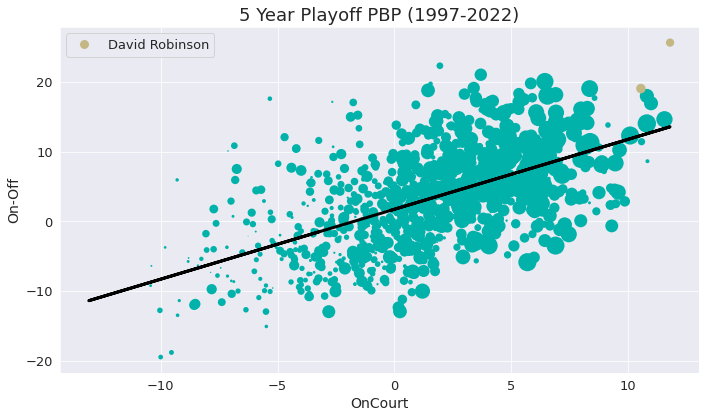

In [ ]:
#@title David Robinson
graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()
graph_data = graph_data.sort_values('Player', ascending=False)

graph_data['MPG'] = graph_daata['MP'] / graph_data['G']

Robinson = (graph_data['Player']=='David Robinson')
graph_data['color']= np.where( Robinson==True , "#C5B783", "#00B2A9")

#D_color_label = {"#C5B783": "David Robinson",
#                  "#00B2A9": "Everyone Else"}
#colors = list(graph_data["color"].unique())
#labels = [D_color_label[x] for x in graph_data["color"].unique()]


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(10,6), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='5 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='David Robinson', markerfacecolor='#C5B783',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper left')


# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)
plt.show()

In [ ]:
#@title Big 3 PBP Plots
graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

fig, axis = plt.subplots(4)
fig.set_figheight(25)
fig.set_figwidth(10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# 3 year
tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)



size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.9, 's':size*4, 'linewidth':0}, ax=axis[0])
axis[0].set(title='3 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[0].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[0].plot(x_pred, pred, color="k", linewidth=3)



# 5 year
graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)



size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.9, 's':size*4, 'linewidth':0}, ax=axis[1])
axis[1].set(title='5 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[1].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[1].plot(x_pred, pred, color="k", linewidth=3)



# 8 year
graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)



size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.9, 's':size*4, 'linewidth':0}, ax=axis[2])
axis[2].set(title='8 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[2].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[2].plot(x_pred, pred, color="k", linewidth=3)



# 10 year
graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)



size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':0.9, 's':size*4, 'linewidth':0}, ax=axis[3])
axis[3].set(title='10 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[3].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[3].plot(x_pred, pred, color="k", linewidth=3)
plt.show()

fig.savefig('Big_3_PBP_Peaks', bbox_inches='tight')

In [ ]:
#@title Big 3 Scoring Plots

fig, axis = plt.subplots(6)
fig.set_figheight(35)
fig.set_figwidth(15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


# 2 year
graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data[(graph_data['MP']) >= 300]
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[0])
axis[0].set(title='2 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[0].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[0].plot(x_pred, pred, color="k", linewidth=3)




# 3 year
graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[1])
axis[1].set(title='3 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[1].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[1].plot(x_pred, pred, color="k", linewidth=3)



# 5 year
graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G']
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[2])
axis[2].set(title='5 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[2].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[2].plot(x_pred, pred, color="k", linewidth=3)



# 8 year
graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[3])
axis[3].set(title='8 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[3].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[3].plot(x_pred, pred, color="k", linewidth=3)


# 10 year
graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[4])
axis[4].set(title='10 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[4].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[4].plot(x_pred, pred, color="k", linewidth=3)



# 1 year
graph_data =  pd.read_csv('/content/nba_player_since74playoffs_per75_data.csv', encoding='utf8')
graph_data = graph_data[(graph_data['MP']) >= 150]
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()
no_second = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
no_second = no_second.append(no_first[no_first["Player"] != "Tony Parker"])
tmp_data = tmp_data.append(no_second[no_second['Player'] != "Tim Duncan"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Tim Duncan')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color'] = np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)
graph_data['color'] = np.where((graph_data.Player == 'Tim Duncan'),'#9E7E38', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[5])
axis[5].set(title='1 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Tim Duncan', markerfacecolor='#9E7E38',  markersize=10)]
axis[5].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS%+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[5].plot(x_pred, pred, color="k", linewidth=3)
plt.show()

fig.savefig('Big_3_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Tony/Manu PBP Plots
graph_data =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

fig, axis = plt.subplots(4)
fig.set_figheight(25)
fig.set_figwidth(10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# 3 year
tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player'] == 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[0])
axis[0].set(title='3 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[0].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[0].plot(x_pred, pred, color="k", linewidth=3)



# 5 year
graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player'] == 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[1])
axis[1].set(title='5 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[1].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[1].plot(x_pred, pred, color="k", linewidth=3)



# 8 year
graph_data =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player'] == 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[2])
axis[2].set(title='8 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[2].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[2].plot(x_pred, pred, color="k", linewidth=3)



# 10 year
graph_data =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player'] == 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[3])
axis[3].set(title='10 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[3].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[3].plot(x_pred, pred, color="k", linewidth=3)
plt.show()

fig.savefig('Tony_Manu_PBP_Peaks', bbox_inches='tight')

In [ ]:
#@title Tony/Manu Scoring Plots

fig, axis = plt.subplots(6)
fig.set_figheight(35)
fig.set_figwidth(15)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# 2 year
graph_data = pd.read_csv('/content/Two_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data[(graph_data['MP']) >= 300]
graph_data = graph_data.dropna()
tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 

Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")

graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[0])
axis[0].set(title='2 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[0].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[0].plot(x_pred, pred, color="k", linewidth=3)



# 3 year
graph_data =  pd.read_csv('/content/Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data[(graph_data['MP']) >= 300]
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[1])
axis[1].set(title='3 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[1].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[1].plot(x_pred, pred, color="k", linewidth=3)



# 5 year
graph_data =  pd.read_csv('/content/Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[2])
axis[2].set(title='5 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[2].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[2].plot(x_pred, pred, color="k", linewidth=3)



# 8 year
graph_data =  pd.read_csv('/content/Eight_Year_scoring_Playoff_Peaks_1500min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[3])
axis[3].set(title='8 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[3].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[3].plot(x_pred, pred, color="k", linewidth=3)


# 10 year
graph_data =  pd.read_csv('/content/Ten_Year_scoring_Playoff_Peaks_2000min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[4])
axis[4].set(title='10 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[4].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[4].plot(x_pred, pred, color="k", linewidth=3)



# 1 year
graph_data =  pd.read_csv('/content/nba_player_since74playoffs_per75_data.csv', encoding='utf8')
graph_data = graph_data[(graph_data['MP']) >= 150]
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 
Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")
graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(20,12), tight_layout=True)
sns.regplot(data=graph_data, x="PTS", y="TS%+", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0}, ax=axis[5])
axis[5].set(title='1 Year Playoff Scoring (1974-2022)', xlabel='Pts per 75', ylabel='TS+')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
axis[5].legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['PTS']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['TS%+']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
axis[5].plot(x_pred, pred, color="k", linewidth=3)
plt.show()


fig.savefig('Tony_Manu_Scoring_Peaks', bbox_inches='tight')

In [ ]:
#@title Just 1 plot template
graph_data =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
graph_data = graph_data.dropna()

tmp_data = pd.DataFrame()
no_first = pd.DataFrame()

no_first = no_first.append(graph_data[graph_data["Player"] != "Manu Ginóbili"])
tmp_data = tmp_data.append(no_first[no_first["Player"] != "Tony Parker"])
no_first = graph_data[(graph_data['Player'] == 'Tony Parker')]
tmp_data = tmp_data.append(no_first)
no_first = graph_data[(graph_data['Player'] == 'Manu Ginóbili')]
tmp_data = tmp_data.append(no_first)
graph_data = tmp_data

graph_data['MPG'] = graph_data['MP'] / graph_data['G'] 

Manu = (graph_data['Player']== 'Manu Ginóbili')
graph_data['color']= np.where(Manu==True, "#FF8200", "#00B2A9")

graph_data['color'] = np.where((graph_data.Player == 'Tony Parker'),'#EF426F', graph_data.color)


size = 100 * ((graph_data['MP'] - graph_data['MP'].min()) / (graph_data['MP'].max() - graph_data['MP'].min()))
plt.figure(figsize=(10,6), tight_layout=True)
sns.color_palette("flare", as_cmap=True)
ax = sns.regplot(data=graph_data, x="OnCourt", y="On-Off", fit_reg=False, scatter_kws={'facecolors':graph_data['color'], 'alpha':1.0, 's':size*4, 'linewidth':0})
ax.set(title='5 Year Playoff PBP (1997-2022)', xlabel='OnCourt', ylabel='On-Off')

legend_elements = [Line2D([0], [0], marker='o', color='#EAEAF2', label='Tony Parker', markerfacecolor='#EF426F',  markersize=10),
                   Line2D([0], [0], marker='o', color='#EAEAF2', label='Manu Ginóbili', markerfacecolor='#FF8200',  markersize=10)]
ax.legend(handles=legend_elements, loc='upper left')

# ridge regression
x_pred = graph_data['OnCourt']
x_pred = np.array(x_pred).reshape(-1, 1)
y_pred = graph_data['On-Off']
reg = linear_model.Ridge(alpha=10)
reg.fit(x_pred, y_pred)
pred = reg.predict(x_pred)
ax.plot(x_pred, pred, color="k", linewidth=3)
plt.show()

In [ ]:
#@title Pretty Colors Plot

size = 100 * ((big3['MP'] - big3['MP'].min()) / (big3['MP'].max() - big3['MP'].min()))


plt.figure(figsize=(17,9), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=big3, x=0, y='MPG', hue='Player', palette='Set2', s=size*4)
ax.set(title='Multi-Year Playoff MPG', xlabel='G', ylabel='MPG')

#fiveyearpbptext = fiveyearpbp.loc[(fiveyearpbp['OnCourt'] >= 10) | (fiveyearpbp['OnCourt'] <= -6 ) | (fiveyearpbp['On-Off'] >= 18)]
#ax = sns.scatterplot(data=onlyrob, x='OnCourt', y='On-Off', palette=color, s=60)
#label_point(onlyrob['OnCourt'], onlyrob['On-Off'], onlyrob['Player'], plt.gca())
plt.xlim(-.01, .01)
plt.savefig('Big 3 Scoring Plot', bbox_inches='tight')
plt.show()


In [ ]:
#@title 2 3 5 8 Manu/Tony Scoring Plot
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# 2
fiveyearpbp =  pd.read_csv('/content/2_Playoff_Scoring_Prime_Change_300min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
#fiveyearpbp['MPG'] = fiveyearpbp['MP'] / fiveyearpbp['G']
fiveyearpbp = fiveyearpbp.sort_values('TS+_post', ascending=False)
size = 100 * ((fiveyearpbp['MP_post'] - fiveyearpbp['MP_post'].min()) / (fiveyearpbp['MP_post'].max() - fiveyearpbp['MP_post'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS per 75_post', y='TS+_post', hue='Player', palette='Set2', s=size*4)
ax.set(title='2 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
plt.show()

# 3
fiveyearpbp =  pd.read_csv('/content/3_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
#fiveyearpbp['MPG'] = fiveyearpbp['MP'] / fiveyearpbp['G']
fiveyearpbp = fiveyearpbp.sort_values('TS+_post', ascending=False)
size = 100 * ((fiveyearpbp['MP_post'] - fiveyearpbp['MP_post'].min()) / (fiveyearpbp['MP_post'].max() - fiveyearpbp['MP_post'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS per 75_post', y='TS+_post', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
plt.show()

# 5
fiveyearpbp =  pd.read_csv('/content/5_Playoff_Scoring_Prime_Change_500min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
#fiveyearpbp['MPG'] = fiveyearpbp['MP'] / fiveyearpbp['G']
fiveyearpbp = fiveyearpbp.sort_values('TS+_post', ascending=False)
size = 100 * ((fiveyearpbp['MP_post'] - fiveyearpbp['MP_post'].min()) / (fiveyearpbp['MP_post'].max() - fiveyearpbp['MP_post'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS per 75_post', y='TS+_post', hue='Player', palette='Set2', s=size*4)
ax.set(title='5 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
plt.show()


# 8
fiveyearpbp =  pd.read_csv('/content/8_Playoff_Scoring_Prime_Change_1500min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
#fiveyearpbp['MPG'] = fiveyearpbp['MP'] / fiveyearpbp['G']
fiveyearpbp = fiveyearpbp.sort_values('TS+_post', ascending=False)
size = 100 * ((fiveyearpbp['MP_post'] - fiveyearpbp['MP_post'].min()) / (fiveyearpbp['MP_post'].max() - fiveyearpbp['MP_post'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='PTS per 75_post', y='TS+_post', hue='Player', palette='Set2', s=size*4)
ax.set(title='8 Year Playoff Scoring', xlabel='PTS per 75', ylabel='TS+')
plt.show()

In [ ]:
#@title 3 5 8 10 Manu/Tony PBP Plot
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

# 3
fiveyearpbp =  pd.read_csv('/content/Three_Year_pbp_Peaks_NBA_Playoffs_300_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
fiveyearpbp = fiveyearpbp.sort_values('Player', ascending=True)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='3 Year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
plt.show()

# 5
fiveyearpbp =  pd.read_csv('/content/Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
fiveyearpbp = fiveyearpbp.sort_values('Player', ascending=True)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='5 Year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
plt.show()

# 8
fiveyearpbp =  pd.read_csv('/content/Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
fiveyearpbp = fiveyearpbp.sort_values('Player', ascending=True)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='8 Year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
plt.show()

# 10
fiveyearpbp =  pd.read_csv('/content/Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv', encoding='utf8')
fiveyearpbp = fiveyearpbp.loc[(fiveyearpbp['Player'] =='Tony Parker') | (fiveyearpbp['Player'] =='Manu Ginóbili')]
fiveyearpbp = fiveyearpbp.sort_values('Player', ascending=True)
size = 100 * ((fiveyearpbp['MP'] - fiveyearpbp['MP'].min()) / (fiveyearpbp['MP'].max() - fiveyearpbp['MP'].min()))

plt.figure(figsize=(10,6), tight_layout=True)
colors = sns.color_palette('pastel')
ax = sns.scatterplot(data=fiveyearpbp, x='OnCourt', y='On-Off', hue='Player', palette='Set2', s=size*4)
ax.set(title='10 Year Playoff PBP', xlabel='OnCourt', ylabel='On-Off')
plt.show()

**REGULAR SEASON WORK IN PROGRESS**

In [ ]:
part_1_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year <= 1990)]
part_2_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 1985) & (import_player_since74_per75_df.Year <= 2000)]
part_3_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 1995) & (import_player_since74_per75_df.Year <= 2010)]
part_4_years = import_player_since74_per75_df[(import_player_since74_per75_df.Year >= 2005)]

In [ ]:
#@title regular season scoring peaks run function
threeyearpeak(import_player_since74_per75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74_per75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

**RUN ADJUSTED PEAK FUNCTIONS**

In [58]:
#@title 2 year adjusted playoff scoring peaks run function
twoyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)
twoyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [57]:
#@title 3 year adjusted playoff scoring peaks run function
threeyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

threeyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [56]:
#@title 4 year adjusted playoff scoring peaks run function
fouryearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

fouryearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('four_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [55]:
#@title 5 year adjusted playoff scoring peaks run function
fiveyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [54]:
#@title 6 year adjusted playoff scoring peaks run function
sixyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

sixyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('six_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [53]:
#@title 7 year adjusted playoff scoring peaks run function
sevenyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

sevenyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('seven_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [52]:
#@title 8 year adjusted playoff scoring peaks run function
eightyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

eightyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

In [51]:
#@title 10 year adjusted playoff scoring peaks run function
tenyearpeak(adjusted_playoff_per_75_df, 'PTS')
import_player_longPTS_peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_player_longPTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_PTS_data.csv"
import_player_longPTS_peaks_df.to_csv(outfile, index=False)

tenyearpeak(adjusted_playoff_per_75_df, 'TS%+')
import_player_longTS_peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_player_longTS_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_TS%+_data.csv"
import_player_longTS_peaks_df.to_csv(outfile, index=False)

**IMPORT ADJUSTED PEAK DATA**

In [59]:
#@title Import 2 year adjusted playoff scoring peaks
import_adjpts_twopeaks_df = pd.read_csv('two_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_twopeaks_df = import_adjpts_twopeaks_df.assign(TeamColor=0)

import_adjts_twopeaks_df = pd.read_csv('two_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_twopeaks_df = import_adjts_twopeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_twopeaks_df['TeamColor'] = import_adjpts_twopeaks_df['Team'].map(team_colors)
import_adjts_twopeaks_df['TeamColor'] = import_adjts_twopeaks_df['Team'].map(team_colors)

In [60]:
#@title Import 3 year adjusted playoff scoring peaks
import_adjpts_threepeaks_df = pd.read_csv('three_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_threepeaks_df = import_adjpts_threepeaks_df.assign(TeamColor=0)

import_adjts_threepeaks_df = pd.read_csv('three_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_threepeaks_df = import_adjts_threepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_threepeaks_df['TeamColor'] = import_adjpts_threepeaks_df['Team'].map(team_colors)
import_adjts_threepeaks_df['TeamColor'] = import_adjts_threepeaks_df['Team'].map(team_colors)

In [61]:
#@title Import 4 year adjusted playoff scoring peaks
import_adjpts_4peaks_df = pd.read_csv('four_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_4peaks_df = import_adjpts_4peaks_df.assign(TeamColor=0)

import_adjts_4peaks_df = pd.read_csv('four_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_4peaks_df = import_adjts_4peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_4peaks_df['TeamColor'] = import_adjpts_4peaks_df['Team'].map(team_colors)
import_adjts_4peaks_df['TeamColor'] = import_adjts_4peaks_df['Team'].map(team_colors)

In [62]:
#@title Import 5 year adjusted playoff scoring peaks
import_adjpts_fivepeaks_df = pd.read_csv('five_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_fivepeaks_df = import_adjpts_fivepeaks_df.assign(TeamColor=0)

import_adjts_fivepeaks_df = pd.read_csv('five_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_fivepeaks_df = import_adjts_fivepeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_fivepeaks_df['TeamColor'] = import_adjpts_fivepeaks_df['Team'].map(team_colors)
import_adjts_fivepeaks_df['TeamColor'] = import_adjts_fivepeaks_df['Team'].map(team_colors)

In [63]:
#@title Import 6 year adjusted playoff scoring peaks
import_adjpts_6peaks_df = pd.read_csv('six_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_6peaks_df = import_adjpts_6peaks_df.assign(TeamColor=0)

import_adjts_6peaks_df = pd.read_csv('six_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_6peaks_df = import_adjts_6peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_6peaks_df['TeamColor'] = import_adjts_6peaks_df['Team'].map(team_colors)
import_adjpts_6peaks_df['TeamColor'] = import_adjpts_6peaks_df['Team'].map(team_colors)

In [64]:
#@title Import 7 year adjusted playoff scoring peaks
import_adjpts_7peaks_df = pd.read_csv('seven_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_7peaks_df = import_adjpts_7peaks_df.assign(TeamColor=0)

import_adjts_7peaks_df = pd.read_csv('seven_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_7peaks_df = import_adjts_7peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjts_7peaks_df['TeamColor'] = import_adjts_7peaks_df['Team'].map(team_colors)
import_adjpts_7peaks_df['TeamColor'] = import_adjpts_7peaks_df['Team'].map(team_colors)

In [65]:
#@title Import 8 year adjusted playoff scoring peaks
import_adjpts_eightpeaks_df = pd.read_csv('eight_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_eightpeaks_df = import_adjpts_eightpeaks_df.assign(TeamColor=0)

import_adjts_eightpeaks_df = pd.read_csv('eight_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_eightpeaks_df = import_adjts_eightpeaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_eightpeaks_df['TeamColor'] = import_adjpts_eightpeaks_df['Team'].map(team_colors)
import_adjts_eightpeaks_df['TeamColor'] = import_adjts_eightpeaks_df['Team'].map(team_colors)

In [66]:
#@title Import 10 year adjusted playoff scoring peaks
import_adjpts_10peaks_df = pd.read_csv('ten_year_peak_PTS_data.csv', encoding='utf8')
import_adjpts_10peaks_df = import_adjpts_10peaks_df.assign(TeamColor=0)

import_adjts_10peaks_df = pd.read_csv('ten_year_peak_TS%+_data.csv', encoding='utf8')
import_adjts_10peaks_df = import_adjts_10peaks_df.assign(TeamColor=0)

# add team color for plotting
import_adjpts_10peaks_df['TeamColor'] = import_adjpts_10peaks_df['Team'].map(team_colors)
import_adjts_10peaks_df['TeamColor'] = import_adjts_10peaks_df['Team'].map(team_colors)

**OUTPUT ADJUSTED PEAK FILES**

In [ ]:
#@title 2 year adjusted playoff scoring peaks (>= 300 min) Output File

at_least_400_min_2pts = import_adjpts_twopeaks_df[(import_adjpts_twopeaks_df['MP'] >= 400)]
at_least_400_min_2pts = at_least_400_min_2pts.reset_index(drop=True)

at_least_400_min_2ts = import_adjts_twopeaks_df[(import_adjts_twopeaks_df['MP'] >= 400)]
at_least_400_min_2ts = at_least_400_min_2ts.reset_index(drop=True)

sorted_2pts = at_least_400_min_2pts.copy()
sorted_2pts.insert(6, "TS+", at_least_400_min_2ts['PeakValue'])
sorted_2pts = sorted_2pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_2pts = sorted_2pts.sort_values('PTS', ascending=False)
#sorted_2pts = sorted_2pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'TeamColor', 'G']
sorted_2pts = sorted_2pts.reindex(columns=columns_titles)

sorted_2pts['PTS'] = sorted_2pts['PTS'].round(2)
sorted_2pts['TS+'] = sorted_2pts['TS+'].round(2)

sorted_2pts = sorted_2pts.dropna()

print(sorted_2pts)

sorted_2pts.to_csv("Adjusted_Two_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 3 year adjusted playoff scoring peaks (>= 400 min) Output File

# 400 minutes filter
at_least_400_min_pts = import_adjpts_threepeaks_df[(import_adjpts_threepeaks_df['MP'] >= 400)]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_adjts_threepeaks_df[(import_adjts_threepeaks_df['MP'] >= 400)]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)

sorted_3pts = at_least_400_min_pts.copy()
sorted_3pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_3pts = sorted_3pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_3pts = sorted_3pts.sort_values('PTS', ascending=False)
sorted_3pts = sorted_3pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_3pts = sorted_3pts.reindex(columns=columns_titles)

sorted_3pts['PTS'] = sorted_3pts['PTS'].round(2)
sorted_3pts['TS+'] = sorted_3pts['TS+'].round(2)

sorted_3pts = sorted_3pts.dropna()

print(sorted_3pts)

sorted_3pts.to_csv("Adjusted_Three_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 4 year adjusted playoff scoring peaks (>= 600 min) Output File

# 400 minutes filter
at_least_400_min_pts = import_adjpts_4peaks_df[(import_adjpts_4peaks_df['MP'] >= 600)]
at_least_400_min_pts = at_least_400_min_pts.reset_index(drop=True)

at_least_400_min_ts = import_adjts_4peaks_df[(import_adjts_4peaks_df['MP'] >= 600)]
at_least_400_min_ts = at_least_400_min_ts.reset_index(drop=True)

sorted_3pts = at_least_400_min_pts.copy()
sorted_3pts.insert(6, "TS+", at_least_400_min_ts['PeakValue'])
sorted_3pts = sorted_3pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_3pts = sorted_3pts.sort_values('PTS', ascending=False)
sorted_3pts = sorted_3pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_3pts = sorted_3pts.reindex(columns=columns_titles)

sorted_3pts['PTS'] = sorted_3pts['PTS'].round(2)
sorted_3pts['TS+'] = sorted_3pts['TS+'].round(2)

sorted_3pts = sorted_3pts.dropna()

print(sorted_3pts)

sorted_3pts.to_csv("Adjusted_Four_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 5 year adjusted playoff scoring peaks (>=800 min) Output File

at_least_800_min_pts = import_adjpts_fivepeaks_df[(import_adjpts_fivepeaks_df['MP'] >= 800)]
at_least_800_min_ts = import_adjts_fivepeaks_df[(import_adjts_fivepeaks_df['MP'] >= 800)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Adjusted_Five_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 6 year adjusted playoff scoring peaks (>=1000 min) Output File

at_least_800_min_pts = import_adjpts_6peaks_df[(import_adjpts_6peaks_df['MP'] >= 1000)]
at_least_800_min_ts = import_adjts_6peaks_df[(import_adjts_6peaks_df['MP'] >= 1000)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Adjusted_Six_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 7 year adjusted playoff scoring peaks (>=1200 min) Output File

at_least_800_min_pts = import_adjpts_7peaks_df[(import_adjpts_7peaks_df['MP'] >= 1200)]
at_least_800_min_ts = import_adjts_7peaks_df[(import_adjts_7peaks_df['MP'] >= 1200)]


sorted_5pts = at_least_800_min_pts.copy()
sorted_5pts.insert(6, "TS+", at_least_800_min_ts['PeakValue'])
sorted_5pts = sorted_5pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_5pts = sorted_5pts.sort_values('PTS', ascending=False)
sorted_5pts = sorted_5pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_5pts = sorted_5pts.reindex(columns=columns_titles)
sorted_5pts = sorted_5pts.reset_index(drop=True)

sorted_5pts['PTS'] = sorted_5pts['PTS'].round(2)
sorted_5pts['TS+'] = sorted_5pts['TS+'].round(2)

sorted_5pts = sorted_5pts.dropna()

print(sorted_5pts)

sorted_5pts.to_csv("Adjusted_Seven_Year_scoring_Playoff_Peaks.csv", index=False)

In [ ]:
#@title 8 year adjusted playoff scoring peaks (>=1500 min) Output File

at_least_1500_min_pts = import_adjpts_eightpeaks_df[(import_adjpts_eightpeaks_df['MP'] >= 1500)]
at_least_1500_min_ts = import_adjts_eightpeaks_df[(import_adjts_eightpeaks_df['MP'] >= 1500)]


sorted_8pts = at_least_1500_min_pts.copy()
sorted_8pts.insert(6, "TS+", at_least_1500_min_ts['PeakValue'])
sorted_8pts = sorted_8pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_8pts = sorted_8pts.sort_values('PTS', ascending=False)
sorted_8pts = sorted_8pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_8pts = sorted_8pts.reindex(columns=columns_titles)
sorted_8pts = sorted_8pts.reset_index(drop=True)

sorted_8pts['PTS'] = sorted_8pts['PTS'].round(2)
sorted_8pts['TS+'] = sorted_8pts['TS+'].round(2)

sorted_8pts = sorted_8pts.dropna()


print(sorted_8pts)

sorted_8pts.to_csv("Adjusted_Eight_Year_scoring_Playoff_Peaks_1500min.csv", index=False)

In [ ]:
#@title 10 year adjusted playoff scoring peaks (>=2000 min) Output File

at_least_2000_min_pts = import_adjpts_10peaks_df[(import_adjpts_10peaks_df['MP'] >= 2000)]
at_least_2000_min_ts = import_adjts_10peaks_df[(import_adjts_10peaks_df['MP'] >= 2000)]


sorted_10pts = at_least_2000_min_pts.copy()
sorted_10pts.insert(6, "TS+", at_least_2000_min_ts['PeakValue'])
sorted_10pts = sorted_10pts.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PTS", "MP": "MP", "TeamColor": "TeamColor", "TS+": "TS+", "G": "G"})

sorted_10pts = sorted_10pts.sort_values('PTS', ascending=False)
sorted_10pts = sorted_10pts.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PTS', 'TS+', 'MP', 'G']
sorted_10pts = sorted_10pts.reindex(columns=columns_titles)
sorted_10pts = sorted_10pts.reset_index(drop=True)
sorted_10pts['PTS'] = sorted_10pts['PTS'].round(2)
sorted_10pts['TS+'] = sorted_10pts['TS+'].round(2)

sorted_10pts = sorted_10pts.dropna()

print(sorted_10pts)

sorted_10pts.to_csv("Adjusted_Ten_Year_scoring_Playoff_Peaks_2000min.csv", index=False)

**PLAY-BY-PLAY PEAKS**

In [ ]:


#@title 3 year regular pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_3year_OnOff_reg_peaks_df[(import_player_3year_OnOff_reg_peaks_df['MP'] >= 5000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)


at_least_3000_min_OnCourt = import_player_3year_OnCourt_reg_peaks_df[(import_player_3year_OnCourt_reg_peaks_df['MP'] >= 5000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_3reg = at_least_3000_min_OnOff.copy()
sorted_3reg.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])

sorted_3reg = sorted_3reg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor"})

sorted_3reg = sorted_3reg.sort_values('On-Off', ascending=False)
sorted_3reg = sorted_3reg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_3reg = sorted_3reg.reindex(columns=columns_titles)
sorted_3reg = sorted_3reg.sort_values('On-Off', ascending=False)

print(sorted_3reg)

sorted_3reg.to_csv("Three_Year_pbp_Peaks_NBA_Regular_3000_min.csv", index=False)

In [ ]:
#@title 5 year regular pbp peaks (>= 5000 min) Output File

at_least_5000_min_OnOff = import_player_5year_OnOff_reg_peaks_df[(import_player_5year_OnOff_reg_peaks_df['MP'] >= 5000)]
at_least_5000_min_OnOff = at_least_5000_min_OnOff.reset_index(drop=True)


at_least_5000_min_OnCourt = import_player_5year_OnCourt_reg_peaks_df[(import_player_5year_OnCourt_reg_peaks_df['MP'] >= 5000)]
at_least_5000_min_OnCourt = at_least_5000_min_OnCourt.reset_index(drop=True)

sorted_5reg = at_least_5000_min_OnOff.copy()
sorted_5reg.insert(6, "OnCourt", at_least_5000_min_OnCourt['PeakValue'])

sorted_5reg = sorted_5reg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor"})

sorted_5reg = sorted_5reg.sort_values('On-Off', ascending=False)
sorted_5reg = sorted_5reg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP']
sorted_5reg = sorted_5reg.reindex(columns=columns_titles)
sorted_5reg = sorted_5reg.sort_values('On-Off', ascending=False)

print(sorted_5reg)

sorted_5reg.to_csv("Five_Year_pbp_Peaks_NBA_Regular_5000_min.csv", index=False)

In [ ]:
#@title 2 year playoff pbp peaks (>= 300 min) Output File
at_least_400_min_OnOff = import_player_2year_OnOff_peaks_df[(import_player_2year_OnOff_peaks_df['MP'] >= 300)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_2year_OnCourt_peaks_df[(import_player_2year_OnCourt_peaks_df['MP'] >= 300)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_2playoffs = at_least_400_min_OnOff.copy()
sorted_2playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_2playoffs = sorted_2playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "G": "G"})
sorted_2playoffs = sorted_2playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_2playoffs = sorted_2playoffs.reindex(columns=columns_titles)
sorted_2playoffs = sorted_2playoffs.sort_values('On-Off', ascending=False)
sorted_2playoffs = sorted_2playoffs.dropna()

print(sorted_2playoffs)

sorted_2playoffs.to_csv("Two_Year_pbp_Peaks_NBA_Playoffs_300_min.csv", index=False)

In [ ]:
#@title 3 year playoff pbp peaks (>= 400 min) Output File
at_least_400_min_OnOff = import_player_3year_OnOff_peaks_df[(import_player_3year_OnOff_peaks_df['MP'] >= 400)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_3year_OnCourt_peaks_df[(import_player_3year_OnCourt_peaks_df['MP'] >= 400)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_3playoffs = at_least_400_min_OnOff.copy()
sorted_3playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_3playoffs = sorted_3playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "G": "G"})
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3playoffs = sorted_3playoffs.reindex(columns=columns_titles)
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
sorted_3playoffs = sorted_3playoffs.dropna()

print(sorted_3playoffs)

sorted_3playoffs.to_csv("Three_Year_pbp_Peaks_NBA_Playoffs_400_min.csv", index=False)

In [ ]:
#@title 4 year playoff pbp peaks (>= 600 min) Output File
at_least_400_min_OnOff = import_player_4year_OnOff_peaks_df[(import_player_4year_OnOff_peaks_df['MP'] >= 600)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_4year_OnCourt_peaks_df[(import_player_4year_OnCourt_peaks_df['MP'] >= 600)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_3playoffs = at_least_400_min_OnOff.copy()
sorted_3playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_3playoffs = sorted_3playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "G": "G"})
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3playoffs = sorted_3playoffs.reindex(columns=columns_titles)
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
sorted_3playoffs = sorted_3playoffs.dropna()

print(sorted_3playoffs)

sorted_3playoffs.to_csv("Four_Year_pbp_Peaks_NBA_Playoffs_600_min.csv", index=False)

In [ ]:
#@title 5 year playoff pbp peaks (>= 1000 min) Output File

at_least_1000_min_OnOff = import_player_5year_OnOff_peaks_df[(import_player_5year_OnOff_peaks_df['MP'] >= 1000)]
at_least_1000_min_OnOff = at_least_1000_min_OnOff.reset_index(drop=True)

at_least_1000_min_OnCourt = import_player_5year_OnCourt_peaks_df[(import_player_5year_OnCourt_peaks_df['MP'] >= 1000)]
at_least_1000_min_OnCourt = at_least_1000_min_OnCourt.reset_index(drop=True)

sorted_5playoffs = at_least_1000_min_OnOff.copy()
sorted_5playoffs.insert(6, "OnCourt", at_least_1000_min_OnCourt['PeakValue'])
sorted_5playoffs = sorted_5playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt", "G": "G"})

sorted_5playoffs = sorted_5playoffs.sort_values('On-Off', ascending=False)
sorted_5playoffs = sorted_5playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_5playoffs = sorted_5playoffs.reindex(columns=columns_titles)
sorted_5playoffs = sorted_5playoffs.sort_values('On-Off', ascending=False)

print(sorted_5playoffs)

sorted_5playoffs.to_csv("Five_Year_pbp_Peaks_NBA_Playoffs_1000_min.csv", index=False)

In [ ]:
#@title 6 year playoff pbp peaks (>= 1400 min) Output File
at_least_400_min_OnOff = import_player_6year_OnOff_peaks_df[(import_player_6year_OnOff_peaks_df['MP'] >= 1400)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_6year_OnCourt_peaks_df[(import_player_6year_OnCourt_peaks_df['MP'] >= 1400)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_3playoffs = at_least_400_min_OnOff.copy()
sorted_3playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_3playoffs = sorted_3playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "G": "G"})
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3playoffs = sorted_3playoffs.reindex(columns=columns_titles)
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
sorted_3playoffs = sorted_3playoffs.dropna()

print(sorted_3playoffs)

sorted_3playoffs.to_csv("Six_Year_pbp_Peaks_NBA_Playoffs_1400_min.csv", index=False)

In [ ]:
#@title 7 year playoff pbp peaks (>= 2000 min) Output File
at_least_400_min_OnOff = import_player_7year_OnOff_peaks_df[(import_player_7year_OnOff_peaks_df['MP'] >= 2000)]
at_least_400_min_OnOff = at_least_400_min_OnOff.reset_index(drop=True)

at_least_400_min_OnCourt = import_player_7year_OnCourt_peaks_df[(import_player_7year_OnCourt_peaks_df['MP'] >= 2000)]
at_least_400_min_OnCourt = at_least_400_min_OnCourt.reset_index(drop=True)

sorted_3playoffs = at_least_400_min_OnOff.copy()
sorted_3playoffs.insert(6, "OnCourt", at_least_400_min_OnCourt['PeakValue'])
sorted_3playoffs = sorted_3playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "OnCourt": "OnCourt", "MP": "MP", "TeamColor": "TeamColor", "G": "G"})
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
#sorted_On3Off = sorted_On3Off.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_3playoffs = sorted_3playoffs.reindex(columns=columns_titles)
sorted_3playoffs = sorted_3playoffs.sort_values('On-Off', ascending=False)
sorted_3playoffs = sorted_3playoffs.dropna()

print(sorted_3playoffs)

sorted_3playoffs.to_csv("Seven_Year_pbp_Peaks_NBA_Playoffs_2000_min.csv", index=False)

In [ ]:
#@title 8 year playoff pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_8year_OnOff_peaks_df[(import_player_8year_OnOff_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)

at_least_3000_min_OnCourt = import_player_8year_OnCourt_peaks_df[(import_player_8year_OnCourt_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_8playoffs = at_least_3000_min_OnOff.copy()
sorted_8playoffs.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])
sorted_8playoffs = sorted_8playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt", "G": "G"})

sorted_8playoffs = sorted_8playoffs.sort_values('On-Off', ascending=False)
sorted_8playoffs = sorted_8playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_8playoffs = sorted_8playoffs.reindex(columns=columns_titles)
sorted_8playoffs = sorted_8playoffs.sort_values('On-Off', ascending=False)

print(sorted_8playoffs)

sorted_8playoffs.to_csv("Eight_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv", index=False)

In [ ]:
#@title 10 year playoff pbp peaks (>= 3000 min) Output File

at_least_3000_min_OnOff = import_player_10year_OnOff_peaks_df[(import_player_10year_OnOff_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnOff = at_least_3000_min_OnOff.reset_index(drop=True)

at_least_3000_min_OnCourt = import_player_10year_OnCourt_peaks_df[(import_player_10year_OnCourt_peaks_df['MP'] >= 3000)]
at_least_3000_min_OnCourt = at_least_3000_min_OnCourt.reset_index(drop=True)

sorted_10playoffs = at_least_3000_min_OnOff.copy()
sorted_10playoffs.insert(6, "OnCourt", at_least_3000_min_OnCourt['PeakValue'])
sorted_10playoffs = sorted_10playoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "On-Off", "MP": "MP", "TeamColor": "TeamColor", "OnCourt": "OnCourt", "G": "G"})

sorted_10playoffs = sorted_10playoffs.sort_values('On-Off', ascending=False)
sorted_10playoffs = sorted_10playoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'On-Off', 'OnCourt', 'MP', 'G']
sorted_10playoffs = sorted_10playoffs.reindex(columns=columns_titles)
sorted_10playoffs = sorted_10playoffs.sort_values('OnCourt', ascending=True)

print(sorted_10playoffs)

sorted_10playoffs.to_csv("Ten_Year_pbp_Peaks_NBA_Playoffs_3000_min.csv", index=False)

In [ ]:
#@title 3 year playoff PGA & And1 peaks (>= 1000 min) Output File

at_least_300_min_PGA = import_player_3year_PGA_peaks_df[(import_player_3year_PGA_peaks_df['MP'] >= 300)]
at_least_300_min_PGA = at_least_300_min_PGA.reset_index(drop=True)

at_least_300_min_And1 = import_player_3year_And1_peaks_df[(import_player_3year_And1_peaks_df['MP'] >= 300)]
at_least_300_min_And1 = at_least_300_min_And1.reset_index(drop=True)

sorted_3And1PGAplayoffs = at_least_300_min_PGA.copy()
sorted_3And1PGAplayoffs.insert(6, "And1", at_least_300_min_And1['PeakValue'])
sorted_3And1PGAplayoffs.insert(7, "PGA/36", (at_least_300_min_PGA['PeakValue']/sorted_3And1PGAplayoffs['MP'])*36*5)
sorted_3And1PGAplayoffs.insert(8, "And1/36", (at_least_300_min_And1['PeakValue']/sorted_3And1PGAplayoffs['MP'])*36*5)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.sort_values('PGA', ascending=False)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.reindex(columns=columns_titles)
sorted_3And1PGAplayoffs = sorted_3And1PGAplayoffs.sort_values('PGA', ascending=False)

print(sorted_3And1PGAplayoffs)

sorted_3And1PGAplayoffs.to_csv("Three_Year_And1_PGA_Peaks_NBA_Playoffs_300_min.csv", index=False)

In [ ]:
#@title 5 year playoff PGA & And1 peaks (>= 1000 min) Output File

at_least_1000_min_PGA = import_player_5year_PGA_peaks_df[(import_player_5year_PGA_peaks_df['MP'] >= 1000)]
at_least_1000_min_PGA = at_least_1000_min_PGA.reset_index(drop=True)

at_least_1000_min_And1 = import_player_5year_And1_peaks_df[(import_player_5year_And1_peaks_df['MP'] >= 1000)]
at_least_1000_min_And1 = at_least_1000_min_And1.reset_index(drop=True)

sorted_5And1PGAplayoffs = at_least_1000_min_PGA.copy()
sorted_5And1PGAplayoffs.insert(6, "And1", at_least_1000_min_And1['PeakValue'])
sorted_5And1PGAplayoffs.insert(7, "PGA/36", (at_least_1000_min_PGA['PeakValue']/sorted_5And1PGAplayoffs['MP'])*36*5)
sorted_5And1PGAplayoffs.insert(8, "And1/36", (at_least_1000_min_And1['PeakValue']/sorted_5And1PGAplayoffs['MP'])*36*5)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.sort_values('PGA', ascending=False)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.reindex(columns=columns_titles)
sorted_5And1PGAplayoffs = sorted_5And1PGAplayoffs.sort_values('PGA', ascending=False)

print(sorted_5And1PGAplayoffs)

sorted_5And1PGAplayoffs.to_csv("Five_Year_And1_PGA_Peaks_NBA_Playoffs_1000_min.csv", index=False)

In [ ]:
#@title 3 year regular season PGA & And1 peaks (>= 1000 min) Output File

at_least_3000_min_reg_PGA = import_player_3year_reg_PGA_peaks_df[(import_player_3year_reg_PGA_peaks_df['MP'] >= 3000)]
at_least_3000_min_reg_PGA = at_least_3000_min_reg_PGA.reset_index(drop=True)

at_least_3000_min_reg_And1 = import_player_3year_reg_And1_peaks_df[(import_player_3year_reg_And1_peaks_df['MP'] >= 3000)]
at_least_3000_min_reg_And1 = at_least_3000_min_reg_And1.reset_index(drop=True)

sorted_3And1PGAreg = at_least_3000_min_reg_PGA.copy()
sorted_3And1PGAreg.insert(6, "And1", at_least_3000_min_reg_And1['PeakValue'])
sorted_3And1PGAreg.insert(7, "PGA/36", (at_least_3000_min_reg_PGA['PeakValue']/sorted_3And1PGAreg['MP'])*36*5)
sorted_3And1PGAreg.insert(8, "And1/36", (at_least_3000_min_reg_And1['PeakValue']/sorted_3And1PGAreg['MP'])*36*5)
sorted_3And1PGAreg = sorted_3And1PGAreg.rename(columns={"Years": "Years", "Player": "Player", "Team": "Team", "PeakValue": "PGA", "MP": "MP", "TeamColor": "TeamColor", "And1": "And1", "PGA/36": "PGA/36", "And1/36": "And1/36"})

sorted_3And1PGAreg = sorted_3And1PGAreg.sort_values('PGA', ascending=False)
sorted_3And1PGAreg = sorted_3And1PGAreg.drop(columns=['TeamColor'])

columns_titles = ['Player', 'Years', 'Team', 'PGA', 'And1', 'PGA/36', 'And1/36', 'MP']
sorted_3And1PGAreg = sorted_3And1PGAreg.reindex(columns=columns_titles)
sorted_3And1PGAreg = sorted_3And1PGAreg.sort_values('PGA', ascending=False)

print(sorted_3And1PGAreg)

sorted_3And1PGAreg.to_csv("Three_Year_And1_PGA_Peaks_NBA_Reg_3000_min.csv", index=False)

In [ ]:
#@title 2 year playoff PBP peaks run function
twoyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('two_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

twoyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('two_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoff PBP peaks run function
threeyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('three_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 4 year playoff PBP peaks run function
fouryearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('four_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

fouryearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('four_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"four_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff PBP peaks run function
fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 6 year playoff PBP peaks run function
sixyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('six_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

sixyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('six_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"six_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 7 year playoff PBP peaks run function
sevenyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('seven_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

sevenyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('seven_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"seven_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 8 year playoff PBP peaks run function
eightyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('eight_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

eightyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('eight_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"eight_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 10 year playoff PBP peaks run function
tenyearpeak(import_player_since74playoffs_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('ten_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

tenyearpeak(import_player_since74playoffs_playbyplay_df, 'OnCourt')
import_player_OnOff_peaks_df = pd.read_csv('ten_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"ten_year_peak_OnCourt_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [67]:
#@title Import 3 and 5 year scoring peaks (pre-assembled)
import_player_pts_reg3peaks_df = pd.read_csv('Three_Year_scoring_Reg_Peaks.csv', encoding='utf8')
import_player_pts_reg3peaks_df = import_player_pts_reg3peaks_df.assign(TeamColor=0)
import_player_pts_reg3peaks_df['TeamColor'] = import_player_pts_reg3peaks_df['Team'].map(team_colors)


import_player_pts_reg5peaks_df = pd.read_csv('Five_Year_scoring_Reg_Peaks.csv', encoding='utf8')
import_player_pts_reg5peaks_df = import_player_pts_reg5peaks_df.assign(TeamColor=0)
import_player_pts_reg5peaks_df['TeamColor'] = import_player_pts_reg5peaks_df['Team'].map(team_colors)


import_player_pts_playoff3peaks_df = pd.read_csv('Three_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_playoff3peaks_df = import_player_pts_playoff3peaks_df.assign(TeamColor=0)
import_player_pts_playoff3peaks_df['TeamColor'] = import_player_pts_playoff3peaks_df['Team'].map(team_colors)


import_player_pts_playoff5peaks_df = pd.read_csv('Five_Year_scoring_Playoff_Peaks.csv', encoding='utf8')
import_player_pts_playoff5peaks_df = import_player_pts_playoff5peaks_df.assign(TeamColor=0)
import_player_pts_playoff5peaks_df['TeamColor'] = import_player_pts_playoff5peaks_df['Team'].map(team_colors)

FileNotFoundError: ignored

In [ ]:
#@title 2 year regular season on-off peaks run function
twoyearpeak(import_player_regular_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('two_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 2 year regular season oncourt peaks run function
twoyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('two_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"two_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year regular season oncourt peaks run function
threeyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season on-off peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'On-Off')
import_player_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_OnOff_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_On-Off_data.csv"
import_player_OnOff_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season oncourt peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'OnCourt')
import_player_OnCourt_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_OnCourt_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_OnCourt_data.csv"
import_player_OnCourt_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year playoffs PGA & AND1 peaks run function
threeyearpeak(import_player_since74playoffs_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_since74playoffs_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year playoff PGA & AND1 peaks run function
fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_since74playoffs_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 3 year regular season PGA & AND1 peaks run function
threeyearpeak(import_player_regular_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

threeyearpeak(import_player_regular_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"three_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title 5 year regular season PGA & AND1 peaks run function
fiveyearpeak(import_player_regular_playbyplay_df, 'PGA')
import_player_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_PGA_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_PGA_data.csv"
import_player_PGA_peaks_df.to_csv(outfile, index=False)

fiveyearpeak(import_player_regular_playbyplay_df, 'And1')
import_player_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_And1_peaks_df.drop_duplicates(keep='first', inplace=True)
outfile = f"five_year_peak_And1_data.csv"
import_player_And1_peaks_df.to_csv(outfile, index=False)

In [ ]:
#@title Import 3 year regular season PBP peaks (don't have)
import_player_3year_OnOff_reg_peaks_df = pd.read_csv('three_year_peak_reg_On-Off_data.csv', encoding='utf8')
import_player_3year_OnOff_reg_peaks_df = import_player_3year_OnOff_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnOff_reg_peaks_df['TeamColor'] = import_player_3year_OnOff_reg_peaks_df['Team'].map(team_colors)

import_player_3year_OnCourt_reg_peaks_df = pd.read_csv('three_year_peak_regular_OnCourt_data.csv', encoding='utf8')
import_player_3year_OnCourt_reg_peaks_df = import_player_3year_OnCourt_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnCourt_reg_peaks_df['TeamColor'] = import_player_3year_OnCourt_reg_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year regular season PBP peaks
import_player_5year_OnOff_reg_peaks_df = pd.read_csv('five_year_peak_reg_On-Off_data.csv', encoding='utf8')
import_player_5year_OnOff_reg_peaks_df = import_player_5year_OnOff_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnOff_reg_peaks_df['TeamColor'] = import_player_5year_OnOff_reg_peaks_df['Team'].map(team_colors)


import_player_5year_OnCourt_reg_peaks_df = pd.read_csv('five_year_peak_reg_OnCourt_data.csv', encoding='utf8')
import_player_5year_OnCourt_reg_peaks_df = import_player_5year_OnCourt_reg_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnCourt_reg_peaks_df['TeamColor'] = import_player_5year_OnCourt_reg_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 2 year playoff PBP peaks
import_player_2year_OnOff_peaks_df = pd.read_csv('two_year_peak_On-Off_data.csv', encoding='utf8')
import_player_2year_OnOff_peaks_df = import_player_2year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_2year_OnOff_peaks_df['TeamColor'] = import_player_2year_OnOff_peaks_df['Team'].map(team_colors)

#@title Import 2 year playoff oncourt peaks
import_player_2year_OnCourt_peaks_df = pd.read_csv('two_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_2year_OnCourt_peaks_df = import_player_2year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_2year_OnCourt_peaks_df['TeamColor'] = import_player_2year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year playoff PBP peaks
import_player_3year_OnOff_peaks_df = pd.read_csv('three_year_peak_On-Off_data.csv', encoding='utf8')
import_player_3year_OnOff_peaks_df = import_player_3year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnOff_peaks_df['TeamColor'] = import_player_3year_OnOff_peaks_df['Team'].map(team_colors)

#@title Import 3 year playoff oncourt peaks
import_player_3year_OnCourt_peaks_df = pd.read_csv('three_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_3year_OnCourt_peaks_df = import_player_3year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_OnCourt_peaks_df['TeamColor'] = import_player_3year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 4 year playoff PBP peaks
import_player_4year_OnOff_peaks_df = pd.read_csv('four_year_peak_On-Off_data.csv', encoding='utf8')
import_player_4year_OnOff_peaks_df = import_player_4year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_4year_OnOff_peaks_df['TeamColor'] = import_player_4year_OnOff_peaks_df['Team'].map(team_colors)

#@title Import 3 year playoff oncourt peaks
import_player_4year_OnCourt_peaks_df = pd.read_csv('four_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_4year_OnCourt_peaks_df = import_player_4year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_4year_OnCourt_peaks_df['TeamColor'] = import_player_4year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year playoff PBP peaks
import_player_5year_OnOff_peaks_df = pd.read_csv('five_year_peak_On-Off_data.csv', encoding='utf8')
import_player_5year_OnOff_peaks_df = import_player_5year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnOff_peaks_df['TeamColor'] = import_player_5year_OnOff_peaks_df['Team'].map(team_colors)

#@title Import 5 year playoff oncourt peaks
import_player_5year_OnCourt_peaks_df = pd.read_csv('five_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_5year_OnCourt_peaks_df = import_player_5year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_OnCourt_peaks_df['TeamColor'] = import_player_5year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 6 year playoff PBP peaks
import_player_6year_OnOff_peaks_df = pd.read_csv('six_year_peak_On-Off_data.csv', encoding='utf8')
import_player_6year_OnOff_peaks_df = import_player_6year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_6year_OnOff_peaks_df['TeamColor'] = import_player_6year_OnOff_peaks_df['Team'].map(team_colors)

import_player_6year_OnCourt_peaks_df = pd.read_csv('six_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_6year_OnCourt_peaks_df = import_player_6year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_6year_OnCourt_peaks_df['TeamColor'] = import_player_6year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 7 year playoff PBP peaks
import_player_7year_OnOff_peaks_df = pd.read_csv('seven_year_peak_On-Off_data.csv', encoding='utf8')
import_player_7year_OnOff_peaks_df = import_player_7year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_7year_OnOff_peaks_df['TeamColor'] = import_player_7year_OnOff_peaks_df['Team'].map(team_colors)

import_player_7year_OnCourt_peaks_df = pd.read_csv('seven_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_7year_OnCourt_peaks_df = import_player_7year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_7year_OnCourt_peaks_df['TeamColor'] = import_player_7year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 8 year playoff PBP peaks
import_player_8year_OnOff_peaks_df = pd.read_csv('eight_year_peak_On-Off_data.csv', encoding='utf8')
import_player_8year_OnOff_peaks_df = import_player_8year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_8year_OnOff_peaks_df['TeamColor'] = import_player_8year_OnOff_peaks_df['Team'].map(team_colors)

import_player_8year_OnCourt_peaks_df = pd.read_csv('eight_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_8year_OnCourt_peaks_df = import_player_8year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_8year_OnCourt_peaks_df['TeamColor'] = import_player_8year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 10 year playoff PBP peaks
import_player_10year_OnOff_peaks_df = pd.read_csv('ten_year_peak_On-Off_data.csv', encoding='utf8')
import_player_10year_OnOff_peaks_df = import_player_10year_OnOff_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_10year_OnOff_peaks_df['TeamColor'] = import_player_10year_OnOff_peaks_df['Team'].map(team_colors)

import_player_10year_OnCourt_peaks_df = pd.read_csv('ten_year_peak_OnCourt_data.csv', encoding='utf8')
import_player_10year_OnCourt_peaks_df = import_player_10year_OnCourt_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_10year_OnCourt_peaks_df['TeamColor'] = import_player_10year_OnCourt_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year playoff PGA and And1 peaks
import_player_3year_And1_peaks_df = pd.read_csv('three_year_peak_And1_data.csv', encoding='utf8')
import_player_3year_And1_peaks_df = import_player_3year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_And1_peaks_df['TeamColor'] = import_player_3year_And1_peaks_df['Team'].map(team_colors)



import_player_3year_PGA_peaks_df = pd.read_csv('three_year_peak_PGA_data.csv', encoding='utf8')
import_player_3year_PGA_peaks_df = import_player_3year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_PGA_peaks_df['TeamColor'] = import_player_3year_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 3 year regular season PGA and And1 peaks
import_player_3year_reg_And1_peaks_df = pd.read_csv('three_year_peak_reg_And1_data.csv', encoding='utf8')
import_player_3year_reg_And1_peaks_df = import_player_3year_reg_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_reg_And1_peaks_df['TeamColor'] = import_player_3year_reg_And1_peaks_df['Team'].map(team_colors)



import_player_3year_reg_PGA_peaks_df = pd.read_csv('three_year_peak_reg_PGA_data.csv', encoding='utf8')
import_player_3year_reg_PGA_peaks_df = import_player_3year_reg_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_3year_reg_PGA_peaks_df['TeamColor'] = import_player_3year_reg_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year playoff PGA and And1 peaks
import_player_5year_And1_peaks_df = pd.read_csv('five_year_peak_And1_data.csv', encoding='utf8')
import_player_5year_And1_peaks_df = import_player_5year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_And1_peaks_df['TeamColor'] = import_player_5year_And1_peaks_df['Team'].map(team_colors)



import_player_5year_PGA_peaks_df = pd.read_csv('five_year_peak_PGA_data.csv', encoding='utf8')
import_player_5year_PGA_peaks_df = import_player_5year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_PGA_peaks_df['TeamColor'] = import_player_5year_PGA_peaks_df['Team'].map(team_colors)

In [ ]:
#@title Import 5 year regular season PGA and And1 peaks
import_player_5year_And1_peaks_df = pd.read_csv('five_year_peak_reg_And1_data.csv', encoding='utf8')
import_player_5year_And1_peaks_df = import_player_5year_And1_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_And1_peaks_df['TeamColor'] = import_player_5year_And1_peaks_df['Team'].map(team_colors)



import_player_5year_PGA_peaks_df = pd.read_csv('five_year_peak_reg_PGA_data.csv', encoding='utf8')
import_player_5year_PGA_peaks_df = import_player_5year_PGA_peaks_df.assign(TeamColor=0)





# add team color for plotting
import_player_5year_PGA_peaks_df['TeamColor'] = import_player_5year_PGA_peaks_df['Team'].map(team_colors)

**SMALL USE CASE PEAK FUNCTION DEFINITIONS**

In [ ]:
#@title 2 year fragmented peaks function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def fragtwoyearpeak(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'Team', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes played
    prev_1back = 0
    prev_1min = 0

    # peak start and end season
    present_peak_years = [0, 0]

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store team player played on a season and 2 seasons ago in case they change teams during peak 3 years.
    prevyear = 0
    prevYearTeam = 0

    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']
          old_team = prevYearTeam

          if inner_row['Year'] != present_year:
            prevYearTeam = 0
            prev_1back = 0
            prev_1min = 0
            prevyear = 0
            indexlist = []


          # can finally store years as this player has had 2 consecutive seasons (not reached after 2 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+2 and len(indexlist) >=2:
            two_seasons_count = player['Year']

          # move present value to previous year's value
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevYearTeam = inner_row['Tm']
            prevyear = inner_row['Year']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'Team', 'PeakValue', 'MP']
            if (old_team == inner_row['Tm']):
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], inner_row['Tm'], running_two_year_peak_val, running_min]], columns=cols)
            else:
                df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], 'TOT', running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 2 year peaks (manual data) function

# def twoyearpeak(df, valuestring):
# returns a dataframe containing 2 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 2 year stretches of 'valuestring' AND the listed years from each 2 year stretch + minutes played across the 2 seasons.
# EX: twoyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-19', 'Kris Middleton', 'MIL' '23.32', '4231'
def twoyearpeak_manual_data(df, valuestring):
  two_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0



    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    two_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # store the team a player played with 1 season and 2 seasons ago in case they change teams during peak 3 years.

    prevyear = 0


    indexlist = []
    running_two_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    old_team = 0
    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min)
          if running_min == 0:
            running_min = 1
          running_two_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev_1back = 0
            prev_1min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+1 and len(indexlist) >=2:
            if (prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prevyear, present_year)
            else:
              present_peak_years = '{}, {}'.format(prevyear, present_year)

          if two_seasons_count == original_year+3 and len(indexlist) >=3:
            two_seasons_count = player['Year']
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          two_seasons_count = two_seasons_count + 1

          if len(indexlist) >=2:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_two_year_peak_val, running_min]], columns=cols)
            two_year_peak = two_year_peak.append(df_temp)
            outfile = f"two_year_peak_{valuestring}_data.csv"
            two_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 3 year peaks (manual data) function

# def threeyearpeak(df, valuestring):
# returns a dataframe containing 3 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 3 year stretches of 'valuestring' AND the listed years from each 3 year stretch + minutes played across the 3 seasons.
# EX: threeyearpeak(import_player_since74_per100_df, 'PTS') returns 3 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2018-20', 'Kris Middleton', 'MIL' '23.32', '7120'
def threeyearpeak_manual_data(df, valuestring):
  three_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue and minutes
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue and minutes
    prev_2back = 0
    prev_2min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    three_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    # previous two years; e.g. 2014, 2015 before 2016. 2016, 2019 if these were the two most recent seasons for a player before 2020.
    prevyear = 0
    prev2year = 0

    indexlist = []
    running_three_year_peak_val = 0
    running_min = 0
    games = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min)
          if running_min == 0:
            running_min = 1
          running_three_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+2 and len(indexlist) >=3:
            if (prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev2year, present_year)
            else:
              present_peak_years = '{}, {}, {}'.format(prev2year, prevyear, present_year)

          if three_seasons_count == original_year+3 and len(indexlist) >=3:
            three_seasons_count = player['Year']
          if present_year == original_year+1:
            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          three_seasons_count = three_seasons_count + 1

          if len(indexlist) >=3:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_three_year_peak_val, running_min]], columns=cols)
            three_year_peak = three_year_peak.append(df_temp)
            outfile = f"three_year_peak_{valuestring}_data.csv"
            three_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 5 year peaks (manual data) function

# def fiveyearpeak(df, valuestring):
# returns a dataframe containing 5 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 5 year stretches of 'valuestring' AND the listed years from each 5 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 5 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def fiveyearpeak_manual_data(df, valuestring):
  five_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    five_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0


    indexlist = []
    running_five_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min)
          if running_min == 0:
            running_min = 1
          running_five_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev4year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}'.format(prev4year, prev3year, prev2year, prevyear, present_year)

          if five_seasons_count == original_year+5 and len(indexlist) >=5:
            five_seasons_count = player['Year']
          if present_year == original_year+1:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          five_seasons_count = five_seasons_count + 1

          if len(indexlist) >=5:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_five_year_peak_val, running_min]], columns=cols)
            five_year_peak = five_year_peak.append(df_temp)
            outfile = f"five_year_peak_{valuestring}_data.csv"
            five_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 6 year peaks (manual data) function

# def sixyearpeak(df, valuestring):
# returns a dataframe containing 6 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 6 year stretches of 'valuestring' AND the listed years from each 6 year stretch + minutes played across the 5 seasons.
# EX: sixyearpeak(import_player_since74_per100_df, 'PTS') returns 6 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2016-21', 'Kris Middleton', 'MIL' '22.11', '12139'
def sixyearpeak_manual_data(df, valuestring):
  six_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    six_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0


    indexlist = []
    running_six_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min)
          if running_min == 0:
            running_min = 1
          running_six_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+5 and len(indexlist) >=6:
            if (prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev5year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}'.format(prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if six_seasons_count == original_year+6 and len(indexlist) >=6:
            six_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          six_seasons_count = six_seasons_count + 1

          if len(indexlist) >=6:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_six_year_peak_val, running_min]], columns=cols)
            six_year_peak = six_year_peak.append(df_temp)
            outfile = f"six_year_peak_{valuestring}_data.csv"
            six_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 8 year peaks (manual data) function

# def eightyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def eightyearpeak_manual_data(df, valuestring):
  eight_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    eight_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']


    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0


    indexlist = []
    running_eight_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min)
          if running_min == 0:
            running_min = 1
          running_eight_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev7year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}'.format(prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if eight_seasons_count == original_year+10 and len(indexlist) >=10:
            eight_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          eight_seasons_count = eight_seasons_count + 1

          if len(indexlist) >=8:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_eight_year_peak_val, running_min]], columns=cols)
            eight_year_peak = eight_year_peak.append(df_temp)
            outfile = f"eight_year_peak_{valuestring}_data.csv"
            eight_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])

In [ ]:
#@title 10 year peaks (manual data) function

# def tenyearpeak(df, valuestring):
# returns a dataframe containing 10 year stretches of 'valuestring' contained within pandas dataframe, 'df'.
# returned dataframe containts 10 year stretches of 'valuestring' AND the listed years from each 10 year stretch + minutes played across the 5 seasons.
# EX: fiveyearpeak(import_player_since74_per100_df, 'PTS') returns 10 year PTS peaks from all players in 'import_player_since74_per100_df' DataFrame as well as the listed years.
# EX returned row: '2011-20', 'Kris Middleton', 'MIL' '22.11', '12139'
def tenyearpeak_manual_data(df, valuestring):
  ten_year_peak = pd.DataFrame(columns = ['Years', 'Player', 'PeakValue', 'MP'])
  
   # for each player (starting with players as early as possible)
  for idx, player in df.iterrows():

    outer_player = player['Player']

    # previous season's peakvalue
    prev_1back = 0
    prev_1min = 0

    # 2 seasons ago's peakvalue
    prev_2back = 0
    prev_2min = 0

    # 3 seasons ago's peakvalue
    prev_3back = 0
    prev_3min = 0

    # 4 seasons ago's peakvalue
    prev_4back = 0
    prev_4min = 0

    # 5 seasons ago's peakvalue
    prev_5back = 0
    prev_5min = 0

    # 6 seasons ago's peakvalue
    prev_6back = 0
    prev_6min = 0

    # 7 seasons ago's peakvalue
    prev_7back = 0
    prev_7min = 0

    # 8 seasons ago's peakvalue
    prev_8back = 0
    prev_8min = 0

    # 9 seasons ago's peakvalue
    prev_9back = 0
    prev_9min = 0

    # peak start and end season
    present_peak_years = ''

    # starting season original value
    present_year = player['Year']
    ten_seasons_count = player['Year']

    # starting season original value
    original_year = player['Year']

    prevyear = 0
    prev2year = 0
    prev3year = 0
    prev4year = 0
    prev5year = 0
    prev6year = 0
    prev7year = 0
    prev8year = 0
    prev9year = 0


    indexlist = []
    running_ten_year_peak_val = 0
    running_min = 0

    numSeasons = df[(df['Player'] == player['Player'])]

    player_finished = []


    
    # each season from the SAME player as outer for-loop
    if player['Player'] not in player_finished:
      # trim newdf to only contain player from outerrow so it is less expensive a search to find all their other seasons
      newdf = df[(df['Player'] == player['Player'])]
      for inner_idx, inner_row in newdf.iterrows():
        if inner_row['Player'] == outer_player and inner_row['Year'] >= original_year:
          running_min = (inner_row['MP'] + prev_1min + prev_2min + prev_3min + prev_4min + prev_5min + prev_6min + prev_7min + prev_8min + prev_9min)
          if running_min == 0:
            running_min = 1
          running_ten_year_peak_val = ((inner_row[valuestring] * (inner_row['MP'] / running_min)) + (prev_1back * (prev_1min / running_min)) + (prev_2back * (prev_2min / running_min)) + (prev_3back * (prev_3min / running_min)) + (prev_4back * (prev_4min / running_min)) + (prev_5back * (prev_5min / running_min)) + (prev_6back * (prev_6min / running_min)) + (prev_7back * (prev_7min / running_min)) + (prev_8back * (prev_8min / running_min)) + (prev_9back * (prev_9min / running_min)))
          indexlist.append(present_year)
          present_year = inner_row['Year']

          if inner_row['Year'] != present_year:
            prevyear = 0
            prev2year = 0
            prev3year = 0
            prev4year = 0
            prev5year = 0
            prev6year = 0
            prev7year = 0
            prev8year = 0
            prev9year = 0
            prev_9back = 0
            prev_8back = 0
            prev_7back = 0
            prev_6back = 0
            prev_5back = 0
            prev_4back = 0
            prev_3back = 0
            prev_2back = 0
            prev_1back = 0
            prev_1min = 0
            prev_2min = 0
            prev_3min = 0
            prev_4min = 0
            prev_5min = 0
            prev_6min = 0
            prev_7min = 0
            prev_8min = 0
            prev_9min = 0
            indexlist = []


          # can finally store years as this player has had 3 consecutive seasons (not reached after 3 rows of a player is found)
          if present_year >= original_year+4 and len(indexlist) >=5:
            if (prev9year == (prev8year-1) and prev8year == (prev7year-1) and prev7year == (prev6year-1) and prev6year == (prev5year-1) and prev5year == (prev4year-1) and prev4year == (prev3year-1) and prev3year == (prev2year-1) and prev2year == (prevyear-1) and prevyear == (present_year-1)):
              present_peak_years = '{} - {}'.format(prev9year, present_year)
            else:
              present_peak_years = '{}, {}, {}, {}, {}, {}, {}, {}, {}, {}'.format(prev9year, prev8year, prev7year, prev6year, prev5year, prev4year, prev3year, prev2year, prevyear, present_year)

          if ten_seasons_count == original_year+10 and len(indexlist) >=10:
            ten_seasons_count = player['Year']
          if present_year == original_year+1:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back

            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear
          if present_year == original_year:
            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']
          if present_year > original_year:

            prev_9back = prev_8back
            prev_9min = prev_8min
            prev9year = prev8year

            prev_8back = prev_7back
            prev_8min = prev_7min
            prev8year = prev7year

            prev_7back = prev_6back
            prev_7min = prev_6min
            prev7year = prev6year

            prev_6back = prev_5back
            prev_6min = prev_5min
            prev6year = prev5year

            prev_5back = prev_4back
            prev_5min = prev_4min
            prev5year = prev4year
            
            prev_4back = prev_3back
            prev_4min = prev_3min
            prev4year = prev3year

            prev_3back = prev_2back
            prev_3min = prev_2min
            prev3year = prev2year

            prev_2back = prev_1back
            prev_2min = prev_1min
            prev2year = prevyear

            prev_1back = inner_row[valuestring]
            prev_1min = inner_row['MP']
            prevyear = inner_row['Year']

          ten_seasons_count = ten_seasons_count + 1

          if len(indexlist) >=10:
            cols = ['Years', 'Player', 'PeakValue', 'MP']
            df_temp = pd.DataFrame([[present_peak_years, inner_row['Player'], running_ten_year_peak_val, running_min]], columns=cols)
            ten_year_peak = ten_year_peak.append(df_temp)
            outfile = f"ten_year_peak_{valuestring}_data.csv"
            ten_year_peak.to_csv(outfile, index=False)
            player_finished.append(inner_row['Player'])